In [ ]:
!pip install ipynb sklearn progressbar2

In [1]:
from ipynb.fs.full.utils import *
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
tf.get_logger().setLevel('ERROR')

In [3]:
res = 24

In [4]:
def draw(imgs, labels):
    fig, axs = plt.subplots(1, len(imgs), figsize=(15, 3), sharey=True, subplot_kw=dict(projection='3d'))
    for i in range(len(imgs)):
        cube1 = (imgs[i][:,:,:] >= 1)
        axs[i].voxels(cube1, facecolors="blue")
        axs[i].set_title(labels[i])
    plt.show()

In [5]:
class Histogram:
    def __init__(self, histX, histY, histZ, label):
        self.histX = histX
        self.histY = histY
        self.histZ = histZ
        self.label = label
        
    @classmethod
    def load(self, filename):
        with open(filename + '.pkl', 'rb') as input:
            return pickle.load(input)
    
    def save(self, filename):
        with open(filename + '.pkl', 'wb') as output:
            pickle.dump(self, output, pickle.HIGHEST_PROTOCOL)
            
    def draw(self):
        fig, axs = plt.subplots(1, 3, figsize=(15, 3), sharey=True)
        axs[0].bar(range(res), self.histX)
        axs[0].set_title(self.label + ' X')
        axs[1].bar(range(res), self.histY)
        axs[1].set_title('Y')
        axs[2].bar(range(res), self.histZ)
        axs[2].set_title('Z')
        plt.show()
        
    def getData(self):
        return [self.histX, self.histY, self.histZ]

In [6]:
def calculate_histogram(obj, label, res):
    objy = np.moveaxis(obj, [0, 1, 2], [1, 0, 2])
    objz = np.moveaxis(obj, [0, 1, 2], [1, 2, 0])
    #calculate the histogram in 3 axis
    histx = np.zeros(res, dtype=int)
    histy = np.zeros(res, dtype=int)
    histz = np.zeros(res, dtype=int)
    for i in range(res):
        ox = obj[i].reshape([res * res])
        histx[i] = ox[ox == 1].size

        oy = objy[i].reshape([res * res])
        histy[i] = oy[oy == 1].size

        oz = objz[i].reshape([res * res])
        histz[i] = oz[oz == 1].size
    return Histogram(histx, histy, histz, label)


In [108]:
def draw_histogram(histograms, label):
    fig, axs = plt.subplots(1, 3, figsize=(15, 3), sharey=True)
    axs[0].bar(range(res), histograms.histX)
    axs[0].set_title('X')
    axs[1].bar(range(res), histograms.histY)
    axs[1].set_title('Y')
    axs[2].bar(range(res), histograms.histZ)
    axs[2].set_title('Z')
    plt.suptitle('Model: {}'.format(label), y=0.01)
    plt.show()

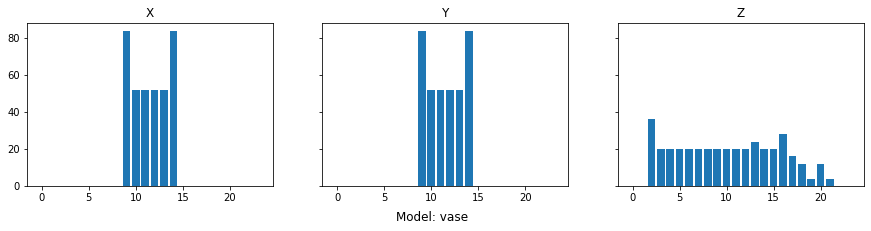

In [115]:
i = random.randint(0, len(training))
draw_histogram(calculate_histogram(training[i], training_labels[i], res), all_labels[training_labels[i]])

# Calculate and save histograms

In [ ]:
bar2 = progressbar.ProgressBar(max_value=len(all_labels)-1)

for i, label in enumerate(all_labels):
    bar2.update(i)
    training, training_labels = load_data(res, [label], 'train', 1, 0, False)
    for j in range(len(training)):
        histograms = calculate_histogram(training[j], label, res)
        histograms.save('histograms/train-' + histograms.label + '-' + str(j))
    test, testlabels = load_data(res, [label], 'test', 1, False, False)
    for j in range(len(test)):
        histograms = calculate_histogram(test[j], label, res)
        histograms.save('histograms/test-' + histograms.label + '-' + str(j))


In [8]:
bar2 = progressbar.ProgressBar(max_value=len(all_labels)-1)
training_histograms = []
test_histograms = []
training_histograms_labels = np.empty(0, int)
test_histograms_labels = np.empty(0, int)

for i, label in enumerate(all_labels):
    bar2.update(i)
    training, training_labels = load_data(res, [label], 'train', 1, 0, False)
    for j in range(len(training)):
        training_histograms.append(calculate_histogram(training[j], label, res).getData())
    training_histograms_labels = np.concatenate((training_histograms_labels, np.full(len(training), i, dtype=int)))

    test, testlabels = load_data(res, [label], 'test', 1, False, False)
    for j in range(len(test)):
        test_histograms.append(calculate_histogram(test[j], label, res).getData())
    test_histograms_labels = np.concatenate((test_histograms_labels, np.full(len(test), i, dtype=int)))

rng_state = np.random.get_state()
np.random.shuffle(training_histograms)
np.random.set_state(rng_state)
#np.random.shuffle(training_histograms_labels)


100% (39 of 39) |########################| Elapsed Time: 0:00:16 ETA:  00:00:00

In [ ]:
print(training_histograms[0])

In [ ]:
def fail_load_histograms(source_labels, dataset = 'train', verbosity=0, shuffle = True):
    bar = progressbar.ProgressBar(max_value=len(source_labels)-1)
    data = []
    labels = np.empty(0, dtype=int)
    for i, label in enumerate(source_labels):
        histogram = Histogram.load('histograms/' + dataset + '-' + label + '-' + str(i))
        data.append(histogram.getData())
        labels = np.append(labels, i)
    if shuffle:
        rng_state = np.random.get_state()
        np.random.shuffle(data)
        np.random.set_state(rng_state)
        np.random.shuffle(labels)
    
    return (data, labels)


# Prepare Network 

In [9]:
class Model:
    def __init__(self, res, num_classes, verbosity):
        self.prepare_model(res, num_classes, verbosity)
        
    def prepare_model(self, res, num_classes, verbosity = 0):
        pass
    
    def train(self, training, training_labels, res, num_classes, verbosity = 0, log = False, epochs = None, earlystop = True):
        log_dir = "logs/fit/" + str(res) + '-' + str(num_classes) + '-' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        callbacks = []
        if earlystop:
            callbacks.append([
                tf.keras.callbacks.EarlyStopping(
                    monitor="val_accuracy",
                    min_delta=0.0001,
                    patience=20,
                    verbose=1,
                    mode="max",
                    baseline=None,
                    restore_best_weights=True,
                )
            ])
        if verbosity == 1 and log:
            print("Log file " + log_dir)
        if log:
            callbacks.append(tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1))

        validation_split = 0.1
        if epochs == None:
            epochs = 2 * num_classes

        self.model.fit(
            self.prepare_data(training, num_classes, res), 
            training_labels, 
            epochs=epochs,
            verbose=verbosity,
            callbacks=callbacks,
            validation_split=validation_split
    )
    
    def evaluate(self, test, test_labels, verbose):
        return self.model.evaluate(
            test,
            test_labels, 
            verbose=2
        )
    
    def save(self, filename):
        self.model.save(filename)
        
    def load(self, filename):
        self.model = keras.models.load_model(filename)
        
    def predict(self, data):
        return self.model.predict(data)
        

In [22]:
class ModelDense(Model): 
    
    def __init__(self, res, num_classes, verbosity):
        super().__init__(res, num_classes, verbosity)

    def prepare_model(self, res, num_classes, verbosity = 0):
        self.model = keras.Sequential([
            keras.layers.Flatten(input_shape=(3, res)),
            keras.layers.Dense(res*2, activation='relu'),
            keras.layers.Dense(res/2, activation='sigmoid'),
            keras.layers.Dropout(.2, input_shape=(2,)),
            keras.layers.Dense(40, activation='softmax')
        ])

        learning_rate = 0.0001

        self.model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        if (verbosity == 1):
            print(self.model.summary())
            
    def prepare_data(self, data, num_classes, res):
        return np.array(data).reshape(len(data), 3, res, 1)
    model_type = 'dense'

In [185]:
class ModelConv3D(Model):

    def __init__(self, res, num_classes, verbosity):
        super().__init__(res, num_classes, verbosity)
    
    def prepare_model(self, res, num_classes, verbosity = 0):
        self.model = keras.Sequential([
            keras.layers.Conv2D(
                    num_classes * 6, 
                    kernel_size=((2,3)),
#                    strides=(2),
                    activation='relu', 
                    kernel_initializer='he_uniform', 
                    data_format="channels_last",
                    input_shape=(3, res, 1)
                ),        
            keras.layers.Conv2D(
                    num_classes * 2, 
                    kernel_size=(1),
#                    strides=(2),
                    activation='relu', 
                    kernel_initializer='he_uniform'
                ),        
            #keras.layers.Conv3D(
            #        res, 
            #        kernel_size=(2),
            #        activation='relu', 
            #        kernel_initializer='he_uniform'
            #    ),        

            keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None),
            keras.layers.Flatten(),
            keras.layers.Dense(res/2, activation='relu'),
            keras.layers.Dense(num_classes, activation='softmax')
        ])

        learning_rate = 0.0001

        self.model.compile(
            optimizer=keras.optimizers.Adam(lr=learning_rate),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        if (verbosity == 1):
            print(self.model.summary())

    def prepare_data(self, data, num_classes, res):
        return np.array(data).reshape(len(data), 3, res, 1)
    model_type = 'conv3d'


In [12]:
training_histograms = []
training, training_labels = load_data(res, all_labels, 'train', 1, 0, True)
for j in range(len(training)):
    training_histograms.append(calculate_histogram(training[j], label, res).getData())
    

In [83]:
training_labels

array([ 8, 23,  9, ..., 37, 37, 19])

In [ ]:
len(training_histograms)

In [186]:
def load_histograms(labels, res, dataset, shuffle):
    bar2 = progressbar.ProgressBar(max_value=len(labels)-1)
    histograms = []
    histograms_labels = np.empty(0, int)

    for i, label in enumerate(labels):
        bar2.update(i)
        data, data_labels = load_data(res, [label], dataset, 1, 0, False)
        for j in range(len(data)):
            histograms.append(calculate_histogram(data[j], label, res).getData())
        histograms_labels = np.concatenate((histograms_labels, np.full(len(data), i, dtype=int)))

    if shuffle:
        rng_state = np.random.get_state()
        np.random.shuffle(histograms)
        np.random.set_state(rng_state)
        np.random.shuffle(histograms_labels)
    return (histograms, histograms_labels)
training_histograms, training_labels = load_histograms(all_labels, 24, 'train', True)
len(training_histograms)

100% (39 of 39) |########################| Elapsed Time: 0:01:40 ETA:  00:00:00

9803

In [187]:
num_classes = len(all_labels)
#model = ModelDense(res, num_classes, 1)
model = ModelConv3D(res, num_classes, 1)
model.train(training_histograms, training_labels, res, num_classes, 2, False, 150, False)


Model: "sequential_3967"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7918 (Conv2D)         (None, 2, 22, 240)        1680      
_________________________________________________________________
conv2d_7919 (Conv2D)         (None, 2, 22, 80)         19280     
_________________________________________________________________
max_pooling2d_3959 (MaxPooli (None, 1, 11, 80)         0         
_________________________________________________________________
flatten_3967 (Flatten)       (None, 880)               0         
_________________________________________________________________
dense_3982 (Dense)           (None, 12)                10572     
_________________________________________________________________
dense_3983 (Dense)           (None, 40)                520       
Total params: 32,052
Trainable params: 32,052
Non-trainable params: 0
_______________________________________________

276/276 - 2s - loss: 2.5681 - accuracy: 0.2397 - val_loss: 2.7217 - val_accuracy: 0.2426
Epoch 71/150
276/276 - 2s - loss: 2.5640 - accuracy: 0.2535 - val_loss: 2.7569 - val_accuracy: 0.2926
Epoch 72/150
276/276 - 2s - loss: 2.5443 - accuracy: 0.2876 - val_loss: 2.7334 - val_accuracy: 0.2946
Epoch 73/150
276/276 - 2s - loss: 2.5318 - accuracy: 0.2896 - val_loss: 2.8280 - val_accuracy: 0.2875
Epoch 74/150
276/276 - 2s - loss: 2.5295 - accuracy: 0.2897 - val_loss: 2.7348 - val_accuracy: 0.2824
Epoch 75/150
276/276 - 2s - loss: 2.5156 - accuracy: 0.2911 - val_loss: 2.8125 - val_accuracy: 0.2885
Epoch 76/150
276/276 - 3s - loss: 2.5067 - accuracy: 0.2925 - val_loss: 2.6821 - val_accuracy: 0.2956
Epoch 77/150
276/276 - 2s - loss: 2.4961 - accuracy: 0.2925 - val_loss: 2.7160 - val_accuracy: 0.2936
Epoch 78/150
276/276 - 2s - loss: 2.4883 - accuracy: 0.2940 - val_loss: 2.7080 - val_accuracy: 0.2926
Epoch 79/150
276/276 - 2s - loss: 2.4872 - accuracy: 0.2923 - val_loss: 2.6834 - val_accuracy: 

Epoch 150/150
276/276 - 2s - loss: 2.1986 - accuracy: 0.3414 - val_loss: 2.5290 - val_accuracy: 0.3262


In [ ]:
test_histograms = []
test, test_histograms_labels = load_data(res, all_labels, 'test', 1, 0, True)
for j in range(len(test)):
    test_histograms.append(calculate_histogram(test[j], label, res).getData())


In [188]:
test_histograms, test_histograms_labels = load_histograms(all_labels, 24, 'test', True)

test_loss, test_acc = model.evaluate(
    model.prepare_data(test_histograms, num_classes, res),  
    test_histograms_labels, 
    verbose=10
)


100% (39 of 39) |########################| Elapsed Time: 0:01:34 ETA:  00:00:00

76/76 - 0s - loss: 2.9345 - accuracy: 0.2014


In [57]:
Y_pred = model.predict(model.prepare_data(test_histograms, num_classes, res))

In [60]:
y_pred = np.argmax(Y_pred, axis=1)

In [62]:
print(classification_report(test_histograms_labels, y_pred, target_names=all_labels))

              precision    recall  f1-score   support

    airplane       0.86      0.96      0.91        99
     bathtub       0.82      0.67      0.74        49
         bed       0.79      0.88      0.83        99
       bench       0.47      0.37      0.41        19
   bookshelf       0.78      0.84      0.81        99
      bottle       0.72      0.76      0.74        99
        bowl       0.75      0.63      0.69        19
         car       0.93      0.89      0.91        99
       chair       0.75      0.83      0.78        99
        cone       0.65      0.68      0.67        19
         cup       0.12      0.21      0.16        19
     curtain       0.44      0.42      0.43        19
        desk       0.68      0.59      0.63        85
        door       0.59      0.84      0.70        19
     dresser       0.65      0.67      0.66        85
  flower_pot       0.12      0.26      0.16        19
   glass_box       0.84      0.92      0.88        99
      guitar       0.96    

# Pairwise for histograms

In [ ]:
num_classes = 2

for i in range(len(all_labels)):
    for j in range(i + 1, len(all_labels)):
        base_labels = [all_labels[i]] + [all_labels[j]]
        print(i, j, base_labels)
        model = ModelConv3D(res, num_classes, 1)
        training, training_labels = load_data(res, base_labels, 'train', 1, 0, True)
        training_histograms = []
        for k in range(len(training)):
            training_histograms.append(calculate_histogram(training[k], all_labels[training_labels[k]], res).getData())

        model_name = 'models-histogram/' + 'CONV2D-' + all_labels[i] + '-' + all_labels[j] + '.h5'
        model.train(training_histograms, training_labels, res, num_classes, 2, False, 150, False)
        model.save(model_name)
        test, test_labels = load_data(res, base_labels, 'test', 1.0, False)
        test_histograms = []
        for k in range(len(test)):
            test_histograms.append(calculate_histogram(test[k], all_labels[test_labels[k]], res).getData())
        test_loss, test_acc = model.evaluate(
            model.prepare_data(test_histograms, num_classes, res),  
            test_labels, 
            verbose=2
        )
        print('\nTest accuracy for ' + all_labels[i] + '-' + all_labels[j] + ' classes width res ' + str(res) + ':', test_acc)
        f = open(model_name + ".txt", "a")
        f.write('Test accuracy for ' + all_labels[i] + '-' + all_labels[j] + ' classes width res ' + str(res) + ':' + str(test_acc))
        f.close()
        #print_confusion_matrix(test, test_labels, all_labels)
        gc.collect()          


In [162]:
bad_results = [["sink", "wardrobe"],
["bowl", "stairs"],
["cone", "stairs"],
["lamp", "wardrobe"],
["laptop", "radio"],
["laptop", "xbox"],
["curtain", "guitar"],
["radio", "sink"],
["radio", "wardrobe"],
["range_hood", "stairs"],
["cup", "radio"],
["cup", "wardrobe"],
["flower_pot", "person"],
["bench", "wardrobe"],
["cup", "door"],
["cup", "flower_pot"],
["tent", "wardrobe"],
["wardrobe", "xbox"],
["bowl", "cone"],
["cup", "tent"],
["curtain", "stairs"],
["door", "flower_pot"],
["lamp", "stool"],
["person", "stairs"],
["radio", "stairs"],
["bathtub", "sink"],
["bowl", "tent"],
["cone", "sink"],
["flower_pot", "wardrobe"],
["radio", "xbox"],
["stairs", "xbox"],
["desk", "table"],
["dresser", "range_hood"],
["bathtub", "tent"],
["bench", "radio"],
["bench", "xbox"],
["bowl", "flower_pot"],
["bowl", "laptop"],
["bowl", "radio"],
["bowl", "xbox"],
["cone", "flower_pot"],
["cone", "tent"],
["cup", "laptop"],
["cup", "stool"],
["cup", "xbox"],
["curtain", "stool"],
["flower_pot", "radio"],
["lamp", "person"],
["laptop", "sink"],
["sink", "tent"]]


In [163]:
for i, base_labels in enumerate(bad_results): 
    #base_labels = ['sink', 'wardrobe']
    i = all_labels.index(base_labels[0])
    j = all_labels.index(base_labels[1])
    num_classes = 2
    training, training_labels = load_data(res, base_labels, 'train', 1, 0, True)
    training_histograms = []
    model = ModelConv3D(res, num_classes, 1)
    model_name = 'models-histogram/' + 'CONV2D-' + all_labels[i] + '-' + all_labels[j] + '.h5'

    for k in range(len(training)):
        training_histograms.append(calculate_histogram(training[k], all_labels[training_labels[k]], res).getData())

    model.train(training_histograms, training_labels, res, num_classes, 2, False, 200, False)
    model.save(model_name)
    test, test_labels = load_data(res, base_labels, 'test', 1.0, False)
    test_histograms = []
    for k in range(len(test)):
        test_histograms.append(calculate_histogram(test[k], all_labels[test_labels[k]], res).getData())
    test_loss, test_acc = model.evaluate(
        model.prepare_data(test_histograms, num_classes, res),  
        test_labels, 
        verbose=2
    )
    print('\nTest accuracy for ' + all_labels[i] + '-' + all_labels[j] + ' classes width res ' + str(res) + ':', test_acc)
    f = open(model_name + ".txt", "w")
    f.write('Test accuracy for ' + all_labels[i] + '-' + all_labels[j] + ' classes width res ' + str(res) + ':' + str(test_acc))
    f.close()

Model: "sequential_3134"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6254 (Conv2D)         (None, 2, 22, 12)         84        
_________________________________________________________________
conv2d_6255 (Conv2D)         (None, 2, 22, 4)          52        
_________________________________________________________________
max_pooling2d_3127 (MaxPooli (None, 1, 11, 4)          0         
_________________________________________________________________
flatten_3134 (Flatten)       (None, 44)                0         
_________________________________________________________________
dense_3147 (Dense)           (None, 2)                 90        
Total params: 226
Trainable params: 226
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
6/6 - 0s - loss: 43.1078 - accuracy: 0.4921 - val_loss: 56.4194 - val_accuracy: 0.5455
Epoch 2/200
6/6

Epoch 73/200
6/6 - 0s - loss: 12.5869 - accuracy: 0.6178 - val_loss: 19.2767 - val_accuracy: 0.6364
Epoch 74/200
6/6 - 0s - loss: 12.4629 - accuracy: 0.6178 - val_loss: 19.0690 - val_accuracy: 0.6364
Epoch 75/200
6/6 - 0s - loss: 12.2783 - accuracy: 0.6178 - val_loss: 18.8320 - val_accuracy: 0.6364
Epoch 76/200
6/6 - 0s - loss: 12.1816 - accuracy: 0.6178 - val_loss: 18.5732 - val_accuracy: 0.6364
Epoch 77/200
6/6 - 0s - loss: 12.0254 - accuracy: 0.6178 - val_loss: 18.2914 - val_accuracy: 0.6364
Epoch 78/200
6/6 - 0s - loss: 11.9057 - accuracy: 0.6178 - val_loss: 17.9991 - val_accuracy: 0.6364
Epoch 79/200
6/6 - 0s - loss: 11.7090 - accuracy: 0.6178 - val_loss: 17.7577 - val_accuracy: 0.6364
Epoch 80/200
6/6 - 0s - loss: 11.5837 - accuracy: 0.6178 - val_loss: 17.5517 - val_accuracy: 0.6364
Epoch 81/200
6/6 - 0s - loss: 11.4445 - accuracy: 0.6178 - val_loss: 17.2904 - val_accuracy: 0.6364
Epoch 82/200
6/6 - 0s - loss: 11.2974 - accuracy: 0.6283 - val_loss: 17.0747 - val_accuracy: 0.6364


Epoch 156/200
6/6 - 0s - loss: 5.8353 - accuracy: 0.7277 - val_loss: 9.1925 - val_accuracy: 0.8182
Epoch 157/200
6/6 - 0s - loss: 5.7859 - accuracy: 0.7277 - val_loss: 9.1774 - val_accuracy: 0.8182
Epoch 158/200
6/6 - 0s - loss: 5.7720 - accuracy: 0.7330 - val_loss: 9.1122 - val_accuracy: 0.8182
Epoch 159/200
6/6 - 0s - loss: 5.7631 - accuracy: 0.7382 - val_loss: 9.1401 - val_accuracy: 0.8182
Epoch 160/200
6/6 - 0s - loss: 5.7087 - accuracy: 0.7382 - val_loss: 9.0565 - val_accuracy: 0.8182
Epoch 161/200
6/6 - 0s - loss: 5.6657 - accuracy: 0.7382 - val_loss: 9.0901 - val_accuracy: 0.8182
Epoch 162/200
6/6 - 0s - loss: 5.6202 - accuracy: 0.7487 - val_loss: 9.0864 - val_accuracy: 0.8182
Epoch 163/200
6/6 - 0s - loss: 5.5840 - accuracy: 0.7487 - val_loss: 9.0289 - val_accuracy: 0.8182
Epoch 164/200
6/6 - 0s - loss: 5.5430 - accuracy: 0.7487 - val_loss: 9.0019 - val_accuracy: 0.8182
Epoch 165/200
6/6 - 0s - loss: 5.4962 - accuracy: 0.7487 - val_loss: 8.9323 - val_accuracy: 0.8182
Epoch 166/

Epoch 27/200
6/6 - 0s - loss: 71.9857 - accuracy: 0.6647 - val_loss: 122.5117 - val_accuracy: 0.5789
Epoch 28/200
6/6 - 0s - loss: 67.5980 - accuracy: 0.6647 - val_loss: 121.0802 - val_accuracy: 0.5789
Epoch 29/200
6/6 - 0s - loss: 74.8757 - accuracy: 0.6647 - val_loss: 119.7096 - val_accuracy: 0.5789
Epoch 30/200
6/6 - 0s - loss: 80.8453 - accuracy: 0.6647 - val_loss: 118.2877 - val_accuracy: 0.5789
Epoch 31/200
6/6 - 0s - loss: 74.5396 - accuracy: 0.6647 - val_loss: 116.7804 - val_accuracy: 0.5789
Epoch 32/200
6/6 - 0s - loss: 71.2427 - accuracy: 0.6647 - val_loss: 115.2971 - val_accuracy: 0.5789
Epoch 33/200
6/6 - 0s - loss: 68.5925 - accuracy: 0.6647 - val_loss: 113.8548 - val_accuracy: 0.5789
Epoch 34/200
6/6 - 0s - loss: 62.8284 - accuracy: 0.6647 - val_loss: 112.4615 - val_accuracy: 0.5789
Epoch 35/200
6/6 - 0s - loss: 78.2731 - accuracy: 0.6647 - val_loss: 111.1298 - val_accuracy: 0.5789
Epoch 36/200
6/6 - 0s - loss: 74.0954 - accuracy: 0.6647 - val_loss: 109.7095 - val_accurac

Epoch 109/200
6/6 - 0s - loss: 13.0257 - accuracy: 0.5928 - val_loss: 19.2132 - val_accuracy: 0.6316
Epoch 110/200
6/6 - 0s - loss: 12.6247 - accuracy: 0.5928 - val_loss: 18.2915 - val_accuracy: 0.6316
Epoch 111/200
6/6 - 0s - loss: 12.8852 - accuracy: 0.5988 - val_loss: 17.4743 - val_accuracy: 0.6842
Epoch 112/200
6/6 - 0s - loss: 11.8500 - accuracy: 0.6048 - val_loss: 16.8538 - val_accuracy: 0.6842
Epoch 113/200
6/6 - 0s - loss: 11.4768 - accuracy: 0.6168 - val_loss: 16.2866 - val_accuracy: 0.6842
Epoch 114/200
6/6 - 0s - loss: 9.9706 - accuracy: 0.6048 - val_loss: 15.7645 - val_accuracy: 0.6842
Epoch 115/200
6/6 - 0s - loss: 9.4090 - accuracy: 0.6048 - val_loss: 15.2773 - val_accuracy: 0.6842
Epoch 116/200
6/6 - 0s - loss: 10.2849 - accuracy: 0.5928 - val_loss: 14.8506 - val_accuracy: 0.6842
Epoch 117/200
6/6 - 0s - loss: 9.5113 - accuracy: 0.5928 - val_loss: 14.4317 - val_accuracy: 0.6316
Epoch 118/200
6/6 - 0s - loss: 10.0908 - accuracy: 0.5808 - val_loss: 14.0548 - val_accuracy: 

Epoch 192/200
6/6 - 0s - loss: 5.1095 - accuracy: 0.6168 - val_loss: 8.7382 - val_accuracy: 0.4211
Epoch 193/200
6/6 - 0s - loss: 5.2303 - accuracy: 0.6168 - val_loss: 8.7411 - val_accuracy: 0.4211
Epoch 194/200
6/6 - 0s - loss: 5.2888 - accuracy: 0.6287 - val_loss: 8.7370 - val_accuracy: 0.4211
Epoch 195/200
6/6 - 0s - loss: 5.6392 - accuracy: 0.6287 - val_loss: 8.6605 - val_accuracy: 0.4211
Epoch 196/200
6/6 - 0s - loss: 6.3171 - accuracy: 0.6108 - val_loss: 8.5575 - val_accuracy: 0.4211
Epoch 197/200
6/6 - 0s - loss: 5.3233 - accuracy: 0.6108 - val_loss: 8.5408 - val_accuracy: 0.4211
Epoch 198/200
6/6 - 0s - loss: 5.7968 - accuracy: 0.6108 - val_loss: 8.5296 - val_accuracy: 0.4211
Epoch 199/200
6/6 - 0s - loss: 5.5520 - accuracy: 0.6108 - val_loss: 8.5311 - val_accuracy: 0.4211
Epoch 200/200
6/6 - 0s - loss: 6.6963 - accuracy: 0.6108 - val_loss: 8.5829 - val_accuracy: 0.4211
2/2 - 0s - loss: 2.5998 - accuracy: 0.6579

Test accuracy for bowl-stairs classes width res 24: 0.65789473056

Epoch 64/200
9/9 - 0s - loss: 4.4030 - accuracy: 0.5000 - val_loss: 4.7423 - val_accuracy: 0.4828
Epoch 65/200
9/9 - 0s - loss: 4.6091 - accuracy: 0.5000 - val_loss: 4.6909 - val_accuracy: 0.4828
Epoch 66/200
9/9 - 0s - loss: 4.2855 - accuracy: 0.5000 - val_loss: 4.6423 - val_accuracy: 0.5172
Epoch 67/200
9/9 - 0s - loss: 4.2733 - accuracy: 0.5000 - val_loss: 4.5959 - val_accuracy: 0.5172
Epoch 68/200
9/9 - 0s - loss: 4.3987 - accuracy: 0.5000 - val_loss: 4.5400 - val_accuracy: 0.5172
Epoch 69/200
9/9 - 0s - loss: 4.1872 - accuracy: 0.5000 - val_loss: 4.4940 - val_accuracy: 0.5172
Epoch 70/200
9/9 - 0s - loss: 4.7909 - accuracy: 0.5000 - val_loss: 4.4561 - val_accuracy: 0.5172
Epoch 71/200
9/9 - 0s - loss: 4.2357 - accuracy: 0.5000 - val_loss: 4.4094 - val_accuracy: 0.5172
Epoch 72/200
9/9 - 0s - loss: 4.1544 - accuracy: 0.5115 - val_loss: 4.3717 - val_accuracy: 0.5517
Epoch 73/200
9/9 - 0s - loss: 4.0807 - accuracy: 0.5192 - val_loss: 4.3422 - val_accuracy: 0.5517
Epoch 74/200
9/9 - 0

9/9 - 0s - loss: 2.3054 - accuracy: 0.5538 - val_loss: 2.7250 - val_accuracy: 0.6207
Epoch 148/200
9/9 - 0s - loss: 2.0546 - accuracy: 0.5538 - val_loss: 2.7017 - val_accuracy: 0.6207
Epoch 149/200
9/9 - 0s - loss: 2.1386 - accuracy: 0.5615 - val_loss: 2.6817 - val_accuracy: 0.6207
Epoch 150/200
9/9 - 0s - loss: 2.2840 - accuracy: 0.5577 - val_loss: 2.6701 - val_accuracy: 0.6207
Epoch 151/200
9/9 - 0s - loss: 2.0328 - accuracy: 0.5615 - val_loss: 2.6602 - val_accuracy: 0.6207
Epoch 152/200
9/9 - 0s - loss: 2.0047 - accuracy: 0.5654 - val_loss: 2.6480 - val_accuracy: 0.6207
Epoch 153/200
9/9 - 0s - loss: 2.3195 - accuracy: 0.5654 - val_loss: 2.6255 - val_accuracy: 0.6207
Epoch 154/200
9/9 - 0s - loss: 1.9674 - accuracy: 0.5692 - val_loss: 2.5855 - val_accuracy: 0.6207
Epoch 155/200
9/9 - 0s - loss: 2.1437 - accuracy: 0.5846 - val_loss: 2.5601 - val_accuracy: 0.6207
Epoch 156/200
9/9 - 0s - loss: 2.0408 - accuracy: 0.5808 - val_loss: 2.5475 - val_accuracy: 0.6207
Epoch 157/200
9/9 - 0s -

Epoch 19/200
6/6 - 0s - loss: 7.2800 - accuracy: 0.6011 - val_loss: 5.9480 - val_accuracy: 0.6667
Epoch 20/200
6/6 - 0s - loss: 7.3862 - accuracy: 0.6064 - val_loss: 5.8883 - val_accuracy: 0.6667
Epoch 21/200
6/6 - 0s - loss: 7.0981 - accuracy: 0.6064 - val_loss: 5.8245 - val_accuracy: 0.6667
Epoch 22/200
6/6 - 0s - loss: 7.1283 - accuracy: 0.6117 - val_loss: 5.7606 - val_accuracy: 0.6667
Epoch 23/200
6/6 - 0s - loss: 6.9794 - accuracy: 0.6170 - val_loss: 5.6880 - val_accuracy: 0.6667
Epoch 24/200
6/6 - 0s - loss: 7.0108 - accuracy: 0.6170 - val_loss: 5.6326 - val_accuracy: 0.6667
Epoch 25/200
6/6 - 0s - loss: 6.7927 - accuracy: 0.6170 - val_loss: 5.5695 - val_accuracy: 0.6667
Epoch 26/200
6/6 - 0s - loss: 6.7733 - accuracy: 0.6170 - val_loss: 5.5154 - val_accuracy: 0.6667
Epoch 27/200
6/6 - 0s - loss: 6.6988 - accuracy: 0.6170 - val_loss: 5.4549 - val_accuracy: 0.6667
Epoch 28/200
6/6 - 0s - loss: 6.5842 - accuracy: 0.6330 - val_loss: 5.3955 - val_accuracy: 0.6667
Epoch 29/200
6/6 - 0

Epoch 103/200
6/6 - 0s - loss: 3.0251 - accuracy: 0.7553 - val_loss: 3.3546 - val_accuracy: 0.5714
Epoch 104/200
6/6 - 0s - loss: 2.9599 - accuracy: 0.7553 - val_loss: 3.3309 - val_accuracy: 0.5714
Epoch 105/200
6/6 - 0s - loss: 2.9162 - accuracy: 0.7553 - val_loss: 3.3111 - val_accuracy: 0.5714
Epoch 106/200
6/6 - 0s - loss: 2.8786 - accuracy: 0.7553 - val_loss: 3.2974 - val_accuracy: 0.5714
Epoch 107/200
6/6 - 0s - loss: 2.8864 - accuracy: 0.7553 - val_loss: 3.2846 - val_accuracy: 0.5714
Epoch 108/200
6/6 - 0s - loss: 2.8537 - accuracy: 0.7553 - val_loss: 3.2716 - val_accuracy: 0.5714
Epoch 109/200
6/6 - 0s - loss: 2.8781 - accuracy: 0.7606 - val_loss: 3.2561 - val_accuracy: 0.5714
Epoch 110/200
6/6 - 0s - loss: 2.7760 - accuracy: 0.7606 - val_loss: 3.2400 - val_accuracy: 0.5714
Epoch 111/200
6/6 - 0s - loss: 2.7774 - accuracy: 0.7606 - val_loss: 3.2194 - val_accuracy: 0.5714
Epoch 112/200
6/6 - 0s - loss: 2.7422 - accuracy: 0.7606 - val_loss: 3.2006 - val_accuracy: 0.5714
Epoch 113/

Epoch 186/200
6/6 - 0s - loss: 1.6379 - accuracy: 0.8245 - val_loss: 2.0834 - val_accuracy: 0.6190
Epoch 187/200
6/6 - 0s - loss: 1.6496 - accuracy: 0.8245 - val_loss: 2.0719 - val_accuracy: 0.6190
Epoch 188/200
6/6 - 0s - loss: 1.6209 - accuracy: 0.8245 - val_loss: 2.0643 - val_accuracy: 0.6190
Epoch 189/200
6/6 - 0s - loss: 1.6193 - accuracy: 0.8191 - val_loss: 2.0576 - val_accuracy: 0.6190
Epoch 190/200
6/6 - 0s - loss: 1.6266 - accuracy: 0.8191 - val_loss: 2.0442 - val_accuracy: 0.6190
Epoch 191/200
6/6 - 0s - loss: 1.5910 - accuracy: 0.8245 - val_loss: 2.0337 - val_accuracy: 0.6190
Epoch 192/200
6/6 - 0s - loss: 1.5530 - accuracy: 0.8298 - val_loss: 2.0235 - val_accuracy: 0.6190
Epoch 193/200
6/6 - 0s - loss: 1.5536 - accuracy: 0.8298 - val_loss: 2.0160 - val_accuracy: 0.6190
Epoch 194/200
6/6 - 0s - loss: 1.5353 - accuracy: 0.8351 - val_loss: 2.0055 - val_accuracy: 0.6190
Epoch 195/200
6/6 - 0s - loss: 1.5236 - accuracy: 0.8298 - val_loss: 1.9999 - val_accuracy: 0.6190
Epoch 196/

Epoch 58/200
8/8 - 0s - loss: 14.1307 - accuracy: 0.6222 - val_loss: 3.9298 - val_accuracy: 0.6154
Epoch 59/200
8/8 - 0s - loss: 16.6275 - accuracy: 0.6267 - val_loss: 4.0078 - val_accuracy: 0.6154
Epoch 60/200
8/8 - 0s - loss: 8.7464 - accuracy: 0.6267 - val_loss: 4.0882 - val_accuracy: 0.6538
Epoch 61/200
8/8 - 0s - loss: 8.6158 - accuracy: 0.6267 - val_loss: 4.1502 - val_accuracy: 0.6538
Epoch 62/200
8/8 - 0s - loss: 8.5053 - accuracy: 0.6222 - val_loss: 4.2077 - val_accuracy: 0.6538
Epoch 63/200
8/8 - 0s - loss: 8.3989 - accuracy: 0.6222 - val_loss: 4.2533 - val_accuracy: 0.6538
Epoch 64/200
8/8 - 0s - loss: 8.3169 - accuracy: 0.6222 - val_loss: 4.3056 - val_accuracy: 0.6538
Epoch 65/200
8/8 - 0s - loss: 11.1692 - accuracy: 0.6356 - val_loss: 4.3524 - val_accuracy: 0.6538
Epoch 66/200
8/8 - 0s - loss: 8.1582 - accuracy: 0.6311 - val_loss: 4.3521 - val_accuracy: 0.6538
Epoch 67/200
8/8 - 0s - loss: 9.9910 - accuracy: 0.6267 - val_loss: 4.3740 - val_accuracy: 0.6538
Epoch 68/200
8/8 

8/8 - 0s - loss: 8.3563 - accuracy: 0.6444 - val_loss: 4.8679 - val_accuracy: 0.6154
Epoch 142/200
8/8 - 0s - loss: 5.3737 - accuracy: 0.6489 - val_loss: 4.9072 - val_accuracy: 0.6154
Epoch 143/200
8/8 - 0s - loss: 7.7979 - accuracy: 0.6489 - val_loss: 4.9111 - val_accuracy: 0.6154
Epoch 144/200
8/8 - 0s - loss: 5.4162 - accuracy: 0.6533 - val_loss: 4.8577 - val_accuracy: 0.6154
Epoch 145/200
8/8 - 0s - loss: 7.1921 - accuracy: 0.6489 - val_loss: 4.8086 - val_accuracy: 0.6154
Epoch 146/200
8/8 - 0s - loss: 5.2665 - accuracy: 0.6489 - val_loss: 4.7125 - val_accuracy: 0.6154
Epoch 147/200
8/8 - 0s - loss: 5.2420 - accuracy: 0.6444 - val_loss: 4.6592 - val_accuracy: 0.6154
Epoch 148/200
8/8 - 0s - loss: 6.3455 - accuracy: 0.6578 - val_loss: 4.6365 - val_accuracy: 0.6154
Epoch 149/200
8/8 - 0s - loss: 7.4349 - accuracy: 0.6533 - val_loss: 4.6547 - val_accuracy: 0.6154
Epoch 150/200
8/8 - 0s - loss: 5.2544 - accuracy: 0.6489 - val_loss: 4.6440 - val_accuracy: 0.6154
Epoch 151/200
8/8 - 0s -

Epoch 13/200
8/8 - 0s - loss: 13.1595 - accuracy: 0.5467 - val_loss: 4.6821 - val_accuracy: 0.6000
Epoch 14/200
8/8 - 0s - loss: 11.7517 - accuracy: 0.5600 - val_loss: 4.5757 - val_accuracy: 0.6000
Epoch 15/200
8/8 - 0s - loss: 13.5949 - accuracy: 0.5600 - val_loss: 4.4730 - val_accuracy: 0.6800
Epoch 16/200
8/8 - 0s - loss: 10.7569 - accuracy: 0.5689 - val_loss: 4.3630 - val_accuracy: 0.6800
Epoch 17/200
8/8 - 0s - loss: 10.5489 - accuracy: 0.5733 - val_loss: 4.2672 - val_accuracy: 0.6800
Epoch 18/200
8/8 - 0s - loss: 9.8519 - accuracy: 0.5867 - val_loss: 4.1672 - val_accuracy: 0.6800
Epoch 19/200
8/8 - 0s - loss: 13.9589 - accuracy: 0.5911 - val_loss: 4.0667 - val_accuracy: 0.6800
Epoch 20/200
8/8 - 0s - loss: 8.9129 - accuracy: 0.5867 - val_loss: 3.9492 - val_accuracy: 0.6800
Epoch 21/200
8/8 - 0s - loss: 8.4293 - accuracy: 0.5867 - val_loss: 3.8465 - val_accuracy: 0.6800
Epoch 22/200
8/8 - 0s - loss: 8.0757 - accuracy: 0.5778 - val_loss: 3.7513 - val_accuracy: 0.6800
Epoch 23/200
8

Epoch 97/200
8/8 - 0s - loss: 3.8605 - accuracy: 0.7111 - val_loss: 1.5645 - val_accuracy: 0.6800
Epoch 98/200
8/8 - 0s - loss: 1.5707 - accuracy: 0.7111 - val_loss: 1.5486 - val_accuracy: 0.6800
Epoch 99/200
8/8 - 0s - loss: 3.4164 - accuracy: 0.7111 - val_loss: 1.5402 - val_accuracy: 0.6800
Epoch 100/200
8/8 - 0s - loss: 1.6282 - accuracy: 0.7067 - val_loss: 1.5318 - val_accuracy: 0.6800
Epoch 101/200
8/8 - 0s - loss: 1.5486 - accuracy: 0.7067 - val_loss: 1.5286 - val_accuracy: 0.6800
Epoch 102/200
8/8 - 0s - loss: 1.5555 - accuracy: 0.7111 - val_loss: 1.5274 - val_accuracy: 0.6800
Epoch 103/200
8/8 - 0s - loss: 1.6839 - accuracy: 0.7111 - val_loss: 1.5260 - val_accuracy: 0.6800
Epoch 104/200
8/8 - 0s - loss: 1.5228 - accuracy: 0.7111 - val_loss: 1.5255 - val_accuracy: 0.6800
Epoch 105/200
8/8 - 0s - loss: 1.5146 - accuracy: 0.7067 - val_loss: 1.5259 - val_accuracy: 0.6800
Epoch 106/200
8/8 - 0s - loss: 1.5027 - accuracy: 0.7067 - val_loss: 1.5249 - val_accuracy: 0.6800
Epoch 107/200

Epoch 180/200
8/8 - 0s - loss: 1.0918 - accuracy: 0.7778 - val_loss: 1.1849 - val_accuracy: 0.7200
Epoch 181/200
8/8 - 0s - loss: 7.6956 - accuracy: 0.7822 - val_loss: 1.1816 - val_accuracy: 0.7200
Epoch 182/200
8/8 - 0s - loss: 1.0835 - accuracy: 0.7822 - val_loss: 1.1820 - val_accuracy: 0.7200
Epoch 183/200
8/8 - 0s - loss: 1.0838 - accuracy: 0.7778 - val_loss: 1.1806 - val_accuracy: 0.7200
Epoch 184/200
8/8 - 0s - loss: 1.1060 - accuracy: 0.7778 - val_loss: 1.1766 - val_accuracy: 0.7200
Epoch 185/200
8/8 - 0s - loss: 1.0760 - accuracy: 0.7822 - val_loss: 1.1725 - val_accuracy: 0.7200
Epoch 186/200
8/8 - 0s - loss: 1.3563 - accuracy: 0.7822 - val_loss: 1.1671 - val_accuracy: 0.7200
Epoch 187/200
8/8 - 0s - loss: 1.0677 - accuracy: 0.7778 - val_loss: 1.1557 - val_accuracy: 0.7200
Epoch 188/200
8/8 - 0s - loss: 1.0642 - accuracy: 0.7733 - val_loss: 1.1478 - val_accuracy: 0.7200
Epoch 189/200
8/8 - 0s - loss: 1.1531 - accuracy: 0.7733 - val_loss: 1.1430 - val_accuracy: 0.7200
Epoch 190/

Epoch 52/200
9/9 - 0s - loss: 1.1863 - accuracy: 0.7433 - val_loss: 0.5197 - val_accuracy: 0.8333
Epoch 53/200
9/9 - 0s - loss: 1.1955 - accuracy: 0.7471 - val_loss: 0.5108 - val_accuracy: 0.8333
Epoch 54/200
9/9 - 0s - loss: 1.5947 - accuracy: 0.7510 - val_loss: 0.5018 - val_accuracy: 0.8333
Epoch 55/200
9/9 - 0s - loss: 1.4651 - accuracy: 0.7548 - val_loss: 0.4936 - val_accuracy: 0.8333
Epoch 56/200
9/9 - 0s - loss: 1.0601 - accuracy: 0.7663 - val_loss: 0.4856 - val_accuracy: 0.8333
Epoch 57/200
9/9 - 0s - loss: 1.0743 - accuracy: 0.7663 - val_loss: 0.4783 - val_accuracy: 0.8333
Epoch 58/200
9/9 - 0s - loss: 1.0742 - accuracy: 0.7701 - val_loss: 0.4714 - val_accuracy: 0.8333
Epoch 59/200
9/9 - 0s - loss: 0.9954 - accuracy: 0.7701 - val_loss: 0.4653 - val_accuracy: 0.8333
Epoch 60/200
9/9 - 0s - loss: 1.0858 - accuracy: 0.7663 - val_loss: 0.4596 - val_accuracy: 0.8333
Epoch 61/200
9/9 - 0s - loss: 0.9528 - accuracy: 0.7701 - val_loss: 0.4537 - val_accuracy: 0.8333
Epoch 62/200
9/9 - 0

Epoch 136/200
9/9 - 0s - loss: 0.5103 - accuracy: 0.8621 - val_loss: 0.2497 - val_accuracy: 0.8667
Epoch 137/200
9/9 - 0s - loss: 0.5021 - accuracy: 0.8621 - val_loss: 0.2496 - val_accuracy: 0.8667
Epoch 138/200
9/9 - 0s - loss: 0.4767 - accuracy: 0.8621 - val_loss: 0.2520 - val_accuracy: 0.8667
Epoch 139/200
9/9 - 0s - loss: 0.6779 - accuracy: 0.8659 - val_loss: 0.2520 - val_accuracy: 0.8667
Epoch 140/200
9/9 - 0s - loss: 0.4733 - accuracy: 0.8697 - val_loss: 0.2535 - val_accuracy: 0.8667
Epoch 141/200
9/9 - 0s - loss: 0.4757 - accuracy: 0.8697 - val_loss: 0.2528 - val_accuracy: 0.8667
Epoch 142/200
9/9 - 0s - loss: 0.4690 - accuracy: 0.8697 - val_loss: 0.2518 - val_accuracy: 0.8667
Epoch 143/200
9/9 - 0s - loss: 0.4666 - accuracy: 0.8736 - val_loss: 0.2502 - val_accuracy: 0.8667
Epoch 144/200
9/9 - 0s - loss: 0.6627 - accuracy: 0.8736 - val_loss: 0.2490 - val_accuracy: 0.8667
Epoch 145/200
9/9 - 0s - loss: 0.4631 - accuracy: 0.8736 - val_loss: 0.2495 - val_accuracy: 0.8667
Epoch 146/

Epoch 8/200
7/7 - 0s - loss: 8.1095 - accuracy: 0.5942 - val_loss: 31.9735 - val_accuracy: 0.3478
Epoch 9/200
7/7 - 0s - loss: 8.1802 - accuracy: 0.5990 - val_loss: 31.8720 - val_accuracy: 0.3478
Epoch 10/200
7/7 - 0s - loss: 8.5950 - accuracy: 0.5942 - val_loss: 31.7740 - val_accuracy: 0.3478
Epoch 11/200
7/7 - 0s - loss: 8.4056 - accuracy: 0.5894 - val_loss: 31.7147 - val_accuracy: 0.3043
Epoch 12/200
7/7 - 0s - loss: 7.9727 - accuracy: 0.5894 - val_loss: 31.5949 - val_accuracy: 0.3043
Epoch 13/200
7/7 - 0s - loss: 7.7184 - accuracy: 0.5990 - val_loss: 31.5374 - val_accuracy: 0.3043
Epoch 14/200
7/7 - 0s - loss: 7.8199 - accuracy: 0.5942 - val_loss: 31.4551 - val_accuracy: 0.3043
Epoch 15/200
7/7 - 0s - loss: 7.9648 - accuracy: 0.5942 - val_loss: 31.3478 - val_accuracy: 0.3043
Epoch 16/200
7/7 - 0s - loss: 7.9883 - accuracy: 0.5990 - val_loss: 31.2589 - val_accuracy: 0.3043
Epoch 17/200
7/7 - 0s - loss: 7.9208 - accuracy: 0.5990 - val_loss: 31.1622 - val_accuracy: 0.3043
Epoch 18/200

Epoch 91/200
7/7 - 0s - loss: 5.3452 - accuracy: 0.6232 - val_loss: 23.0485 - val_accuracy: 0.3913
Epoch 92/200
7/7 - 0s - loss: 5.5050 - accuracy: 0.6377 - val_loss: 22.9534 - val_accuracy: 0.3913
Epoch 93/200
7/7 - 0s - loss: 5.4619 - accuracy: 0.6377 - val_loss: 22.8565 - val_accuracy: 0.3913
Epoch 94/200
7/7 - 0s - loss: 4.8834 - accuracy: 0.6280 - val_loss: 22.7401 - val_accuracy: 0.3913
Epoch 95/200
7/7 - 0s - loss: 5.1839 - accuracy: 0.6329 - val_loss: 22.6431 - val_accuracy: 0.3913
Epoch 96/200
7/7 - 0s - loss: 5.0692 - accuracy: 0.6377 - val_loss: 22.5573 - val_accuracy: 0.3913
Epoch 97/200
7/7 - 0s - loss: 5.0919 - accuracy: 0.6329 - val_loss: 22.4150 - val_accuracy: 0.3913
Epoch 98/200
7/7 - 0s - loss: 5.6888 - accuracy: 0.6329 - val_loss: 22.3082 - val_accuracy: 0.3913
Epoch 99/200
7/7 - 0s - loss: 4.7094 - accuracy: 0.6377 - val_loss: 22.1778 - val_accuracy: 0.3913
Epoch 100/200
7/7 - 0s - loss: 5.1385 - accuracy: 0.6377 - val_loss: 22.0927 - val_accuracy: 0.3913
Epoch 101

7/7 - 0s - loss: 2.9843 - accuracy: 0.6425 - val_loss: 16.1262 - val_accuracy: 0.4348
Epoch 174/200
7/7 - 0s - loss: 3.0147 - accuracy: 0.6473 - val_loss: 16.0645 - val_accuracy: 0.4348
Epoch 175/200
7/7 - 0s - loss: 2.8138 - accuracy: 0.6473 - val_loss: 15.9977 - val_accuracy: 0.4348
Epoch 176/200
7/7 - 0s - loss: 2.7884 - accuracy: 0.6473 - val_loss: 15.9428 - val_accuracy: 0.4348
Epoch 177/200
7/7 - 0s - loss: 2.6996 - accuracy: 0.6425 - val_loss: 15.8783 - val_accuracy: 0.4348
Epoch 178/200
7/7 - 0s - loss: 2.7555 - accuracy: 0.6425 - val_loss: 15.8113 - val_accuracy: 0.4348
Epoch 179/200
7/7 - 0s - loss: 2.6808 - accuracy: 0.6425 - val_loss: 15.7527 - val_accuracy: 0.4348
Epoch 180/200
7/7 - 0s - loss: 2.8843 - accuracy: 0.6425 - val_loss: 15.6920 - val_accuracy: 0.4348
Epoch 181/200
7/7 - 0s - loss: 2.6668 - accuracy: 0.6425 - val_loss: 15.6258 - val_accuracy: 0.4348
Epoch 182/200
7/7 - 0s - loss: 3.0014 - accuracy: 0.6425 - val_loss: 15.5726 - val_accuracy: 0.4348
Epoch 183/200


Epoch 44/200
6/6 - 0s - loss: 10.8741 - accuracy: 0.5059 - val_loss: 22.6000 - val_accuracy: 0.3684
Epoch 45/200
6/6 - 0s - loss: 10.8242 - accuracy: 0.5059 - val_loss: 22.4453 - val_accuracy: 0.3684
Epoch 46/200
6/6 - 0s - loss: 10.5595 - accuracy: 0.5059 - val_loss: 22.3020 - val_accuracy: 0.3684
Epoch 47/200
6/6 - 0s - loss: 11.6310 - accuracy: 0.5118 - val_loss: 22.1539 - val_accuracy: 0.3684
Epoch 48/200
6/6 - 0s - loss: 10.9621 - accuracy: 0.5118 - val_loss: 22.0058 - val_accuracy: 0.3684
Epoch 49/200
6/6 - 0s - loss: 10.5259 - accuracy: 0.5118 - val_loss: 21.8580 - val_accuracy: 0.3684
Epoch 50/200
6/6 - 0s - loss: 10.2193 - accuracy: 0.5118 - val_loss: 21.7032 - val_accuracy: 0.3684
Epoch 51/200
6/6 - 0s - loss: 11.0793 - accuracy: 0.5118 - val_loss: 21.5522 - val_accuracy: 0.3684
Epoch 52/200
6/6 - 0s - loss: 10.3934 - accuracy: 0.5176 - val_loss: 21.4022 - val_accuracy: 0.3684
Epoch 53/200
6/6 - 0s - loss: 10.6111 - accuracy: 0.5118 - val_loss: 21.2616 - val_accuracy: 0.3684


Epoch 127/200
6/6 - 0s - loss: 5.5776 - accuracy: 0.5941 - val_loss: 13.1931 - val_accuracy: 0.5789
Epoch 128/200
6/6 - 0s - loss: 5.4173 - accuracy: 0.5941 - val_loss: 13.0884 - val_accuracy: 0.5789
Epoch 129/200
6/6 - 0s - loss: 4.9334 - accuracy: 0.6000 - val_loss: 13.0052 - val_accuracy: 0.5789
Epoch 130/200
6/6 - 0s - loss: 5.1082 - accuracy: 0.5941 - val_loss: 12.9333 - val_accuracy: 0.5789
Epoch 131/200
6/6 - 0s - loss: 5.4523 - accuracy: 0.5941 - val_loss: 12.8639 - val_accuracy: 0.5789
Epoch 132/200
6/6 - 0s - loss: 5.4290 - accuracy: 0.5941 - val_loss: 12.8426 - val_accuracy: 0.5789
Epoch 133/200
6/6 - 0s - loss: 4.8122 - accuracy: 0.5882 - val_loss: 12.7952 - val_accuracy: 0.5789
Epoch 134/200
6/6 - 0s - loss: 4.7605 - accuracy: 0.5941 - val_loss: 12.7285 - val_accuracy: 0.5789
Epoch 135/200
6/6 - 0s - loss: 5.4079 - accuracy: 0.5941 - val_loss: 12.6426 - val_accuracy: 0.5789
Epoch 136/200
6/6 - 0s - loss: 5.2984 - accuracy: 0.5941 - val_loss: 12.5761 - val_accuracy: 0.5789


7/7 - 0s - loss: 19.1091 - accuracy: 0.5352 - val_loss: 12.6970 - val_accuracy: 0.6250
Epoch 2/200
7/7 - 0s - loss: 18.4617 - accuracy: 0.5399 - val_loss: 12.5139 - val_accuracy: 0.6250
Epoch 3/200
7/7 - 0s - loss: 18.5692 - accuracy: 0.5446 - val_loss: 12.3803 - val_accuracy: 0.6250
Epoch 4/200
7/7 - 0s - loss: 17.8427 - accuracy: 0.5399 - val_loss: 12.2996 - val_accuracy: 0.6667
Epoch 5/200
7/7 - 0s - loss: 17.2794 - accuracy: 0.5493 - val_loss: 12.2491 - val_accuracy: 0.6667
Epoch 6/200
7/7 - 0s - loss: 17.9453 - accuracy: 0.5540 - val_loss: 12.2070 - val_accuracy: 0.6667
Epoch 7/200
7/7 - 0s - loss: 16.7424 - accuracy: 0.5587 - val_loss: 12.1693 - val_accuracy: 0.6667
Epoch 8/200
7/7 - 0s - loss: 17.4276 - accuracy: 0.5540 - val_loss: 12.1301 - val_accuracy: 0.6667
Epoch 9/200
7/7 - 0s - loss: 15.7420 - accuracy: 0.5493 - val_loss: 12.0851 - val_accuracy: 0.6667
Epoch 10/200
7/7 - 0s - loss: 16.1301 - accuracy: 0.5493 - val_loss: 12.0417 - val_accuracy: 0.6667
Epoch 11/200
7/7 - 0s

Epoch 84/200
7/7 - 0s - loss: 8.4831 - accuracy: 0.7042 - val_loss: 9.8074 - val_accuracy: 0.6667
Epoch 85/200
7/7 - 0s - loss: 8.2874 - accuracy: 0.7042 - val_loss: 9.7862 - val_accuracy: 0.6667
Epoch 86/200
7/7 - 0s - loss: 8.3858 - accuracy: 0.7042 - val_loss: 9.7741 - val_accuracy: 0.6667
Epoch 87/200
7/7 - 0s - loss: 8.3239 - accuracy: 0.7042 - val_loss: 9.7473 - val_accuracy: 0.6667
Epoch 88/200
7/7 - 0s - loss: 8.2843 - accuracy: 0.7042 - val_loss: 9.7315 - val_accuracy: 0.6667
Epoch 89/200
7/7 - 0s - loss: 8.7729 - accuracy: 0.7042 - val_loss: 9.7006 - val_accuracy: 0.6667
Epoch 90/200
7/7 - 0s - loss: 8.1092 - accuracy: 0.7042 - val_loss: 9.6855 - val_accuracy: 0.6667
Epoch 91/200
7/7 - 0s - loss: 9.3009 - accuracy: 0.7042 - val_loss: 9.6415 - val_accuracy: 0.6667
Epoch 92/200
7/7 - 0s - loss: 7.9699 - accuracy: 0.7042 - val_loss: 9.6336 - val_accuracy: 0.6667
Epoch 93/200
7/7 - 0s - loss: 8.0876 - accuracy: 0.7042 - val_loss: 9.6106 - val_accuracy: 0.6667
Epoch 94/200
7/7 - 0

Epoch 167/200
7/7 - 0s - loss: 5.3433 - accuracy: 0.7465 - val_loss: 8.1285 - val_accuracy: 0.6667
Epoch 168/200
7/7 - 0s - loss: 5.5061 - accuracy: 0.7465 - val_loss: 8.1048 - val_accuracy: 0.7083
Epoch 169/200
7/7 - 0s - loss: 5.3616 - accuracy: 0.7512 - val_loss: 8.0804 - val_accuracy: 0.7083
Epoch 170/200
7/7 - 0s - loss: 5.3782 - accuracy: 0.7512 - val_loss: 8.0592 - val_accuracy: 0.7083
Epoch 171/200
7/7 - 0s - loss: 5.5617 - accuracy: 0.7512 - val_loss: 8.0406 - val_accuracy: 0.7083
Epoch 172/200
7/7 - 0s - loss: 5.4716 - accuracy: 0.7512 - val_loss: 8.0236 - val_accuracy: 0.7083
Epoch 173/200
7/7 - 0s - loss: 5.2612 - accuracy: 0.7512 - val_loss: 8.0016 - val_accuracy: 0.7083
Epoch 174/200
7/7 - 0s - loss: 5.3002 - accuracy: 0.7465 - val_loss: 7.9975 - val_accuracy: 0.6667
Epoch 175/200
7/7 - 0s - loss: 5.7766 - accuracy: 0.7465 - val_loss: 7.9717 - val_accuracy: 0.7083
Epoch 176/200
7/7 - 0s - loss: 5.2463 - accuracy: 0.7512 - val_loss: 7.9481 - val_accuracy: 0.7083
Epoch 177/

Epoch 39/200
6/6 - 0s - loss: 2.6677 - accuracy: 0.6543 - val_loss: 1.1597 - val_accuracy: 0.7368
Epoch 40/200
6/6 - 0s - loss: 3.0966 - accuracy: 0.6605 - val_loss: 1.1360 - val_accuracy: 0.7368
Epoch 41/200
6/6 - 0s - loss: 2.4404 - accuracy: 0.6605 - val_loss: 1.1040 - val_accuracy: 0.7368
Epoch 42/200
6/6 - 0s - loss: 2.7278 - accuracy: 0.6605 - val_loss: 1.0766 - val_accuracy: 0.7368
Epoch 43/200
6/6 - 0s - loss: 2.4696 - accuracy: 0.6605 - val_loss: 1.0635 - val_accuracy: 0.7368
Epoch 44/200
6/6 - 0s - loss: 2.3649 - accuracy: 0.6605 - val_loss: 1.0458 - val_accuracy: 0.7368
Epoch 45/200
6/6 - 0s - loss: 4.4727 - accuracy: 0.6605 - val_loss: 1.0213 - val_accuracy: 0.7368
Epoch 46/200
6/6 - 0s - loss: 6.9324 - accuracy: 0.6667 - val_loss: 0.9477 - val_accuracy: 0.7368
Epoch 47/200
6/6 - 0s - loss: 2.4116 - accuracy: 0.6667 - val_loss: 0.8597 - val_accuracy: 0.7895
Epoch 48/200
6/6 - 0s - loss: 2.4691 - accuracy: 0.6728 - val_loss: 0.8142 - val_accuracy: 0.7895
Epoch 49/200
6/6 - 0

Epoch 123/200
6/6 - 0s - loss: 1.2148 - accuracy: 0.7531 - val_loss: 0.5338 - val_accuracy: 0.8421
Epoch 124/200
6/6 - 0s - loss: 1.2098 - accuracy: 0.7531 - val_loss: 0.5334 - val_accuracy: 0.8421
Epoch 125/200
6/6 - 0s - loss: 4.9947 - accuracy: 0.7531 - val_loss: 0.5304 - val_accuracy: 0.8421
Epoch 126/200
6/6 - 0s - loss: 1.2104 - accuracy: 0.7531 - val_loss: 0.5239 - val_accuracy: 0.8421
Epoch 127/200
6/6 - 0s - loss: 1.1884 - accuracy: 0.7593 - val_loss: 0.5207 - val_accuracy: 0.8421
Epoch 128/200
6/6 - 0s - loss: 1.1829 - accuracy: 0.7654 - val_loss: 0.5190 - val_accuracy: 0.8421
Epoch 129/200
6/6 - 0s - loss: 1.1766 - accuracy: 0.7654 - val_loss: 0.5181 - val_accuracy: 0.8421
Epoch 130/200
6/6 - 0s - loss: 1.1726 - accuracy: 0.7654 - val_loss: 0.5174 - val_accuracy: 0.8421
Epoch 131/200
6/6 - 0s - loss: 1.3401 - accuracy: 0.7654 - val_loss: 0.5163 - val_accuracy: 0.8421
Epoch 132/200
6/6 - 0s - loss: 1.1596 - accuracy: 0.7654 - val_loss: 0.5151 - val_accuracy: 0.8421
Epoch 133/

5/5 - 0s - loss: 30.0040 - accuracy: 0.4762 - val_loss: 42.8638 - val_accuracy: 0.2941
Epoch 2/200
5/5 - 0s - loss: 28.5552 - accuracy: 0.4762 - val_loss: 40.8777 - val_accuracy: 0.2941
Epoch 3/200
5/5 - 0s - loss: 27.0062 - accuracy: 0.4898 - val_loss: 38.9465 - val_accuracy: 0.2941
Epoch 4/200
5/5 - 0s - loss: 25.4124 - accuracy: 0.4966 - val_loss: 37.0585 - val_accuracy: 0.2941
Epoch 5/200
5/5 - 0s - loss: 23.4987 - accuracy: 0.5238 - val_loss: 35.4865 - val_accuracy: 0.2353
Epoch 6/200
5/5 - 0s - loss: 23.1713 - accuracy: 0.5374 - val_loss: 34.1086 - val_accuracy: 0.2353
Epoch 7/200
5/5 - 0s - loss: 21.8997 - accuracy: 0.5374 - val_loss: 32.9681 - val_accuracy: 0.2941
Epoch 8/200
5/5 - 0s - loss: 20.0823 - accuracy: 0.5306 - val_loss: 32.0669 - val_accuracy: 0.3529
Epoch 9/200
5/5 - 0s - loss: 20.7071 - accuracy: 0.5306 - val_loss: 31.2656 - val_accuracy: 0.3529
Epoch 10/200
5/5 - 0s - loss: 20.9357 - accuracy: 0.5374 - val_loss: 30.5478 - val_accuracy: 0.2941
Epoch 11/200
5/5 - 0s

Epoch 84/200
5/5 - 0s - loss: 11.3172 - accuracy: 0.6327 - val_loss: 15.8953 - val_accuracy: 0.5882
Epoch 85/200
5/5 - 0s - loss: 11.1993 - accuracy: 0.6327 - val_loss: 15.7376 - val_accuracy: 0.5882
Epoch 86/200
5/5 - 0s - loss: 10.5703 - accuracy: 0.6327 - val_loss: 15.6712 - val_accuracy: 0.5882
Epoch 87/200
5/5 - 0s - loss: 10.5955 - accuracy: 0.6327 - val_loss: 15.6282 - val_accuracy: 0.5882
Epoch 88/200
5/5 - 0s - loss: 11.3094 - accuracy: 0.6327 - val_loss: 15.6536 - val_accuracy: 0.5882
Epoch 89/200
5/5 - 0s - loss: 10.7054 - accuracy: 0.6327 - val_loss: 15.5341 - val_accuracy: 0.5882
Epoch 90/200
5/5 - 0s - loss: 10.3816 - accuracy: 0.6327 - val_loss: 15.3418 - val_accuracy: 0.5882
Epoch 91/200
5/5 - 0s - loss: 11.3098 - accuracy: 0.6327 - val_loss: 15.2771 - val_accuracy: 0.5882
Epoch 92/200
5/5 - 0s - loss: 10.7019 - accuracy: 0.6327 - val_loss: 15.1295 - val_accuracy: 0.5882
Epoch 93/200
5/5 - 0s - loss: 11.0713 - accuracy: 0.6327 - val_loss: 14.9853 - val_accuracy: 0.5882


Epoch 167/200
5/5 - 0s - loss: 8.2657 - accuracy: 0.6871 - val_loss: 6.0529 - val_accuracy: 0.5882
Epoch 168/200
5/5 - 0s - loss: 7.0320 - accuracy: 0.6871 - val_loss: 6.0279 - val_accuracy: 0.5882
Epoch 169/200
5/5 - 0s - loss: 7.3698 - accuracy: 0.6871 - val_loss: 5.9579 - val_accuracy: 0.5882
Epoch 170/200
5/5 - 0s - loss: 7.1691 - accuracy: 0.6871 - val_loss: 5.8964 - val_accuracy: 0.5882
Epoch 171/200
5/5 - 0s - loss: 7.9008 - accuracy: 0.6871 - val_loss: 5.7018 - val_accuracy: 0.5882
Epoch 172/200
5/5 - 0s - loss: 7.2219 - accuracy: 0.6871 - val_loss: 5.6841 - val_accuracy: 0.5882
Epoch 173/200
5/5 - 0s - loss: 7.7445 - accuracy: 0.6871 - val_loss: 5.6040 - val_accuracy: 0.5882
Epoch 174/200
5/5 - 0s - loss: 7.2367 - accuracy: 0.6871 - val_loss: 5.4238 - val_accuracy: 0.5882
Epoch 175/200
5/5 - 0s - loss: 7.0127 - accuracy: 0.6871 - val_loss: 5.3044 - val_accuracy: 0.5882
Epoch 176/200
5/5 - 0s - loss: 7.1562 - accuracy: 0.6871 - val_loss: 5.1619 - val_accuracy: 0.5882
Epoch 177/

Epoch 39/200
7/7 - 0s - loss: 5.1709 - accuracy: 0.5687 - val_loss: 3.8325 - val_accuracy: 0.6667
Epoch 40/200
7/7 - 0s - loss: 5.0856 - accuracy: 0.5735 - val_loss: 3.7332 - val_accuracy: 0.6250
Epoch 41/200
7/7 - 0s - loss: 4.8474 - accuracy: 0.5782 - val_loss: 3.6365 - val_accuracy: 0.6250
Epoch 42/200
7/7 - 0s - loss: 4.8283 - accuracy: 0.5687 - val_loss: 3.5463 - val_accuracy: 0.6667
Epoch 43/200
7/7 - 0s - loss: 4.7376 - accuracy: 0.5735 - val_loss: 3.4624 - val_accuracy: 0.6667
Epoch 44/200
7/7 - 0s - loss: 4.5848 - accuracy: 0.5782 - val_loss: 3.3808 - val_accuracy: 0.6667
Epoch 45/200
7/7 - 0s - loss: 4.5402 - accuracy: 0.5782 - val_loss: 3.3010 - val_accuracy: 0.6667
Epoch 46/200
7/7 - 0s - loss: 4.5428 - accuracy: 0.5877 - val_loss: 3.2226 - val_accuracy: 0.6667
Epoch 47/200
7/7 - 0s - loss: 4.2199 - accuracy: 0.5829 - val_loss: 3.1472 - val_accuracy: 0.6667
Epoch 48/200
7/7 - 0s - loss: 4.2705 - accuracy: 0.5782 - val_loss: 3.0773 - val_accuracy: 0.6667
Epoch 49/200
7/7 - 0

Epoch 123/200
7/7 - 0s - loss: 2.5009 - accuracy: 0.6872 - val_loss: 1.3469 - val_accuracy: 0.7500
Epoch 124/200
7/7 - 0s - loss: 2.4343 - accuracy: 0.6872 - val_loss: 1.3328 - val_accuracy: 0.7500
Epoch 125/200
7/7 - 0s - loss: 2.4353 - accuracy: 0.6872 - val_loss: 1.3287 - val_accuracy: 0.7500
Epoch 126/200
7/7 - 0s - loss: 2.5070 - accuracy: 0.6872 - val_loss: 1.3039 - val_accuracy: 0.7500
Epoch 127/200
7/7 - 0s - loss: 2.4668 - accuracy: 0.6872 - val_loss: 1.2878 - val_accuracy: 0.7500
Epoch 128/200
7/7 - 0s - loss: 2.3503 - accuracy: 0.6872 - val_loss: 1.2860 - val_accuracy: 0.7500
Epoch 129/200
7/7 - 0s - loss: 2.3682 - accuracy: 0.6919 - val_loss: 1.2771 - val_accuracy: 0.7500
Epoch 130/200
7/7 - 0s - loss: 2.3476 - accuracy: 0.6919 - val_loss: 1.2566 - val_accuracy: 0.7500
Epoch 131/200
7/7 - 0s - loss: 2.3783 - accuracy: 0.6967 - val_loss: 1.2488 - val_accuracy: 0.7500
Epoch 132/200
7/7 - 0s - loss: 2.4078 - accuracy: 0.6967 - val_loss: 1.2375 - val_accuracy: 0.7500
Epoch 133/

8/8 - 0s - loss: 4.7350 - accuracy: 0.4828 - val_loss: 5.4361 - val_accuracy: 0.3846
Epoch 2/200
8/8 - 0s - loss: 4.8300 - accuracy: 0.4871 - val_loss: 5.3108 - val_accuracy: 0.3846
Epoch 3/200
8/8 - 0s - loss: 4.4373 - accuracy: 0.5000 - val_loss: 5.1853 - val_accuracy: 0.3846
Epoch 4/200
8/8 - 0s - loss: 3.9363 - accuracy: 0.4957 - val_loss: 5.0644 - val_accuracy: 0.3846
Epoch 5/200
8/8 - 0s - loss: 3.9719 - accuracy: 0.5043 - val_loss: 4.9652 - val_accuracy: 0.4231
Epoch 6/200
8/8 - 0s - loss: 3.6769 - accuracy: 0.5000 - val_loss: 4.8617 - val_accuracy: 0.3846
Epoch 7/200
8/8 - 0s - loss: 4.0433 - accuracy: 0.5000 - val_loss: 4.7570 - val_accuracy: 0.3462
Epoch 8/200
8/8 - 0s - loss: 4.0050 - accuracy: 0.5000 - val_loss: 4.6461 - val_accuracy: 0.3462
Epoch 9/200
8/8 - 0s - loss: 3.6319 - accuracy: 0.5172 - val_loss: 4.5449 - val_accuracy: 0.3462
Epoch 10/200
8/8 - 0s - loss: 3.5466 - accuracy: 0.5129 - val_loss: 4.4143 - val_accuracy: 0.3462
Epoch 11/200
8/8 - 0s - loss: 3.3533 - ac

Epoch 85/200
8/8 - 0s - loss: 0.8139 - accuracy: 0.7457 - val_loss: 1.3986 - val_accuracy: 0.8846
Epoch 86/200
8/8 - 0s - loss: 0.8359 - accuracy: 0.7500 - val_loss: 1.3853 - val_accuracy: 0.8846
Epoch 87/200
8/8 - 0s - loss: 0.8012 - accuracy: 0.7500 - val_loss: 1.3738 - val_accuracy: 0.8846
Epoch 88/200
8/8 - 0s - loss: 0.7750 - accuracy: 0.7500 - val_loss: 1.3597 - val_accuracy: 0.8846
Epoch 89/200
8/8 - 0s - loss: 0.7467 - accuracy: 0.7500 - val_loss: 1.3479 - val_accuracy: 0.8846
Epoch 90/200
8/8 - 0s - loss: 0.8114 - accuracy: 0.7543 - val_loss: 1.3376 - val_accuracy: 0.8846
Epoch 91/200
8/8 - 0s - loss: 0.8317 - accuracy: 0.7543 - val_loss: 1.3237 - val_accuracy: 0.8846
Epoch 92/200
8/8 - 0s - loss: 0.7420 - accuracy: 0.7586 - val_loss: 1.3157 - val_accuracy: 0.8846
Epoch 93/200
8/8 - 0s - loss: 0.7892 - accuracy: 0.7586 - val_loss: 1.3032 - val_accuracy: 0.8846
Epoch 94/200
8/8 - 0s - loss: 0.8020 - accuracy: 0.7629 - val_loss: 1.2960 - val_accuracy: 0.8846
Epoch 95/200
8/8 - 0

Epoch 168/200
8/8 - 0s - loss: 0.3994 - accuracy: 0.8319 - val_loss: 0.9168 - val_accuracy: 0.8846
Epoch 169/200
8/8 - 0s - loss: 0.4034 - accuracy: 0.8319 - val_loss: 0.9104 - val_accuracy: 0.8846
Epoch 170/200
8/8 - 0s - loss: 0.3861 - accuracy: 0.8362 - val_loss: 0.9069 - val_accuracy: 0.8846
Epoch 171/200
8/8 - 0s - loss: 0.3820 - accuracy: 0.8448 - val_loss: 0.9030 - val_accuracy: 0.8846
Epoch 172/200
8/8 - 0s - loss: 0.3893 - accuracy: 0.8448 - val_loss: 0.8967 - val_accuracy: 0.8846
Epoch 173/200
8/8 - 0s - loss: 0.4098 - accuracy: 0.8491 - val_loss: 0.8919 - val_accuracy: 0.8846
Epoch 174/200
8/8 - 0s - loss: 0.3974 - accuracy: 0.8491 - val_loss: 0.8884 - val_accuracy: 0.8846
Epoch 175/200
8/8 - 0s - loss: 0.3767 - accuracy: 0.8491 - val_loss: 0.8876 - val_accuracy: 0.8846
Epoch 176/200
8/8 - 0s - loss: 0.4154 - accuracy: 0.8491 - val_loss: 0.8853 - val_accuracy: 0.8846
Epoch 177/200
8/8 - 0s - loss: 0.4572 - accuracy: 0.8491 - val_loss: 0.8779 - val_accuracy: 0.8846
Epoch 178/

Epoch 40/200
6/6 - 0s - loss: 10.0366 - accuracy: 0.6766 - val_loss: 7.3547 - val_accuracy: 0.5789
Epoch 41/200
6/6 - 0s - loss: 6.7112 - accuracy: 0.6766 - val_loss: 7.2710 - val_accuracy: 0.5789
Epoch 42/200
6/6 - 0s - loss: 6.7481 - accuracy: 0.6766 - val_loss: 7.2010 - val_accuracy: 0.5789
Epoch 43/200
6/6 - 0s - loss: 6.1814 - accuracy: 0.6826 - val_loss: 7.1319 - val_accuracy: 0.5789
Epoch 44/200
6/6 - 0s - loss: 6.0527 - accuracy: 0.6826 - val_loss: 7.0590 - val_accuracy: 0.5789
Epoch 45/200
6/6 - 0s - loss: 7.4803 - accuracy: 0.6886 - val_loss: 6.9943 - val_accuracy: 0.5789
Epoch 46/200
6/6 - 0s - loss: 7.5233 - accuracy: 0.6886 - val_loss: 6.9233 - val_accuracy: 0.5789
Epoch 47/200
6/6 - 0s - loss: 5.8741 - accuracy: 0.6886 - val_loss: 6.8435 - val_accuracy: 0.5789
Epoch 48/200
6/6 - 0s - loss: 6.0964 - accuracy: 0.6886 - val_loss: 6.7803 - val_accuracy: 0.5789
Epoch 49/200
6/6 - 0s - loss: 6.8711 - accuracy: 0.6886 - val_loss: 6.7195 - val_accuracy: 0.5789
Epoch 50/200
6/6 - 

Epoch 124/200
6/6 - 0s - loss: 3.3989 - accuracy: 0.7006 - val_loss: 3.8481 - val_accuracy: 0.6842
Epoch 125/200
6/6 - 0s - loss: 3.6394 - accuracy: 0.7006 - val_loss: 3.8278 - val_accuracy: 0.6842
Epoch 126/200
6/6 - 0s - loss: 3.2645 - accuracy: 0.7006 - val_loss: 3.7937 - val_accuracy: 0.6842
Epoch 127/200
6/6 - 0s - loss: 3.1368 - accuracy: 0.7006 - val_loss: 3.7624 - val_accuracy: 0.6842
Epoch 128/200
6/6 - 0s - loss: 3.5498 - accuracy: 0.7066 - val_loss: 3.7308 - val_accuracy: 0.6842
Epoch 129/200
6/6 - 0s - loss: 3.4941 - accuracy: 0.7066 - val_loss: 3.7059 - val_accuracy: 0.6842
Epoch 130/200
6/6 - 0s - loss: 3.3892 - accuracy: 0.7066 - val_loss: 3.6783 - val_accuracy: 0.6842
Epoch 131/200
6/6 - 0s - loss: 3.0135 - accuracy: 0.7066 - val_loss: 3.6482 - val_accuracy: 0.6842
Epoch 132/200
6/6 - 0s - loss: 3.7408 - accuracy: 0.7066 - val_loss: 3.6197 - val_accuracy: 0.6842
Epoch 133/200
6/6 - 0s - loss: 3.1224 - accuracy: 0.7066 - val_loss: 3.5956 - val_accuracy: 0.6842
Epoch 134/

7/7 - 0s - loss: 3.4256 - accuracy: 0.6108 - val_loss: 7.4956 - val_accuracy: 0.4348
Epoch 2/200
7/7 - 0s - loss: 3.5630 - accuracy: 0.6108 - val_loss: 7.4382 - val_accuracy: 0.3913
Epoch 3/200
7/7 - 0s - loss: 3.3060 - accuracy: 0.6108 - val_loss: 7.3376 - val_accuracy: 0.3913
Epoch 4/200
7/7 - 0s - loss: 3.0104 - accuracy: 0.6158 - val_loss: 7.2890 - val_accuracy: 0.3913
Epoch 5/200
7/7 - 0s - loss: 2.9113 - accuracy: 0.6256 - val_loss: 7.2170 - val_accuracy: 0.3913
Epoch 6/200
7/7 - 0s - loss: 2.9511 - accuracy: 0.6207 - val_loss: 7.1505 - val_accuracy: 0.3913
Epoch 7/200
7/7 - 0s - loss: 2.7614 - accuracy: 0.6207 - val_loss: 7.0431 - val_accuracy: 0.3913
Epoch 8/200
7/7 - 0s - loss: 3.1647 - accuracy: 0.6207 - val_loss: 6.9279 - val_accuracy: 0.3913
Epoch 9/200
7/7 - 0s - loss: 3.1904 - accuracy: 0.6207 - val_loss: 6.8316 - val_accuracy: 0.3913
Epoch 10/200
7/7 - 0s - loss: 2.8138 - accuracy: 0.6207 - val_loss: 6.7635 - val_accuracy: 0.3913
Epoch 11/200
7/7 - 0s - loss: 2.7933 - ac

Epoch 85/200
7/7 - 0s - loss: 1.5247 - accuracy: 0.6798 - val_loss: 3.8798 - val_accuracy: 0.4783
Epoch 86/200
7/7 - 0s - loss: 1.7399 - accuracy: 0.6798 - val_loss: 3.8730 - val_accuracy: 0.4783
Epoch 87/200
7/7 - 0s - loss: 1.5146 - accuracy: 0.6798 - val_loss: 3.8677 - val_accuracy: 0.4783
Epoch 88/200
7/7 - 0s - loss: 1.5273 - accuracy: 0.6847 - val_loss: 3.8523 - val_accuracy: 0.4783
Epoch 89/200
7/7 - 0s - loss: 1.4756 - accuracy: 0.6749 - val_loss: 3.8137 - val_accuracy: 0.4783
Epoch 90/200
7/7 - 0s - loss: 1.6443 - accuracy: 0.6798 - val_loss: 3.7834 - val_accuracy: 0.4783
Epoch 91/200
7/7 - 0s - loss: 1.4772 - accuracy: 0.6847 - val_loss: 3.7447 - val_accuracy: 0.5217
Epoch 92/200
7/7 - 0s - loss: 1.5261 - accuracy: 0.6847 - val_loss: 3.7188 - val_accuracy: 0.5217
Epoch 93/200
7/7 - 0s - loss: 1.5110 - accuracy: 0.6897 - val_loss: 3.6947 - val_accuracy: 0.5217
Epoch 94/200
7/7 - 0s - loss: 1.5646 - accuracy: 0.6897 - val_loss: 3.6816 - val_accuracy: 0.5217
Epoch 95/200
7/7 - 0

Epoch 168/200
7/7 - 0s - loss: 1.0590 - accuracy: 0.7291 - val_loss: 2.9502 - val_accuracy: 0.5652
Epoch 169/200
7/7 - 0s - loss: 1.1357 - accuracy: 0.7340 - val_loss: 2.9369 - val_accuracy: 0.5652
Epoch 170/200
7/7 - 0s - loss: 1.1784 - accuracy: 0.7340 - val_loss: 2.9210 - val_accuracy: 0.6087
Epoch 171/200
7/7 - 0s - loss: 1.1896 - accuracy: 0.7340 - val_loss: 2.9248 - val_accuracy: 0.5652
Epoch 172/200
7/7 - 0s - loss: 1.3226 - accuracy: 0.7340 - val_loss: 2.9348 - val_accuracy: 0.5217
Epoch 173/200
7/7 - 0s - loss: 1.0861 - accuracy: 0.7340 - val_loss: 2.9324 - val_accuracy: 0.5217
Epoch 174/200
7/7 - 0s - loss: 1.1157 - accuracy: 0.7340 - val_loss: 2.9245 - val_accuracy: 0.5217
Epoch 175/200
7/7 - 0s - loss: 1.0149 - accuracy: 0.7340 - val_loss: 2.9143 - val_accuracy: 0.5217
Epoch 176/200
7/7 - 0s - loss: 1.0329 - accuracy: 0.7340 - val_loss: 2.8994 - val_accuracy: 0.5652
Epoch 177/200
7/7 - 0s - loss: 1.0817 - accuracy: 0.7340 - val_loss: 2.8961 - val_accuracy: 0.5652
Epoch 178/

Epoch 39/200
7/7 - 0s - loss: 33.1579 - accuracy: 0.5471 - val_loss: 19.2949 - val_accuracy: 0.6400
Epoch 40/200
7/7 - 0s - loss: 32.5483 - accuracy: 0.5471 - val_loss: 19.0626 - val_accuracy: 0.6400
Epoch 41/200
7/7 - 0s - loss: 32.0566 - accuracy: 0.5471 - val_loss: 18.8476 - val_accuracy: 0.6400
Epoch 42/200
7/7 - 0s - loss: 31.3816 - accuracy: 0.5471 - val_loss: 18.6380 - val_accuracy: 0.6400
Epoch 43/200
7/7 - 0s - loss: 30.8898 - accuracy: 0.5471 - val_loss: 18.4357 - val_accuracy: 0.6400
Epoch 44/200
7/7 - 0s - loss: 30.2532 - accuracy: 0.5336 - val_loss: 18.2348 - val_accuracy: 0.6400
Epoch 45/200
7/7 - 0s - loss: 29.7272 - accuracy: 0.5336 - val_loss: 18.0191 - val_accuracy: 0.6400
Epoch 46/200
7/7 - 0s - loss: 29.1818 - accuracy: 0.5291 - val_loss: 17.8056 - val_accuracy: 0.6000
Epoch 47/200
7/7 - 0s - loss: 28.6213 - accuracy: 0.5157 - val_loss: 17.6054 - val_accuracy: 0.5600
Epoch 48/200
7/7 - 0s - loss: 28.1137 - accuracy: 0.5157 - val_loss: 17.4177 - val_accuracy: 0.5600


Epoch 121/200
7/7 - 0s - loss: 10.9274 - accuracy: 0.5381 - val_loss: 8.9282 - val_accuracy: 0.5200
Epoch 122/200
7/7 - 0s - loss: 10.7845 - accuracy: 0.5426 - val_loss: 8.8102 - val_accuracy: 0.5200
Epoch 123/200
7/7 - 0s - loss: 10.6601 - accuracy: 0.5516 - val_loss: 8.6894 - val_accuracy: 0.5200
Epoch 124/200
7/7 - 0s - loss: 10.5344 - accuracy: 0.5561 - val_loss: 8.5629 - val_accuracy: 0.5200
Epoch 125/200
7/7 - 0s - loss: 10.4231 - accuracy: 0.5561 - val_loss: 8.4570 - val_accuracy: 0.5200
Epoch 126/200
7/7 - 0s - loss: 10.2934 - accuracy: 0.5516 - val_loss: 8.3429 - val_accuracy: 0.5600
Epoch 127/200
7/7 - 0s - loss: 10.1851 - accuracy: 0.5561 - val_loss: 8.2134 - val_accuracy: 0.5600
Epoch 128/200
7/7 - 0s - loss: 10.0448 - accuracy: 0.5561 - val_loss: 8.1256 - val_accuracy: 0.5600
Epoch 129/200
7/7 - 0s - loss: 9.9266 - accuracy: 0.5650 - val_loss: 8.0112 - val_accuracy: 0.5600
Epoch 130/200
7/7 - 0s - loss: 9.8108 - accuracy: 0.5695 - val_loss: 7.9029 - val_accuracy: 0.5600
Ep

6/6 - 0s - loss: 97.5281 - accuracy: 0.4438 - val_loss: 107.8739 - val_accuracy: 0.5789
Epoch 2/200
6/6 - 0s - loss: 114.4789 - accuracy: 0.4379 - val_loss: 103.5358 - val_accuracy: 0.5789
Epoch 3/200
6/6 - 0s - loss: 102.8409 - accuracy: 0.4379 - val_loss: 99.1519 - val_accuracy: 0.5789
Epoch 4/200
6/6 - 0s - loss: 101.0985 - accuracy: 0.4438 - val_loss: 94.8058 - val_accuracy: 0.5789
Epoch 5/200
6/6 - 0s - loss: 80.1857 - accuracy: 0.4379 - val_loss: 90.5473 - val_accuracy: 0.5789
Epoch 6/200
6/6 - 0s - loss: 78.7483 - accuracy: 0.4438 - val_loss: 86.4161 - val_accuracy: 0.5789
Epoch 7/200
6/6 - 0s - loss: 70.3755 - accuracy: 0.4438 - val_loss: 82.3603 - val_accuracy: 0.5789
Epoch 8/200
6/6 - 0s - loss: 82.5973 - accuracy: 0.4438 - val_loss: 78.3811 - val_accuracy: 0.5789
Epoch 9/200
6/6 - 0s - loss: 78.1466 - accuracy: 0.4497 - val_loss: 74.2605 - val_accuracy: 0.5789
Epoch 10/200
6/6 - 0s - loss: 62.1879 - accuracy: 0.4497 - val_loss: 70.0270 - val_accuracy: 0.5789
Epoch 11/200
6/6

6/6 - 0s - loss: 18.6227 - accuracy: 0.6036 - val_loss: 21.3511 - val_accuracy: 0.6316
Epoch 84/200
6/6 - 0s - loss: 21.0094 - accuracy: 0.5917 - val_loss: 21.2758 - val_accuracy: 0.6316
Epoch 85/200
6/6 - 0s - loss: 19.3234 - accuracy: 0.5976 - val_loss: 21.2265 - val_accuracy: 0.6316
Epoch 86/200
6/6 - 0s - loss: 18.2978 - accuracy: 0.5976 - val_loss: 21.1498 - val_accuracy: 0.6316
Epoch 87/200
6/6 - 0s - loss: 22.5577 - accuracy: 0.5976 - val_loss: 21.0443 - val_accuracy: 0.6316
Epoch 88/200
6/6 - 0s - loss: 20.5010 - accuracy: 0.5976 - val_loss: 20.9532 - val_accuracy: 0.6316
Epoch 89/200
6/6 - 0s - loss: 21.2743 - accuracy: 0.5976 - val_loss: 20.9131 - val_accuracy: 0.6316
Epoch 90/200
6/6 - 0s - loss: 20.0240 - accuracy: 0.5976 - val_loss: 20.8285 - val_accuracy: 0.6316
Epoch 91/200
6/6 - 0s - loss: 18.8896 - accuracy: 0.5976 - val_loss: 20.7723 - val_accuracy: 0.6316
Epoch 92/200
6/6 - 0s - loss: 17.8710 - accuracy: 0.5976 - val_loss: 20.6867 - val_accuracy: 0.6316
Epoch 93/200


Epoch 165/200
6/6 - 0s - loss: 13.4195 - accuracy: 0.5799 - val_loss: 12.1858 - val_accuracy: 0.6842
Epoch 166/200
6/6 - 0s - loss: 12.7702 - accuracy: 0.5740 - val_loss: 12.0992 - val_accuracy: 0.6842
Epoch 167/200
6/6 - 0s - loss: 13.5698 - accuracy: 0.5740 - val_loss: 12.0300 - val_accuracy: 0.6842
Epoch 168/200
6/6 - 0s - loss: 12.6431 - accuracy: 0.5858 - val_loss: 11.9552 - val_accuracy: 0.6842
Epoch 169/200
6/6 - 0s - loss: 12.6364 - accuracy: 0.5858 - val_loss: 11.8749 - val_accuracy: 0.6842
Epoch 170/200
6/6 - 0s - loss: 13.4749 - accuracy: 0.5858 - val_loss: 11.8006 - val_accuracy: 0.6842
Epoch 171/200
6/6 - 0s - loss: 13.3566 - accuracy: 0.5858 - val_loss: 11.7147 - val_accuracy: 0.6842
Epoch 172/200
6/6 - 0s - loss: 11.7814 - accuracy: 0.5858 - val_loss: 11.6374 - val_accuracy: 0.6842
Epoch 173/200
6/6 - 0s - loss: 13.7529 - accuracy: 0.5858 - val_loss: 11.5756 - val_accuracy: 0.6842
Epoch 174/200
6/6 - 0s - loss: 11.5987 - accuracy: 0.5917 - val_loss: 11.5172 - val_accurac

Epoch 36/200
7/7 - 0s - loss: 16.8515 - accuracy: 0.2670 - val_loss: 11.7873 - val_accuracy: 0.4348
Epoch 37/200
7/7 - 0s - loss: 16.1009 - accuracy: 0.2718 - val_loss: 11.3719 - val_accuracy: 0.4783
Epoch 38/200
7/7 - 0s - loss: 15.9280 - accuracy: 0.2718 - val_loss: 10.9645 - val_accuracy: 0.4783
Epoch 39/200
7/7 - 0s - loss: 15.8333 - accuracy: 0.2816 - val_loss: 10.5611 - val_accuracy: 0.4783
Epoch 40/200
7/7 - 0s - loss: 15.1233 - accuracy: 0.2816 - val_loss: 10.1725 - val_accuracy: 0.4783
Epoch 41/200
7/7 - 0s - loss: 15.4729 - accuracy: 0.2816 - val_loss: 9.7910 - val_accuracy: 0.4783
Epoch 42/200
7/7 - 0s - loss: 14.2168 - accuracy: 0.3058 - val_loss: 9.4383 - val_accuracy: 0.4783
Epoch 43/200
7/7 - 0s - loss: 14.7753 - accuracy: 0.3204 - val_loss: 9.0827 - val_accuracy: 0.4783
Epoch 44/200
7/7 - 0s - loss: 14.2265 - accuracy: 0.3252 - val_loss: 8.7433 - val_accuracy: 0.4783
Epoch 45/200
7/7 - 0s - loss: 13.1705 - accuracy: 0.3252 - val_loss: 8.4053 - val_accuracy: 0.4783
Epoch

Epoch 120/200
7/7 - 0s - loss: 3.0154 - accuracy: 0.7233 - val_loss: 2.1802 - val_accuracy: 0.7391
Epoch 121/200
7/7 - 0s - loss: 2.9372 - accuracy: 0.7233 - val_loss: 2.1600 - val_accuracy: 0.7391
Epoch 122/200
7/7 - 0s - loss: 2.6365 - accuracy: 0.7233 - val_loss: 2.1386 - val_accuracy: 0.7391
Epoch 123/200
7/7 - 0s - loss: 2.9455 - accuracy: 0.7184 - val_loss: 2.1243 - val_accuracy: 0.7391
Epoch 124/200
7/7 - 0s - loss: 2.5932 - accuracy: 0.7233 - val_loss: 2.0972 - val_accuracy: 0.7391
Epoch 125/200
7/7 - 0s - loss: 2.4535 - accuracy: 0.7330 - val_loss: 2.0680 - val_accuracy: 0.7391
Epoch 126/200
7/7 - 0s - loss: 2.4582 - accuracy: 0.7379 - val_loss: 2.0378 - val_accuracy: 0.7391
Epoch 127/200
7/7 - 0s - loss: 2.5687 - accuracy: 0.7427 - val_loss: 2.0031 - val_accuracy: 0.7391
Epoch 128/200
7/7 - 0s - loss: 2.7170 - accuracy: 0.7476 - val_loss: 1.9786 - val_accuracy: 0.7391
Epoch 129/200
7/7 - 0s - loss: 2.6124 - accuracy: 0.7476 - val_loss: 1.9596 - val_accuracy: 0.7391
Epoch 130/

7/7 - 0s - loss: 76.8956 - accuracy: 0.2963 - val_loss: 68.4722 - val_accuracy: 0.2500
Epoch 2/200
7/7 - 0s - loss: 74.3052 - accuracy: 0.2963 - val_loss: 65.8902 - val_accuracy: 0.2500
Epoch 3/200
7/7 - 0s - loss: 72.6962 - accuracy: 0.3009 - val_loss: 63.3461 - val_accuracy: 0.2500
Epoch 4/200
7/7 - 0s - loss: 69.7837 - accuracy: 0.3009 - val_loss: 60.9252 - val_accuracy: 0.2917
Epoch 5/200
7/7 - 0s - loss: 68.1114 - accuracy: 0.3056 - val_loss: 58.6051 - val_accuracy: 0.2917
Epoch 6/200
7/7 - 0s - loss: 63.8294 - accuracy: 0.3056 - val_loss: 56.2225 - val_accuracy: 0.2917
Epoch 7/200
7/7 - 0s - loss: 61.8202 - accuracy: 0.3148 - val_loss: 53.9534 - val_accuracy: 0.2917
Epoch 8/200
7/7 - 0s - loss: 60.0341 - accuracy: 0.3148 - val_loss: 51.6911 - val_accuracy: 0.2917
Epoch 9/200
7/7 - 0s - loss: 57.8797 - accuracy: 0.3194 - val_loss: 49.5291 - val_accuracy: 0.2917
Epoch 10/200
7/7 - 0s - loss: 55.1641 - accuracy: 0.3241 - val_loss: 47.3950 - val_accuracy: 0.2917
Epoch 11/200
7/7 - 0s

Epoch 84/200
7/7 - 0s - loss: 13.6981 - accuracy: 0.5139 - val_loss: 10.1034 - val_accuracy: 0.4583
Epoch 85/200
7/7 - 0s - loss: 13.8531 - accuracy: 0.5139 - val_loss: 10.0533 - val_accuracy: 0.4583
Epoch 86/200
7/7 - 0s - loss: 13.6390 - accuracy: 0.5139 - val_loss: 9.9939 - val_accuracy: 0.4583
Epoch 87/200
7/7 - 0s - loss: 13.5076 - accuracy: 0.5185 - val_loss: 9.9386 - val_accuracy: 0.4583
Epoch 88/200
7/7 - 0s - loss: 13.4035 - accuracy: 0.5185 - val_loss: 9.8856 - val_accuracy: 0.4583
Epoch 89/200
7/7 - 0s - loss: 13.1818 - accuracy: 0.5185 - val_loss: 9.8317 - val_accuracy: 0.4583
Epoch 90/200
7/7 - 0s - loss: 13.1579 - accuracy: 0.5185 - val_loss: 9.7829 - val_accuracy: 0.4583
Epoch 91/200
7/7 - 0s - loss: 13.2646 - accuracy: 0.5185 - val_loss: 9.7329 - val_accuracy: 0.4583
Epoch 92/200
7/7 - 0s - loss: 13.1754 - accuracy: 0.5185 - val_loss: 9.6773 - val_accuracy: 0.5000
Epoch 93/200
7/7 - 0s - loss: 12.8190 - accuracy: 0.5185 - val_loss: 9.6346 - val_accuracy: 0.5000
Epoch 94

Epoch 167/200
7/7 - 0s - loss: 7.1810 - accuracy: 0.5880 - val_loss: 6.2812 - val_accuracy: 0.5833
Epoch 168/200
7/7 - 0s - loss: 7.3195 - accuracy: 0.5880 - val_loss: 6.2317 - val_accuracy: 0.5833
Epoch 169/200
7/7 - 0s - loss: 7.1953 - accuracy: 0.5880 - val_loss: 6.1708 - val_accuracy: 0.5833
Epoch 170/200
7/7 - 0s - loss: 7.2282 - accuracy: 0.5880 - val_loss: 6.1345 - val_accuracy: 0.5833
Epoch 171/200
7/7 - 0s - loss: 7.2340 - accuracy: 0.5926 - val_loss: 6.1010 - val_accuracy: 0.5833
Epoch 172/200
7/7 - 0s - loss: 7.0757 - accuracy: 0.5926 - val_loss: 6.0629 - val_accuracy: 0.5833
Epoch 173/200
7/7 - 0s - loss: 6.9892 - accuracy: 0.5926 - val_loss: 6.0275 - val_accuracy: 0.5833
Epoch 174/200
7/7 - 0s - loss: 6.9812 - accuracy: 0.5926 - val_loss: 5.9918 - val_accuracy: 0.5833
Epoch 175/200
7/7 - 0s - loss: 6.8641 - accuracy: 0.5926 - val_loss: 5.9482 - val_accuracy: 0.5833
Epoch 176/200
7/7 - 0s - loss: 6.8539 - accuracy: 0.5972 - val_loss: 5.8958 - val_accuracy: 0.5833
Epoch 177/

Epoch 39/200
8/8 - 0s - loss: 1.1603 - accuracy: 0.8077 - val_loss: 0.4926 - val_accuracy: 0.8462
Epoch 40/200
8/8 - 0s - loss: 1.1504 - accuracy: 0.8077 - val_loss: 0.4701 - val_accuracy: 0.8462
Epoch 41/200
8/8 - 0s - loss: 1.1581 - accuracy: 0.8077 - val_loss: 0.4524 - val_accuracy: 0.8462
Epoch 42/200
8/8 - 0s - loss: 1.1730 - accuracy: 0.8077 - val_loss: 0.4392 - val_accuracy: 0.8462
Epoch 43/200
8/8 - 0s - loss: 1.0882 - accuracy: 0.8120 - val_loss: 0.4249 - val_accuracy: 0.8462
Epoch 44/200
8/8 - 0s - loss: 1.2311 - accuracy: 0.8120 - val_loss: 0.4136 - val_accuracy: 0.8462
Epoch 45/200
8/8 - 0s - loss: 1.1993 - accuracy: 0.8120 - val_loss: 0.4060 - val_accuracy: 0.8462
Epoch 46/200
8/8 - 0s - loss: 1.0547 - accuracy: 0.8077 - val_loss: 0.3890 - val_accuracy: 0.8846
Epoch 47/200
8/8 - 0s - loss: 1.0613 - accuracy: 0.8120 - val_loss: 0.3780 - val_accuracy: 0.8846
Epoch 48/200
8/8 - 0s - loss: 1.0423 - accuracy: 0.8120 - val_loss: 0.3699 - val_accuracy: 0.8846
Epoch 49/200
8/8 - 0

Epoch 123/200
8/8 - 0s - loss: 0.4935 - accuracy: 0.8889 - val_loss: 0.4828 - val_accuracy: 0.8846
Epoch 124/200
8/8 - 0s - loss: 0.5587 - accuracy: 0.8889 - val_loss: 0.4827 - val_accuracy: 0.8846
Epoch 125/200
8/8 - 0s - loss: 0.5296 - accuracy: 0.8889 - val_loss: 0.4883 - val_accuracy: 0.8846
Epoch 126/200
8/8 - 0s - loss: 0.4943 - accuracy: 0.8889 - val_loss: 0.4910 - val_accuracy: 0.8846
Epoch 127/200
8/8 - 0s - loss: 0.4845 - accuracy: 0.8889 - val_loss: 0.4945 - val_accuracy: 0.8846
Epoch 128/200
8/8 - 0s - loss: 0.5350 - accuracy: 0.8932 - val_loss: 0.4994 - val_accuracy: 0.8846
Epoch 129/200
8/8 - 0s - loss: 0.5313 - accuracy: 0.8932 - val_loss: 0.5016 - val_accuracy: 0.8846
Epoch 130/200
8/8 - 0s - loss: 0.4854 - accuracy: 0.8974 - val_loss: 0.5050 - val_accuracy: 0.8846
Epoch 131/200
8/8 - 0s - loss: 0.5040 - accuracy: 0.8974 - val_loss: 0.5095 - val_accuracy: 0.8846
Epoch 132/200
8/8 - 0s - loss: 0.5230 - accuracy: 0.9017 - val_loss: 0.5125 - val_accuracy: 0.8846
Epoch 133/

8/8 - 0s - loss: 3.1472 - accuracy: 0.4174 - val_loss: 2.1715 - val_accuracy: 0.4615
Epoch 2/200
8/8 - 0s - loss: 2.5217 - accuracy: 0.4261 - val_loss: 2.1124 - val_accuracy: 0.4615
Epoch 3/200
8/8 - 0s - loss: 2.3735 - accuracy: 0.4261 - val_loss: 2.0585 - val_accuracy: 0.4615
Epoch 4/200
8/8 - 0s - loss: 2.4858 - accuracy: 0.4261 - val_loss: 2.0214 - val_accuracy: 0.4615
Epoch 5/200
8/8 - 0s - loss: 2.4295 - accuracy: 0.4261 - val_loss: 1.9820 - val_accuracy: 0.4615
Epoch 6/200
8/8 - 0s - loss: 2.2170 - accuracy: 0.4261 - val_loss: 1.9418 - val_accuracy: 0.4615
Epoch 7/200
8/8 - 0s - loss: 2.0381 - accuracy: 0.4261 - val_loss: 1.9049 - val_accuracy: 0.4615
Epoch 8/200
8/8 - 0s - loss: 2.3508 - accuracy: 0.4261 - val_loss: 1.8662 - val_accuracy: 0.4615
Epoch 9/200
8/8 - 0s - loss: 2.0212 - accuracy: 0.4348 - val_loss: 1.8270 - val_accuracy: 0.4615
Epoch 10/200
8/8 - 0s - loss: 2.0555 - accuracy: 0.4348 - val_loss: 1.7886 - val_accuracy: 0.5000
Epoch 11/200
8/8 - 0s - loss: 1.9969 - ac

Epoch 85/200
8/8 - 0s - loss: 0.4979 - accuracy: 0.7304 - val_loss: 0.7144 - val_accuracy: 0.6154
Epoch 86/200
8/8 - 0s - loss: 0.5377 - accuracy: 0.7304 - val_loss: 0.7131 - val_accuracy: 0.6154
Epoch 87/200
8/8 - 0s - loss: 0.5182 - accuracy: 0.7261 - val_loss: 0.7120 - val_accuracy: 0.6154
Epoch 88/200
8/8 - 0s - loss: 0.4858 - accuracy: 0.7261 - val_loss: 0.7107 - val_accuracy: 0.6154
Epoch 89/200
8/8 - 0s - loss: 0.5187 - accuracy: 0.7261 - val_loss: 0.7094 - val_accuracy: 0.6538
Epoch 90/200
8/8 - 0s - loss: 0.4777 - accuracy: 0.7261 - val_loss: 0.7074 - val_accuracy: 0.6923
Epoch 91/200
8/8 - 0s - loss: 0.5140 - accuracy: 0.7261 - val_loss: 0.7059 - val_accuracy: 0.6923
Epoch 92/200
8/8 - 0s - loss: 0.5044 - accuracy: 0.7261 - val_loss: 0.7051 - val_accuracy: 0.6923
Epoch 93/200
8/8 - 0s - loss: 0.4481 - accuracy: 0.7261 - val_loss: 0.7036 - val_accuracy: 0.7308
Epoch 94/200
8/8 - 0s - loss: 0.5138 - accuracy: 0.7261 - val_loss: 0.7022 - val_accuracy: 0.7308
Epoch 95/200
8/8 - 0

Epoch 168/200
8/8 - 0s - loss: 0.3713 - accuracy: 0.8609 - val_loss: 0.6411 - val_accuracy: 0.8077
Epoch 169/200
8/8 - 0s - loss: 0.4046 - accuracy: 0.8609 - val_loss: 0.6406 - val_accuracy: 0.8077
Epoch 170/200
8/8 - 0s - loss: 0.3683 - accuracy: 0.8609 - val_loss: 0.6394 - val_accuracy: 0.8077
Epoch 171/200
8/8 - 0s - loss: 0.3714 - accuracy: 0.8652 - val_loss: 0.6389 - val_accuracy: 0.8077
Epoch 172/200
8/8 - 0s - loss: 0.3576 - accuracy: 0.8696 - val_loss: 0.6383 - val_accuracy: 0.8077
Epoch 173/200
8/8 - 0s - loss: 0.3563 - accuracy: 0.8696 - val_loss: 0.6374 - val_accuracy: 0.8077
Epoch 174/200
8/8 - 0s - loss: 0.3885 - accuracy: 0.8696 - val_loss: 0.6370 - val_accuracy: 0.8077
Epoch 175/200
8/8 - 0s - loss: 0.3634 - accuracy: 0.8696 - val_loss: 0.6358 - val_accuracy: 0.8077
Epoch 176/200
8/8 - 0s - loss: 0.3809 - accuracy: 0.8739 - val_loss: 0.6348 - val_accuracy: 0.8077
Epoch 177/200
8/8 - 0s - loss: 0.3417 - accuracy: 0.8739 - val_loss: 0.6341 - val_accuracy: 0.8077
Epoch 178/

Epoch 39/200
6/6 - 0s - loss: 19.2698 - accuracy: 0.4105 - val_loss: 26.7416 - val_accuracy: 0.4091
Epoch 40/200
6/6 - 0s - loss: 18.8888 - accuracy: 0.4158 - val_loss: 26.5507 - val_accuracy: 0.4091
Epoch 41/200
6/6 - 0s - loss: 18.5596 - accuracy: 0.4211 - val_loss: 26.3690 - val_accuracy: 0.4091
Epoch 42/200
6/6 - 0s - loss: 18.2769 - accuracy: 0.4211 - val_loss: 26.1863 - val_accuracy: 0.4091
Epoch 43/200
6/6 - 0s - loss: 17.7617 - accuracy: 0.4316 - val_loss: 25.9927 - val_accuracy: 0.4091
Epoch 44/200
6/6 - 0s - loss: 17.4272 - accuracy: 0.4316 - val_loss: 25.8180 - val_accuracy: 0.4091
Epoch 45/200
6/6 - 0s - loss: 17.0645 - accuracy: 0.4316 - val_loss: 25.6445 - val_accuracy: 0.4091
Epoch 46/200
6/6 - 0s - loss: 16.6526 - accuracy: 0.4316 - val_loss: 25.4664 - val_accuracy: 0.4091
Epoch 47/200
6/6 - 0s - loss: 16.3666 - accuracy: 0.4316 - val_loss: 25.3021 - val_accuracy: 0.3636
Epoch 48/200
6/6 - 0s - loss: 16.0396 - accuracy: 0.4421 - val_loss: 25.1328 - val_accuracy: 0.3636


6/6 - 0s - loss: 7.3568 - accuracy: 0.5895 - val_loss: 16.0173 - val_accuracy: 0.5455
Epoch 122/200
6/6 - 0s - loss: 7.3333 - accuracy: 0.5895 - val_loss: 15.9516 - val_accuracy: 0.5455
Epoch 123/200
6/6 - 0s - loss: 7.2644 - accuracy: 0.5947 - val_loss: 15.8989 - val_accuracy: 0.5455
Epoch 124/200
6/6 - 0s - loss: 7.2182 - accuracy: 0.5947 - val_loss: 15.8291 - val_accuracy: 0.5455
Epoch 125/200
6/6 - 0s - loss: 7.1648 - accuracy: 0.6000 - val_loss: 15.7300 - val_accuracy: 0.5455
Epoch 126/200
6/6 - 0s - loss: 7.1785 - accuracy: 0.6053 - val_loss: 15.6903 - val_accuracy: 0.5455
Epoch 127/200
6/6 - 0s - loss: 7.1497 - accuracy: 0.6053 - val_loss: 15.6152 - val_accuracy: 0.5455
Epoch 128/200
6/6 - 0s - loss: 7.0524 - accuracy: 0.6053 - val_loss: 15.5297 - val_accuracy: 0.5455
Epoch 129/200
6/6 - 0s - loss: 7.0140 - accuracy: 0.6053 - val_loss: 15.4633 - val_accuracy: 0.5455
Epoch 130/200
6/6 - 0s - loss: 6.9750 - accuracy: 0.6053 - val_loss: 15.4108 - val_accuracy: 0.5455
Epoch 131/200


6/6 - 0s - loss: 34.0641 - accuracy: 0.5820 - val_loss: 41.7868 - val_accuracy: 0.5238
Epoch 2/200
6/6 - 0s - loss: 33.4241 - accuracy: 0.5767 - val_loss: 41.2772 - val_accuracy: 0.5238
Epoch 3/200
6/6 - 0s - loss: 33.0501 - accuracy: 0.5714 - val_loss: 40.7984 - val_accuracy: 0.5238
Epoch 4/200
6/6 - 0s - loss: 32.3969 - accuracy: 0.5714 - val_loss: 40.3142 - val_accuracy: 0.5238
Epoch 5/200
6/6 - 0s - loss: 32.3852 - accuracy: 0.5714 - val_loss: 39.8630 - val_accuracy: 0.5238
Epoch 6/200
6/6 - 0s - loss: 32.2325 - accuracy: 0.5714 - val_loss: 39.4090 - val_accuracy: 0.5238
Epoch 7/200
6/6 - 0s - loss: 31.7400 - accuracy: 0.5661 - val_loss: 38.9495 - val_accuracy: 0.5238
Epoch 8/200
6/6 - 0s - loss: 31.2346 - accuracy: 0.5661 - val_loss: 38.4853 - val_accuracy: 0.5238
Epoch 9/200
6/6 - 0s - loss: 30.9663 - accuracy: 0.5661 - val_loss: 38.0516 - val_accuracy: 0.5238
Epoch 10/200
6/6 - 0s - loss: 30.5390 - accuracy: 0.5608 - val_loss: 37.6268 - val_accuracy: 0.5238
Epoch 11/200
6/6 - 0s

Epoch 84/200
6/6 - 0s - loss: 12.5853 - accuracy: 0.4762 - val_loss: 14.2564 - val_accuracy: 0.4286
Epoch 85/200
6/6 - 0s - loss: 12.4292 - accuracy: 0.4656 - val_loss: 14.0400 - val_accuracy: 0.4286
Epoch 86/200
6/6 - 0s - loss: 12.2729 - accuracy: 0.4603 - val_loss: 13.8404 - val_accuracy: 0.4286
Epoch 87/200
6/6 - 0s - loss: 12.0733 - accuracy: 0.4550 - val_loss: 13.6437 - val_accuracy: 0.4286
Epoch 88/200
6/6 - 0s - loss: 11.9854 - accuracy: 0.4603 - val_loss: 13.4423 - val_accuracy: 0.4286
Epoch 89/200
6/6 - 0s - loss: 11.7563 - accuracy: 0.4603 - val_loss: 13.2559 - val_accuracy: 0.3810
Epoch 90/200
6/6 - 0s - loss: 11.5764 - accuracy: 0.4550 - val_loss: 13.0782 - val_accuracy: 0.3810
Epoch 91/200
6/6 - 0s - loss: 11.4624 - accuracy: 0.4550 - val_loss: 12.8920 - val_accuracy: 0.3810
Epoch 92/200
6/6 - 0s - loss: 11.2942 - accuracy: 0.4550 - val_loss: 12.7037 - val_accuracy: 0.3810
Epoch 93/200
6/6 - 0s - loss: 11.1517 - accuracy: 0.4550 - val_loss: 12.5268 - val_accuracy: 0.3810


Epoch 167/200
6/6 - 0s - loss: 4.0653 - accuracy: 0.5714 - val_loss: 4.1839 - val_accuracy: 0.5238
Epoch 168/200
6/6 - 0s - loss: 4.0535 - accuracy: 0.5767 - val_loss: 4.1344 - val_accuracy: 0.5238
Epoch 169/200
6/6 - 0s - loss: 3.9901 - accuracy: 0.5873 - val_loss: 4.0833 - val_accuracy: 0.5238
Epoch 170/200
6/6 - 0s - loss: 3.9782 - accuracy: 0.5873 - val_loss: 4.0347 - val_accuracy: 0.5238
Epoch 171/200
6/6 - 0s - loss: 3.8903 - accuracy: 0.5873 - val_loss: 3.9853 - val_accuracy: 0.5238
Epoch 172/200
6/6 - 0s - loss: 3.8508 - accuracy: 0.5873 - val_loss: 3.9369 - val_accuracy: 0.5238
Epoch 173/200
6/6 - 0s - loss: 3.8209 - accuracy: 0.5873 - val_loss: 3.8910 - val_accuracy: 0.5238
Epoch 174/200
6/6 - 0s - loss: 3.7927 - accuracy: 0.5873 - val_loss: 3.8420 - val_accuracy: 0.5238
Epoch 175/200
6/6 - 0s - loss: 3.7526 - accuracy: 0.5873 - val_loss: 3.7992 - val_accuracy: 0.5238
Epoch 176/200
6/6 - 0s - loss: 3.7188 - accuracy: 0.5873 - val_loss: 3.7538 - val_accuracy: 0.5238
Epoch 177/

Epoch 39/200
7/7 - 0s - loss: 1.6141 - accuracy: 0.4828 - val_loss: 1.9649 - val_accuracy: 0.3913
Epoch 40/200
7/7 - 0s - loss: 1.8888 - accuracy: 0.4828 - val_loss: 1.9393 - val_accuracy: 0.3913
Epoch 41/200
7/7 - 0s - loss: 1.5494 - accuracy: 0.4828 - val_loss: 1.9148 - val_accuracy: 0.3913
Epoch 42/200
7/7 - 0s - loss: 1.7967 - accuracy: 0.4877 - val_loss: 1.8931 - val_accuracy: 0.3913
Epoch 43/200
7/7 - 0s - loss: 1.5751 - accuracy: 0.5025 - val_loss: 1.8717 - val_accuracy: 0.4348
Epoch 44/200
7/7 - 0s - loss: 1.5158 - accuracy: 0.5517 - val_loss: 1.8511 - val_accuracy: 0.4348
Epoch 45/200
7/7 - 0s - loss: 1.6371 - accuracy: 0.5517 - val_loss: 1.8296 - val_accuracy: 0.4348
Epoch 46/200
7/7 - 0s - loss: 1.4923 - accuracy: 0.5517 - val_loss: 1.8090 - val_accuracy: 0.4348
Epoch 47/200
7/7 - 0s - loss: 1.5283 - accuracy: 0.5517 - val_loss: 1.7905 - val_accuracy: 0.4348
Epoch 48/200
7/7 - 0s - loss: 1.5340 - accuracy: 0.5517 - val_loss: 1.7720 - val_accuracy: 0.4348
Epoch 49/200
7/7 - 0

Epoch 123/200
7/7 - 0s - loss: 0.9369 - accuracy: 0.6305 - val_loss: 1.1312 - val_accuracy: 0.5217
Epoch 124/200
7/7 - 0s - loss: 0.9192 - accuracy: 0.6355 - val_loss: 1.1273 - val_accuracy: 0.5217
Epoch 125/200
7/7 - 0s - loss: 0.9168 - accuracy: 0.6305 - val_loss: 1.1234 - val_accuracy: 0.5217
Epoch 126/200
7/7 - 0s - loss: 0.9212 - accuracy: 0.6355 - val_loss: 1.1195 - val_accuracy: 0.5217
Epoch 127/200
7/7 - 0s - loss: 0.9403 - accuracy: 0.6355 - val_loss: 1.1151 - val_accuracy: 0.5217
Epoch 128/200
7/7 - 0s - loss: 0.9252 - accuracy: 0.6355 - val_loss: 1.1108 - val_accuracy: 0.5217
Epoch 129/200
7/7 - 0s - loss: 0.9326 - accuracy: 0.6453 - val_loss: 1.1074 - val_accuracy: 0.5217
Epoch 130/200
7/7 - 0s - loss: 0.9105 - accuracy: 0.6453 - val_loss: 1.1033 - val_accuracy: 0.5217
Epoch 131/200
7/7 - 0s - loss: 0.9208 - accuracy: 0.6453 - val_loss: 1.0992 - val_accuracy: 0.5217
Epoch 132/200
7/7 - 0s - loss: 0.9356 - accuracy: 0.6453 - val_loss: 1.0961 - val_accuracy: 0.5217
Epoch 133/

7/7 - 0s - loss: 29.0931 - accuracy: 0.5385 - val_loss: 45.0933 - val_accuracy: 0.4167
Epoch 2/200
7/7 - 0s - loss: 28.6873 - accuracy: 0.5433 - val_loss: 43.0480 - val_accuracy: 0.4167
Epoch 3/200
7/7 - 0s - loss: 25.7770 - accuracy: 0.5385 - val_loss: 41.0622 - val_accuracy: 0.3750
Epoch 4/200
7/7 - 0s - loss: 24.3105 - accuracy: 0.5192 - val_loss: 39.1690 - val_accuracy: 0.3750
Epoch 5/200
7/7 - 0s - loss: 22.5634 - accuracy: 0.5240 - val_loss: 37.3446 - val_accuracy: 0.3333
Epoch 6/200
7/7 - 0s - loss: 20.9294 - accuracy: 0.5433 - val_loss: 35.7035 - val_accuracy: 0.3333
Epoch 7/200
7/7 - 0s - loss: 19.7343 - accuracy: 0.5385 - val_loss: 34.1059 - val_accuracy: 0.3333
Epoch 8/200
7/7 - 0s - loss: 19.5929 - accuracy: 0.5577 - val_loss: 32.5623 - val_accuracy: 0.3333
Epoch 9/200
7/7 - 0s - loss: 17.9146 - accuracy: 0.5625 - val_loss: 31.0456 - val_accuracy: 0.3333
Epoch 10/200
7/7 - 0s - loss: 17.2636 - accuracy: 0.5721 - val_loss: 29.6844 - val_accuracy: 0.3333
Epoch 11/200
7/7 - 0s

Epoch 84/200
7/7 - 0s - loss: 6.8066 - accuracy: 0.6250 - val_loss: 8.7337 - val_accuracy: 0.5833
Epoch 85/200
7/7 - 0s - loss: 6.1690 - accuracy: 0.6202 - val_loss: 8.6371 - val_accuracy: 0.5833
Epoch 86/200
7/7 - 0s - loss: 6.3649 - accuracy: 0.6250 - val_loss: 8.5381 - val_accuracy: 0.6250
Epoch 87/200
7/7 - 0s - loss: 6.0653 - accuracy: 0.6298 - val_loss: 8.4457 - val_accuracy: 0.5833
Epoch 88/200
7/7 - 0s - loss: 6.5025 - accuracy: 0.6346 - val_loss: 8.3600 - val_accuracy: 0.6250
Epoch 89/200
7/7 - 0s - loss: 6.1112 - accuracy: 0.6394 - val_loss: 8.2701 - val_accuracy: 0.6250
Epoch 90/200
7/7 - 0s - loss: 6.1490 - accuracy: 0.6394 - val_loss: 8.1764 - val_accuracy: 0.6250
Epoch 91/200
7/7 - 0s - loss: 5.8577 - accuracy: 0.6394 - val_loss: 8.0837 - val_accuracy: 0.6250
Epoch 92/200
7/7 - 0s - loss: 6.0353 - accuracy: 0.6346 - val_loss: 8.0007 - val_accuracy: 0.6250
Epoch 93/200
7/7 - 0s - loss: 5.6587 - accuracy: 0.6346 - val_loss: 7.9121 - val_accuracy: 0.6250
Epoch 94/200
7/7 - 0

Epoch 167/200
7/7 - 0s - loss: 3.3196 - accuracy: 0.7404 - val_loss: 4.4349 - val_accuracy: 0.7083
Epoch 168/200
7/7 - 0s - loss: 3.2060 - accuracy: 0.7404 - val_loss: 4.3902 - val_accuracy: 0.7083
Epoch 169/200
7/7 - 0s - loss: 3.0446 - accuracy: 0.7404 - val_loss: 4.3364 - val_accuracy: 0.7083
Epoch 170/200
7/7 - 0s - loss: 3.0784 - accuracy: 0.7404 - val_loss: 4.2922 - val_accuracy: 0.7083
Epoch 171/200
7/7 - 0s - loss: 2.9879 - accuracy: 0.7404 - val_loss: 4.2583 - val_accuracy: 0.7083
Epoch 172/200
7/7 - 0s - loss: 3.0127 - accuracy: 0.7404 - val_loss: 4.2462 - val_accuracy: 0.7083
Epoch 173/200
7/7 - 0s - loss: 2.9357 - accuracy: 0.7404 - val_loss: 4.2296 - val_accuracy: 0.7083
Epoch 174/200
7/7 - 0s - loss: 3.0293 - accuracy: 0.7404 - val_loss: 4.2181 - val_accuracy: 0.7083
Epoch 175/200
7/7 - 0s - loss: 3.0299 - accuracy: 0.7404 - val_loss: 4.1635 - val_accuracy: 0.7083
Epoch 176/200
7/7 - 0s - loss: 2.8949 - accuracy: 0.7404 - val_loss: 4.1298 - val_accuracy: 0.7083
Epoch 177/

7/7 - 0s - loss: 13.0708 - accuracy: 0.3663 - val_loss: 14.8599 - val_accuracy: 0.6087
Epoch 39/200
7/7 - 0s - loss: 13.4363 - accuracy: 0.3812 - val_loss: 14.5631 - val_accuracy: 0.5652
Epoch 40/200
7/7 - 0s - loss: 12.7491 - accuracy: 0.3762 - val_loss: 14.3113 - val_accuracy: 0.5652
Epoch 41/200
7/7 - 0s - loss: 12.2406 - accuracy: 0.3713 - val_loss: 14.0825 - val_accuracy: 0.5652
Epoch 42/200
7/7 - 0s - loss: 12.6506 - accuracy: 0.3812 - val_loss: 13.8826 - val_accuracy: 0.6087
Epoch 43/200
7/7 - 0s - loss: 12.2081 - accuracy: 0.4010 - val_loss: 13.7317 - val_accuracy: 0.6087
Epoch 44/200
7/7 - 0s - loss: 11.4295 - accuracy: 0.4257 - val_loss: 13.6378 - val_accuracy: 0.5652
Epoch 45/200
7/7 - 0s - loss: 10.6591 - accuracy: 0.4406 - val_loss: 13.5834 - val_accuracy: 0.5652
Epoch 46/200
7/7 - 0s - loss: 11.8697 - accuracy: 0.4307 - val_loss: 13.5471 - val_accuracy: 0.5217
Epoch 47/200
7/7 - 0s - loss: 11.2400 - accuracy: 0.4455 - val_loss: 13.5090 - val_accuracy: 0.5217
Epoch 48/200


Epoch 121/200
7/7 - 0s - loss: 4.1308 - accuracy: 0.6337 - val_loss: 9.9333 - val_accuracy: 0.5652
Epoch 122/200
7/7 - 0s - loss: 4.5211 - accuracy: 0.6337 - val_loss: 9.9021 - val_accuracy: 0.5652
Epoch 123/200
7/7 - 0s - loss: 4.1979 - accuracy: 0.6337 - val_loss: 9.8807 - val_accuracy: 0.5652
Epoch 124/200
7/7 - 0s - loss: 4.2190 - accuracy: 0.6337 - val_loss: 9.8411 - val_accuracy: 0.5652
Epoch 125/200
7/7 - 0s - loss: 3.9320 - accuracy: 0.6337 - val_loss: 9.8091 - val_accuracy: 0.5652
Epoch 126/200
7/7 - 0s - loss: 3.4870 - accuracy: 0.6436 - val_loss: 9.7706 - val_accuracy: 0.5652
Epoch 127/200
7/7 - 0s - loss: 3.8004 - accuracy: 0.6436 - val_loss: 9.7599 - val_accuracy: 0.5652
Epoch 128/200
7/7 - 0s - loss: 3.6265 - accuracy: 0.6485 - val_loss: 9.7247 - val_accuracy: 0.5652
Epoch 129/200
7/7 - 0s - loss: 3.9028 - accuracy: 0.6485 - val_loss: 9.6732 - val_accuracy: 0.5652
Epoch 130/200
7/7 - 0s - loss: 4.0756 - accuracy: 0.6485 - val_loss: 9.6421 - val_accuracy: 0.5652
Epoch 131/

9/9 - 0s - loss: 23.9383 - accuracy: 0.3992 - val_loss: 19.2141 - val_accuracy: 0.5667
Epoch 2/200
9/9 - 0s - loss: 21.6939 - accuracy: 0.4030 - val_loss: 18.5766 - val_accuracy: 0.5667
Epoch 3/200
9/9 - 0s - loss: 21.1721 - accuracy: 0.4030 - val_loss: 17.9730 - val_accuracy: 0.5667
Epoch 4/200
9/9 - 0s - loss: 19.3818 - accuracy: 0.4030 - val_loss: 17.4201 - val_accuracy: 0.5333
Epoch 5/200
9/9 - 0s - loss: 18.6646 - accuracy: 0.4030 - val_loss: 16.8984 - val_accuracy: 0.5333
Epoch 6/200
9/9 - 0s - loss: 20.0550 - accuracy: 0.4030 - val_loss: 16.3984 - val_accuracy: 0.5333
Epoch 7/200
9/9 - 0s - loss: 18.8784 - accuracy: 0.4068 - val_loss: 15.8952 - val_accuracy: 0.5333
Epoch 8/200
9/9 - 0s - loss: 16.7454 - accuracy: 0.4183 - val_loss: 15.3979 - val_accuracy: 0.5333
Epoch 9/200
9/9 - 0s - loss: 17.0497 - accuracy: 0.4144 - val_loss: 14.9305 - val_accuracy: 0.5667
Epoch 10/200
9/9 - 0s - loss: 17.4490 - accuracy: 0.4144 - val_loss: 14.4940 - val_accuracy: 0.5667
Epoch 11/200
9/9 - 0s

Epoch 85/200
9/9 - 0s - loss: 3.5622 - accuracy: 0.4905 - val_loss: 2.3309 - val_accuracy: 0.6333
Epoch 86/200
9/9 - 0s - loss: 3.5089 - accuracy: 0.4905 - val_loss: 2.2615 - val_accuracy: 0.6333
Epoch 87/200
9/9 - 0s - loss: 3.5305 - accuracy: 0.4905 - val_loss: 2.2023 - val_accuracy: 0.6333
Epoch 88/200
9/9 - 0s - loss: 3.3248 - accuracy: 0.4905 - val_loss: 2.1412 - val_accuracy: 0.6333
Epoch 89/200
9/9 - 0s - loss: 3.2568 - accuracy: 0.4905 - val_loss: 2.0837 - val_accuracy: 0.6333
Epoch 90/200
9/9 - 0s - loss: 3.2961 - accuracy: 0.4943 - val_loss: 2.0303 - val_accuracy: 0.6667
Epoch 91/200
9/9 - 0s - loss: 3.0201 - accuracy: 0.4981 - val_loss: 1.9752 - val_accuracy: 0.6667
Epoch 92/200
9/9 - 0s - loss: 2.9072 - accuracy: 0.5019 - val_loss: 1.9258 - val_accuracy: 0.6000
Epoch 93/200
9/9 - 0s - loss: 3.4110 - accuracy: 0.5019 - val_loss: 1.8745 - val_accuracy: 0.6000
Epoch 94/200
9/9 - 0s - loss: 3.2412 - accuracy: 0.5019 - val_loss: 1.8233 - val_accuracy: 0.6000
Epoch 95/200
9/9 - 0

Epoch 168/200
9/9 - 0s - loss: 0.7976 - accuracy: 0.6350 - val_loss: 0.5369 - val_accuracy: 0.8333
Epoch 169/200
9/9 - 0s - loss: 0.7147 - accuracy: 0.6388 - val_loss: 0.5369 - val_accuracy: 0.8333
Epoch 170/200
9/9 - 0s - loss: 0.6906 - accuracy: 0.6426 - val_loss: 0.5349 - val_accuracy: 0.8333
Epoch 171/200
9/9 - 0s - loss: 0.7786 - accuracy: 0.6426 - val_loss: 0.5336 - val_accuracy: 0.8333
Epoch 172/200
9/9 - 0s - loss: 0.6681 - accuracy: 0.6464 - val_loss: 0.5324 - val_accuracy: 0.8333
Epoch 173/200
9/9 - 0s - loss: 0.6717 - accuracy: 0.6464 - val_loss: 0.5311 - val_accuracy: 0.8333
Epoch 174/200
9/9 - 0s - loss: 0.7107 - accuracy: 0.6426 - val_loss: 0.5298 - val_accuracy: 0.8333
Epoch 175/200
9/9 - 0s - loss: 0.6751 - accuracy: 0.6464 - val_loss: 0.5282 - val_accuracy: 0.8333
Epoch 176/200
9/9 - 0s - loss: 0.7619 - accuracy: 0.6464 - val_loss: 0.5275 - val_accuracy: 0.8333
Epoch 177/200
9/9 - 0s - loss: 0.6710 - accuracy: 0.6502 - val_loss: 0.5265 - val_accuracy: 0.8333
Epoch 178/

Epoch 40/200
7/7 - 0s - loss: 4.2990 - accuracy: 0.7524 - val_loss: 3.1030 - val_accuracy: 0.8750
Epoch 41/200
7/7 - 0s - loss: 4.0685 - accuracy: 0.7571 - val_loss: 3.1527 - val_accuracy: 0.8750
Epoch 42/200
7/7 - 0s - loss: 3.9686 - accuracy: 0.7524 - val_loss: 3.1864 - val_accuracy: 0.8750
Epoch 43/200
7/7 - 0s - loss: 3.9464 - accuracy: 0.7571 - val_loss: 3.2120 - val_accuracy: 0.8750
Epoch 44/200
7/7 - 0s - loss: 4.0518 - accuracy: 0.7571 - val_loss: 3.2438 - val_accuracy: 0.8750
Epoch 45/200
7/7 - 0s - loss: 3.7769 - accuracy: 0.7619 - val_loss: 3.2737 - val_accuracy: 0.8750
Epoch 46/200
7/7 - 0s - loss: 3.8149 - accuracy: 0.7571 - val_loss: 3.3079 - val_accuracy: 0.8750
Epoch 47/200
7/7 - 0s - loss: 3.7782 - accuracy: 0.7571 - val_loss: 3.3237 - val_accuracy: 0.8750
Epoch 48/200
7/7 - 0s - loss: 3.9027 - accuracy: 0.7571 - val_loss: 3.3464 - val_accuracy: 0.8750
Epoch 49/200
7/7 - 0s - loss: 3.5703 - accuracy: 0.7619 - val_loss: 3.3728 - val_accuracy: 0.8750
Epoch 50/200
7/7 - 0

Epoch 124/200
7/7 - 0s - loss: 1.3595 - accuracy: 0.8381 - val_loss: 4.0979 - val_accuracy: 0.8750
Epoch 125/200
7/7 - 0s - loss: 1.2917 - accuracy: 0.8381 - val_loss: 4.0973 - val_accuracy: 0.8750
Epoch 126/200
7/7 - 0s - loss: 1.3177 - accuracy: 0.8381 - val_loss: 4.0955 - val_accuracy: 0.8750
Epoch 127/200
7/7 - 0s - loss: 1.2606 - accuracy: 0.8381 - val_loss: 4.1001 - val_accuracy: 0.8750
Epoch 128/200
7/7 - 0s - loss: 1.2737 - accuracy: 0.8381 - val_loss: 4.0998 - val_accuracy: 0.8750
Epoch 129/200
7/7 - 0s - loss: 1.3408 - accuracy: 0.8429 - val_loss: 4.1025 - val_accuracy: 0.8750
Epoch 130/200
7/7 - 0s - loss: 1.2810 - accuracy: 0.8429 - val_loss: 4.1027 - val_accuracy: 0.8750
Epoch 131/200
7/7 - 0s - loss: 1.3878 - accuracy: 0.8429 - val_loss: 4.1028 - val_accuracy: 0.8750
Epoch 132/200
7/7 - 0s - loss: 1.2867 - accuracy: 0.8429 - val_loss: 4.1057 - val_accuracy: 0.8750
Epoch 133/200
7/7 - 0s - loss: 1.1857 - accuracy: 0.8429 - val_loss: 4.1151 - val_accuracy: 0.8750
Epoch 134/

6/6 - 0s - loss: 24.5837 - accuracy: 0.4348 - val_loss: 14.9959 - val_accuracy: 0.6190
Epoch 2/200
6/6 - 0s - loss: 23.5094 - accuracy: 0.4402 - val_loss: 14.4078 - val_accuracy: 0.6667
Epoch 3/200
6/6 - 0s - loss: 23.5304 - accuracy: 0.4402 - val_loss: 13.8550 - val_accuracy: 0.6667
Epoch 4/200
6/6 - 0s - loss: 21.9571 - accuracy: 0.4511 - val_loss: 13.3334 - val_accuracy: 0.6667
Epoch 5/200
6/6 - 0s - loss: 20.6438 - accuracy: 0.4457 - val_loss: 12.8025 - val_accuracy: 0.6667
Epoch 6/200
6/6 - 0s - loss: 20.2318 - accuracy: 0.4402 - val_loss: 12.3055 - val_accuracy: 0.6667
Epoch 7/200
6/6 - 0s - loss: 19.1786 - accuracy: 0.4457 - val_loss: 11.8320 - val_accuracy: 0.6667
Epoch 8/200
6/6 - 0s - loss: 19.0153 - accuracy: 0.4293 - val_loss: 11.3816 - val_accuracy: 0.6667
Epoch 9/200
6/6 - 0s - loss: 18.5103 - accuracy: 0.4457 - val_loss: 10.9560 - val_accuracy: 0.6667
Epoch 10/200
6/6 - 0s - loss: 17.7621 - accuracy: 0.4511 - val_loss: 10.5389 - val_accuracy: 0.7143
Epoch 11/200
6/6 - 0s

Epoch 85/200
6/6 - 0s - loss: 7.4299 - accuracy: 0.5380 - val_loss: 6.4197 - val_accuracy: 0.7143
Epoch 86/200
6/6 - 0s - loss: 7.1358 - accuracy: 0.5380 - val_loss: 6.4014 - val_accuracy: 0.7143
Epoch 87/200
6/6 - 0s - loss: 6.8498 - accuracy: 0.5380 - val_loss: 6.3842 - val_accuracy: 0.7143
Epoch 88/200
6/6 - 0s - loss: 6.8671 - accuracy: 0.5380 - val_loss: 6.3672 - val_accuracy: 0.7143
Epoch 89/200
6/6 - 0s - loss: 7.1209 - accuracy: 0.5380 - val_loss: 6.3504 - val_accuracy: 0.7143
Epoch 90/200
6/6 - 0s - loss: 6.9999 - accuracy: 0.5380 - val_loss: 6.3335 - val_accuracy: 0.7143
Epoch 91/200
6/6 - 0s - loss: 6.6736 - accuracy: 0.5380 - val_loss: 6.3168 - val_accuracy: 0.7143
Epoch 92/200
6/6 - 0s - loss: 6.8012 - accuracy: 0.5380 - val_loss: 6.3016 - val_accuracy: 0.7143
Epoch 93/200
6/6 - 0s - loss: 6.7462 - accuracy: 0.5380 - val_loss: 6.2795 - val_accuracy: 0.7143
Epoch 94/200
6/6 - 0s - loss: 6.5898 - accuracy: 0.5380 - val_loss: 6.2646 - val_accuracy: 0.7143
Epoch 95/200
6/6 - 0

Epoch 168/200
6/6 - 0s - loss: 3.3685 - accuracy: 0.6304 - val_loss: 6.0282 - val_accuracy: 0.6190
Epoch 169/200
6/6 - 0s - loss: 3.3437 - accuracy: 0.6304 - val_loss: 6.0227 - val_accuracy: 0.6190
Epoch 170/200
6/6 - 0s - loss: 3.2782 - accuracy: 0.6359 - val_loss: 6.0266 - val_accuracy: 0.6190
Epoch 171/200
6/6 - 0s - loss: 3.2856 - accuracy: 0.6413 - val_loss: 6.0266 - val_accuracy: 0.6190
Epoch 172/200
6/6 - 0s - loss: 3.1702 - accuracy: 0.6413 - val_loss: 6.0290 - val_accuracy: 0.6190
Epoch 173/200
6/6 - 0s - loss: 3.1064 - accuracy: 0.6467 - val_loss: 6.0270 - val_accuracy: 0.6190
Epoch 174/200
6/6 - 0s - loss: 3.1970 - accuracy: 0.6467 - val_loss: 6.0252 - val_accuracy: 0.6190
Epoch 175/200
6/6 - 0s - loss: 3.1493 - accuracy: 0.6467 - val_loss: 6.0322 - val_accuracy: 0.6190
Epoch 176/200
6/6 - 0s - loss: 3.0633 - accuracy: 0.6467 - val_loss: 6.0286 - val_accuracy: 0.6190
Epoch 177/200
6/6 - 0s - loss: 3.0776 - accuracy: 0.6467 - val_loss: 6.0208 - val_accuracy: 0.6190
Epoch 178/

7/7 - 0s - loss: 30.9286 - accuracy: 0.4802 - val_loss: 40.9891 - val_accuracy: 0.5217
Epoch 40/200
7/7 - 0s - loss: 30.3354 - accuracy: 0.4752 - val_loss: 40.0244 - val_accuracy: 0.5217
Epoch 41/200
7/7 - 0s - loss: 28.7458 - accuracy: 0.4752 - val_loss: 39.0380 - val_accuracy: 0.5217
Epoch 42/200
7/7 - 0s - loss: 32.3994 - accuracy: 0.4752 - val_loss: 38.0618 - val_accuracy: 0.5217
Epoch 43/200
7/7 - 0s - loss: 29.0800 - accuracy: 0.4802 - val_loss: 37.0612 - val_accuracy: 0.5217
Epoch 44/200
7/7 - 0s - loss: 28.4966 - accuracy: 0.4851 - val_loss: 36.1231 - val_accuracy: 0.5217
Epoch 45/200
7/7 - 0s - loss: 24.9548 - accuracy: 0.4901 - val_loss: 35.2141 - val_accuracy: 0.5217
Epoch 46/200
7/7 - 0s - loss: 28.3442 - accuracy: 0.4901 - val_loss: 34.3371 - val_accuracy: 0.5217
Epoch 47/200
7/7 - 0s - loss: 25.1442 - accuracy: 0.4851 - val_loss: 33.5074 - val_accuracy: 0.5652
Epoch 48/200
7/7 - 0s - loss: 24.8891 - accuracy: 0.4901 - val_loss: 32.7133 - val_accuracy: 0.5652
Epoch 49/200


Epoch 121/200
7/7 - 0s - loss: 9.6886 - accuracy: 0.5644 - val_loss: 11.1545 - val_accuracy: 0.7391
Epoch 122/200
7/7 - 0s - loss: 10.2040 - accuracy: 0.5644 - val_loss: 11.0621 - val_accuracy: 0.7826
Epoch 123/200
7/7 - 0s - loss: 9.7167 - accuracy: 0.5644 - val_loss: 10.9681 - val_accuracy: 0.7826
Epoch 124/200
7/7 - 0s - loss: 9.4017 - accuracy: 0.5644 - val_loss: 10.8779 - val_accuracy: 0.7826
Epoch 125/200
7/7 - 0s - loss: 10.2212 - accuracy: 0.5644 - val_loss: 10.7914 - val_accuracy: 0.7826
Epoch 126/200
7/7 - 0s - loss: 9.6057 - accuracy: 0.5594 - val_loss: 10.6981 - val_accuracy: 0.7826
Epoch 127/200
7/7 - 0s - loss: 9.6761 - accuracy: 0.5495 - val_loss: 10.6118 - val_accuracy: 0.7826
Epoch 128/200
7/7 - 0s - loss: 9.3644 - accuracy: 0.5495 - val_loss: 10.5225 - val_accuracy: 0.7826
Epoch 129/200
7/7 - 0s - loss: 9.6218 - accuracy: 0.5495 - val_loss: 10.4323 - val_accuracy: 0.7826
Epoch 130/200
7/7 - 0s - loss: 9.4381 - accuracy: 0.5495 - val_loss: 10.3466 - val_accuracy: 0.782

Epoch 1/200
17/17 - 0s - loss: 55.1687 - accuracy: 0.5650 - val_loss: 68.6911 - val_accuracy: 0.4407
Epoch 2/200
17/17 - 0s - loss: 52.6420 - accuracy: 0.5763 - val_loss: 66.0381 - val_accuracy: 0.4407
Epoch 3/200
17/17 - 0s - loss: 51.2494 - accuracy: 0.5800 - val_loss: 63.5467 - val_accuracy: 0.4407
Epoch 4/200
17/17 - 0s - loss: 49.3379 - accuracy: 0.5838 - val_loss: 61.1843 - val_accuracy: 0.4915
Epoch 5/200
17/17 - 0s - loss: 47.2227 - accuracy: 0.5932 - val_loss: 59.1268 - val_accuracy: 0.4915
Epoch 6/200
17/17 - 0s - loss: 46.2018 - accuracy: 0.5876 - val_loss: 57.3250 - val_accuracy: 0.4915
Epoch 7/200
17/17 - 0s - loss: 44.9195 - accuracy: 0.5932 - val_loss: 55.4584 - val_accuracy: 0.4915
Epoch 8/200
17/17 - 0s - loss: 42.8945 - accuracy: 0.5913 - val_loss: 53.8583 - val_accuracy: 0.4915
Epoch 9/200
17/17 - 0s - loss: 42.2162 - accuracy: 0.5895 - val_loss: 52.2789 - val_accuracy: 0.5254
Epoch 10/200
17/17 - 0s - loss: 41.5077 - accuracy: 0.5895 - val_loss: 50.9456 - val_accura

Epoch 82/200
17/17 - 0s - loss: 12.6218 - accuracy: 0.6874 - val_loss: 18.6151 - val_accuracy: 0.6102
Epoch 83/200
17/17 - 0s - loss: 12.8655 - accuracy: 0.6874 - val_loss: 18.4473 - val_accuracy: 0.6102
Epoch 84/200
17/17 - 0s - loss: 12.5593 - accuracy: 0.6874 - val_loss: 18.2723 - val_accuracy: 0.6102
Epoch 85/200
17/17 - 0s - loss: 12.4224 - accuracy: 0.6874 - val_loss: 18.1040 - val_accuracy: 0.6102
Epoch 86/200
17/17 - 0s - loss: 11.8865 - accuracy: 0.6874 - val_loss: 17.9342 - val_accuracy: 0.6102
Epoch 87/200
17/17 - 0s - loss: 11.8432 - accuracy: 0.6874 - val_loss: 17.7768 - val_accuracy: 0.6102
Epoch 88/200
17/17 - 0s - loss: 11.7680 - accuracy: 0.6893 - val_loss: 17.6248 - val_accuracy: 0.6102
Epoch 89/200
17/17 - 0s - loss: 11.6994 - accuracy: 0.6911 - val_loss: 17.4743 - val_accuracy: 0.6102
Epoch 90/200
17/17 - 0s - loss: 11.6188 - accuracy: 0.6949 - val_loss: 17.3131 - val_accuracy: 0.6441
Epoch 91/200
17/17 - 0s - loss: 11.2685 - accuracy: 0.6968 - val_loss: 17.1626 - v

Epoch 163/200
17/17 - 0s - loss: 4.9763 - accuracy: 0.7721 - val_loss: 8.4152 - val_accuracy: 0.6271
Epoch 164/200
17/17 - 0s - loss: 4.9441 - accuracy: 0.7721 - val_loss: 8.3073 - val_accuracy: 0.6271
Epoch 165/200
17/17 - 0s - loss: 4.8084 - accuracy: 0.7740 - val_loss: 8.1970 - val_accuracy: 0.6271
Epoch 166/200
17/17 - 0s - loss: 4.7261 - accuracy: 0.7778 - val_loss: 8.0896 - val_accuracy: 0.6271
Epoch 167/200
17/17 - 0s - loss: 4.6738 - accuracy: 0.7797 - val_loss: 7.9779 - val_accuracy: 0.6271
Epoch 168/200
17/17 - 0s - loss: 4.6919 - accuracy: 0.7797 - val_loss: 7.8822 - val_accuracy: 0.6271
Epoch 169/200
17/17 - 0s - loss: 4.5325 - accuracy: 0.7797 - val_loss: 7.7768 - val_accuracy: 0.6441
Epoch 170/200
17/17 - 0s - loss: 4.4694 - accuracy: 0.7797 - val_loss: 7.6731 - val_accuracy: 0.6441
Epoch 171/200
17/17 - 0s - loss: 4.4124 - accuracy: 0.7778 - val_loss: 7.5795 - val_accuracy: 0.6441
Epoch 172/200
17/17 - 0s - loss: 4.5745 - accuracy: 0.7778 - val_loss: 7.4882 - val_accurac

Epoch 33/200
9/9 - 0s - loss: 51.0513 - accuracy: 0.5374 - val_loss: 66.1562 - val_accuracy: 0.5312
Epoch 34/200
9/9 - 0s - loss: 50.1488 - accuracy: 0.5409 - val_loss: 64.9463 - val_accuracy: 0.5312
Epoch 35/200
9/9 - 0s - loss: 49.6346 - accuracy: 0.5480 - val_loss: 63.8919 - val_accuracy: 0.5312
Epoch 36/200
9/9 - 0s - loss: 48.5928 - accuracy: 0.5623 - val_loss: 62.9170 - val_accuracy: 0.5625
Epoch 37/200
9/9 - 0s - loss: 47.8615 - accuracy: 0.5587 - val_loss: 62.2803 - val_accuracy: 0.5625
Epoch 38/200
9/9 - 0s - loss: 48.4175 - accuracy: 0.5623 - val_loss: 61.6110 - val_accuracy: 0.5625
Epoch 39/200
9/9 - 0s - loss: 47.3295 - accuracy: 0.5623 - val_loss: 60.9465 - val_accuracy: 0.5625
Epoch 40/200
9/9 - 0s - loss: 46.1174 - accuracy: 0.5658 - val_loss: 60.3244 - val_accuracy: 0.5625
Epoch 41/200
9/9 - 0s - loss: 46.2095 - accuracy: 0.5658 - val_loss: 59.7130 - val_accuracy: 0.5625
Epoch 42/200
9/9 - 0s - loss: 45.3817 - accuracy: 0.5694 - val_loss: 59.1933 - val_accuracy: 0.5938


Epoch 115/200
9/9 - 0s - loss: 20.6418 - accuracy: 0.7580 - val_loss: 32.8397 - val_accuracy: 0.6562
Epoch 116/200
9/9 - 0s - loss: 19.9783 - accuracy: 0.7651 - val_loss: 32.6609 - val_accuracy: 0.6562
Epoch 117/200
9/9 - 0s - loss: 20.2877 - accuracy: 0.7651 - val_loss: 32.4210 - val_accuracy: 0.6562
Epoch 118/200
9/9 - 0s - loss: 19.7122 - accuracy: 0.7687 - val_loss: 32.4838 - val_accuracy: 0.6562
Epoch 119/200
9/9 - 0s - loss: 19.5096 - accuracy: 0.7687 - val_loss: 32.3922 - val_accuracy: 0.6875
Epoch 120/200
9/9 - 0s - loss: 19.6156 - accuracy: 0.7687 - val_loss: 32.0680 - val_accuracy: 0.6875
Epoch 121/200
9/9 - 0s - loss: 19.5362 - accuracy: 0.7687 - val_loss: 31.8857 - val_accuracy: 0.6875
Epoch 122/200
9/9 - 0s - loss: 19.6206 - accuracy: 0.7687 - val_loss: 31.8183 - val_accuracy: 0.6875
Epoch 123/200
9/9 - 0s - loss: 18.9463 - accuracy: 0.7758 - val_loss: 31.7524 - val_accuracy: 0.6875
Epoch 124/200
9/9 - 0s - loss: 19.0352 - accuracy: 0.7758 - val_loss: 31.4437 - val_accurac

9/9 - 0s - loss: 11.2004 - accuracy: 0.8505 - val_loss: 18.7390 - val_accuracy: 0.7188
Epoch 197/200
9/9 - 0s - loss: 11.6687 - accuracy: 0.8577 - val_loss: 18.5064 - val_accuracy: 0.7188
Epoch 198/200
9/9 - 0s - loss: 11.2450 - accuracy: 0.8612 - val_loss: 18.3682 - val_accuracy: 0.7188
Epoch 199/200
9/9 - 0s - loss: 11.2987 - accuracy: 0.8648 - val_loss: 18.2516 - val_accuracy: 0.7188
Epoch 200/200
9/9 - 0s - loss: 11.1674 - accuracy: 0.8612 - val_loss: 18.2473 - val_accuracy: 0.7188
6/6 - 0s - loss: 8.8467 - accuracy: 0.8043

Test accuracy for dresser-range_hood classes width res 24: 0.804347813129425
Model: "sequential_3167"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6320 (Conv2D)         (None, 2, 22, 12)         84        
_________________________________________________________________
conv2d_6321 (Conv2D)         (None, 2, 22, 4)          52        
_________________________________

Epoch 67/200
8/8 - 0s - loss: 33.1841 - accuracy: 0.4917 - val_loss: 33.5780 - val_accuracy: 0.4074
Epoch 68/200
8/8 - 0s - loss: 32.9589 - accuracy: 0.4917 - val_loss: 33.4348 - val_accuracy: 0.3704
Epoch 69/200
8/8 - 0s - loss: 32.1984 - accuracy: 0.4917 - val_loss: 33.3315 - val_accuracy: 0.3704
Epoch 70/200
8/8 - 0s - loss: 32.4075 - accuracy: 0.5000 - val_loss: 33.2403 - val_accuracy: 0.4074
Epoch 71/200
8/8 - 0s - loss: 31.1533 - accuracy: 0.4958 - val_loss: 33.1710 - val_accuracy: 0.4074
Epoch 72/200
8/8 - 0s - loss: 30.7287 - accuracy: 0.4917 - val_loss: 33.0937 - val_accuracy: 0.4074
Epoch 73/200
8/8 - 0s - loss: 32.1666 - accuracy: 0.5000 - val_loss: 32.9246 - val_accuracy: 0.4444
Epoch 74/200
8/8 - 0s - loss: 30.5069 - accuracy: 0.5000 - val_loss: 32.6928 - val_accuracy: 0.4444
Epoch 75/200
8/8 - 0s - loss: 32.6505 - accuracy: 0.5083 - val_loss: 32.6031 - val_accuracy: 0.4444
Epoch 76/200
8/8 - 0s - loss: 30.9810 - accuracy: 0.5042 - val_loss: 32.4122 - val_accuracy: 0.4444


Epoch 149/200
8/8 - 0s - loss: 16.9669 - accuracy: 0.6042 - val_loss: 21.2845 - val_accuracy: 0.4815
Epoch 150/200
8/8 - 0s - loss: 17.4490 - accuracy: 0.6042 - val_loss: 21.1487 - val_accuracy: 0.4815
Epoch 151/200
8/8 - 0s - loss: 17.7935 - accuracy: 0.6042 - val_loss: 20.9829 - val_accuracy: 0.4815
Epoch 152/200
8/8 - 0s - loss: 16.9690 - accuracy: 0.6083 - val_loss: 20.8264 - val_accuracy: 0.4815
Epoch 153/200
8/8 - 0s - loss: 17.3436 - accuracy: 0.6083 - val_loss: 20.7528 - val_accuracy: 0.4815
Epoch 154/200
8/8 - 0s - loss: 17.1826 - accuracy: 0.6125 - val_loss: 20.6071 - val_accuracy: 0.4815
Epoch 155/200
8/8 - 0s - loss: 17.1011 - accuracy: 0.6167 - val_loss: 20.4781 - val_accuracy: 0.4815
Epoch 156/200
8/8 - 0s - loss: 16.4655 - accuracy: 0.6167 - val_loss: 20.3311 - val_accuracy: 0.4815
Epoch 157/200
8/8 - 0s - loss: 16.3895 - accuracy: 0.6167 - val_loss: 20.1841 - val_accuracy: 0.4815
Epoch 158/200
8/8 - 0s - loss: 16.7344 - accuracy: 0.6167 - val_loss: 20.0226 - val_accurac

Epoch 20/200
8/8 - 0s - loss: 19.7182 - accuracy: 0.4696 - val_loss: 19.9835 - val_accuracy: 0.4286
Epoch 21/200
8/8 - 0s - loss: 19.2342 - accuracy: 0.4777 - val_loss: 19.5466 - val_accuracy: 0.4286
Epoch 22/200
8/8 - 0s - loss: 18.6370 - accuracy: 0.4777 - val_loss: 19.1296 - val_accuracy: 0.4286
Epoch 23/200
8/8 - 0s - loss: 18.6873 - accuracy: 0.4777 - val_loss: 18.7483 - val_accuracy: 0.4286
Epoch 24/200
8/8 - 0s - loss: 18.1206 - accuracy: 0.4737 - val_loss: 18.3169 - val_accuracy: 0.4643
Epoch 25/200
8/8 - 0s - loss: 17.9461 - accuracy: 0.4737 - val_loss: 17.9806 - val_accuracy: 0.4286
Epoch 26/200
8/8 - 0s - loss: 17.5153 - accuracy: 0.4737 - val_loss: 17.5978 - val_accuracy: 0.4643
Epoch 27/200
8/8 - 0s - loss: 17.3768 - accuracy: 0.4737 - val_loss: 17.2119 - val_accuracy: 0.4643
Epoch 28/200
8/8 - 0s - loss: 17.3290 - accuracy: 0.4737 - val_loss: 16.8609 - val_accuracy: 0.4643
Epoch 29/200
8/8 - 0s - loss: 16.8091 - accuracy: 0.4696 - val_loss: 16.5049 - val_accuracy: 0.5000


Epoch 103/200
8/8 - 0s - loss: 6.3585 - accuracy: 0.5628 - val_loss: 3.2841 - val_accuracy: 0.5000
Epoch 104/200
8/8 - 0s - loss: 6.1533 - accuracy: 0.5628 - val_loss: 3.2151 - val_accuracy: 0.5000
Epoch 105/200
8/8 - 0s - loss: 6.0907 - accuracy: 0.5628 - val_loss: 3.1559 - val_accuracy: 0.5000
Epoch 106/200
8/8 - 0s - loss: 5.9194 - accuracy: 0.5668 - val_loss: 3.0792 - val_accuracy: 0.5000
Epoch 107/200
8/8 - 0s - loss: 5.9530 - accuracy: 0.5709 - val_loss: 3.0022 - val_accuracy: 0.5000
Epoch 108/200
8/8 - 0s - loss: 5.7951 - accuracy: 0.5749 - val_loss: 2.9640 - val_accuracy: 0.5000
Epoch 109/200
8/8 - 0s - loss: 5.6679 - accuracy: 0.5789 - val_loss: 2.9091 - val_accuracy: 0.5000
Epoch 110/200
8/8 - 0s - loss: 5.8366 - accuracy: 0.5789 - val_loss: 2.8732 - val_accuracy: 0.5000
Epoch 111/200
8/8 - 0s - loss: 5.5654 - accuracy: 0.5789 - val_loss: 2.8130 - val_accuracy: 0.5000
Epoch 112/200
8/8 - 0s - loss: 5.4825 - accuracy: 0.5830 - val_loss: 2.7646 - val_accuracy: 0.5000
Epoch 113/

Epoch 186/200
8/8 - 0s - loss: 2.9316 - accuracy: 0.6761 - val_loss: 1.4683 - val_accuracy: 0.6786
Epoch 187/200
8/8 - 0s - loss: 2.9067 - accuracy: 0.6761 - val_loss: 1.4684 - val_accuracy: 0.6786
Epoch 188/200
8/8 - 0s - loss: 3.0168 - accuracy: 0.6761 - val_loss: 1.4697 - val_accuracy: 0.6786
Epoch 189/200
8/8 - 0s - loss: 2.8855 - accuracy: 0.6761 - val_loss: 1.4742 - val_accuracy: 0.6786
Epoch 190/200
8/8 - 0s - loss: 2.9082 - accuracy: 0.6802 - val_loss: 1.4785 - val_accuracy: 0.6786
Epoch 191/200
8/8 - 0s - loss: 2.8546 - accuracy: 0.6842 - val_loss: 1.4812 - val_accuracy: 0.6786
Epoch 192/200
8/8 - 0s - loss: 2.9125 - accuracy: 0.6802 - val_loss: 1.4822 - val_accuracy: 0.6786
Epoch 193/200
8/8 - 0s - loss: 2.8342 - accuracy: 0.6802 - val_loss: 1.4846 - val_accuracy: 0.6786
Epoch 194/200
8/8 - 0s - loss: 2.8373 - accuracy: 0.6883 - val_loss: 1.4889 - val_accuracy: 0.6786
Epoch 195/200
8/8 - 0s - loss: 2.9296 - accuracy: 0.6964 - val_loss: 1.4873 - val_accuracy: 0.6786
Epoch 196/

8/8 - 0s - loss: 5.6392 - accuracy: 0.6707 - val_loss: 10.4631 - val_accuracy: 0.5357
Epoch 58/200
8/8 - 0s - loss: 5.5997 - accuracy: 0.6707 - val_loss: 10.4273 - val_accuracy: 0.5357
Epoch 59/200
8/8 - 0s - loss: 5.5726 - accuracy: 0.6707 - val_loss: 10.3883 - val_accuracy: 0.5357
Epoch 60/200
8/8 - 0s - loss: 5.4348 - accuracy: 0.6707 - val_loss: 10.3525 - val_accuracy: 0.5357
Epoch 61/200
8/8 - 0s - loss: 5.5140 - accuracy: 0.6707 - val_loss: 10.3166 - val_accuracy: 0.5357
Epoch 62/200
8/8 - 0s - loss: 5.2972 - accuracy: 0.6707 - val_loss: 10.2824 - val_accuracy: 0.5357
Epoch 63/200
8/8 - 0s - loss: 5.2689 - accuracy: 0.6707 - val_loss: 10.2518 - val_accuracy: 0.5357
Epoch 64/200
8/8 - 0s - loss: 5.2533 - accuracy: 0.6707 - val_loss: 10.2186 - val_accuracy: 0.5357
Epoch 65/200
8/8 - 0s - loss: 5.2297 - accuracy: 0.6707 - val_loss: 10.1873 - val_accuracy: 0.5357
Epoch 66/200
8/8 - 0s - loss: 5.3587 - accuracy: 0.6707 - val_loss: 10.1569 - val_accuracy: 0.5357
Epoch 67/200
8/8 - 0s -

Epoch 141/200
8/8 - 0s - loss: 3.3854 - accuracy: 0.6545 - val_loss: 8.1868 - val_accuracy: 0.5357
Epoch 142/200
8/8 - 0s - loss: 3.3906 - accuracy: 0.6545 - val_loss: 8.1655 - val_accuracy: 0.5357
Epoch 143/200
8/8 - 0s - loss: 3.5355 - accuracy: 0.6545 - val_loss: 8.1469 - val_accuracy: 0.5357
Epoch 144/200
8/8 - 0s - loss: 3.5360 - accuracy: 0.6545 - val_loss: 8.1258 - val_accuracy: 0.5357
Epoch 145/200
8/8 - 0s - loss: 3.3839 - accuracy: 0.6545 - val_loss: 8.1041 - val_accuracy: 0.5357
Epoch 146/200
8/8 - 0s - loss: 3.2530 - accuracy: 0.6545 - val_loss: 8.0819 - val_accuracy: 0.5357
Epoch 147/200
8/8 - 0s - loss: 3.1960 - accuracy: 0.6545 - val_loss: 8.0621 - val_accuracy: 0.5357
Epoch 148/200
8/8 - 0s - loss: 3.2389 - accuracy: 0.6545 - val_loss: 8.0420 - val_accuracy: 0.5357
Epoch 149/200
8/8 - 0s - loss: 3.2790 - accuracy: 0.6545 - val_loss: 8.0238 - val_accuracy: 0.5357
Epoch 150/200
8/8 - 0s - loss: 3.2630 - accuracy: 0.6545 - val_loss: 8.0021 - val_accuracy: 0.5357
Epoch 151/

Epoch 13/200
6/6 - 0s - loss: 32.0441 - accuracy: 0.3333 - val_loss: 34.6231 - val_accuracy: 0.3636
Epoch 14/200
6/6 - 0s - loss: 30.3156 - accuracy: 0.3386 - val_loss: 33.1706 - val_accuracy: 0.3636
Epoch 15/200
6/6 - 0s - loss: 28.5055 - accuracy: 0.3386 - val_loss: 31.7145 - val_accuracy: 0.3636
Epoch 16/200
6/6 - 0s - loss: 26.6490 - accuracy: 0.3757 - val_loss: 30.3022 - val_accuracy: 0.4091
Epoch 17/200
6/6 - 0s - loss: 24.9619 - accuracy: 0.3968 - val_loss: 28.9315 - val_accuracy: 0.4091
Epoch 18/200
6/6 - 0s - loss: 23.4205 - accuracy: 0.3968 - val_loss: 27.6014 - val_accuracy: 0.4091
Epoch 19/200
6/6 - 0s - loss: 22.0597 - accuracy: 0.4127 - val_loss: 26.2986 - val_accuracy: 0.4091
Epoch 20/200
6/6 - 0s - loss: 20.5169 - accuracy: 0.4339 - val_loss: 25.0552 - val_accuracy: 0.4545
Epoch 21/200
6/6 - 0s - loss: 19.1129 - accuracy: 0.4444 - val_loss: 23.8901 - val_accuracy: 0.4545
Epoch 22/200
6/6 - 0s - loss: 17.9615 - accuracy: 0.4550 - val_loss: 22.7428 - val_accuracy: 0.4545


6/6 - 0s - loss: 3.7153 - accuracy: 0.7407 - val_loss: 6.9113 - val_accuracy: 0.6364
Epoch 97/200
6/6 - 0s - loss: 3.6799 - accuracy: 0.7407 - val_loss: 6.8684 - val_accuracy: 0.6364
Epoch 98/200
6/6 - 0s - loss: 3.6448 - accuracy: 0.7513 - val_loss: 6.8378 - val_accuracy: 0.6364
Epoch 99/200
6/6 - 0s - loss: 3.6112 - accuracy: 0.7460 - val_loss: 6.8376 - val_accuracy: 0.6364
Epoch 100/200
6/6 - 0s - loss: 3.5957 - accuracy: 0.7513 - val_loss: 6.8236 - val_accuracy: 0.6364
Epoch 101/200
6/6 - 0s - loss: 3.5547 - accuracy: 0.7460 - val_loss: 6.7916 - val_accuracy: 0.6364
Epoch 102/200
6/6 - 0s - loss: 3.5276 - accuracy: 0.7460 - val_loss: 6.7571 - val_accuracy: 0.6364
Epoch 103/200
6/6 - 0s - loss: 3.5085 - accuracy: 0.7460 - val_loss: 6.7020 - val_accuracy: 0.6364
Epoch 104/200
6/6 - 0s - loss: 3.5049 - accuracy: 0.7513 - val_loss: 6.6708 - val_accuracy: 0.6364
Epoch 105/200
6/6 - 0s - loss: 3.4307 - accuracy: 0.7513 - val_loss: 6.6283 - val_accuracy: 0.6364
Epoch 106/200
6/6 - 0s - lo

Epoch 179/200
6/6 - 0s - loss: 1.5969 - accuracy: 0.8148 - val_loss: 4.5693 - val_accuracy: 0.7727
Epoch 180/200
6/6 - 0s - loss: 1.6181 - accuracy: 0.8148 - val_loss: 4.5579 - val_accuracy: 0.7727
Epoch 181/200
6/6 - 0s - loss: 1.6052 - accuracy: 0.8148 - val_loss: 4.5561 - val_accuracy: 0.7727
Epoch 182/200
6/6 - 0s - loss: 1.6054 - accuracy: 0.8307 - val_loss: 4.5521 - val_accuracy: 0.7727
Epoch 183/200
6/6 - 0s - loss: 1.5549 - accuracy: 0.8307 - val_loss: 4.5530 - val_accuracy: 0.7727
Epoch 184/200
6/6 - 0s - loss: 1.5746 - accuracy: 0.8360 - val_loss: 4.5449 - val_accuracy: 0.7727
Epoch 185/200
6/6 - 0s - loss: 1.5533 - accuracy: 0.8413 - val_loss: 4.5441 - val_accuracy: 0.7727
Epoch 186/200
6/6 - 0s - loss: 1.5596 - accuracy: 0.8413 - val_loss: 4.5449 - val_accuracy: 0.7727
Epoch 187/200
6/6 - 0s - loss: 1.5140 - accuracy: 0.8413 - val_loss: 4.5482 - val_accuracy: 0.7727
Epoch 188/200
6/6 - 0s - loss: 1.5045 - accuracy: 0.8413 - val_loss: 4.5474 - val_accuracy: 0.7727
Epoch 189/

Epoch 51/200
6/6 - 0s - loss: 4.7681 - accuracy: 0.5926 - val_loss: 1.6887 - val_accuracy: 0.6818
Epoch 52/200
6/6 - 0s - loss: 4.6339 - accuracy: 0.5979 - val_loss: 1.6366 - val_accuracy: 0.6818
Epoch 53/200
6/6 - 0s - loss: 4.5510 - accuracy: 0.6032 - val_loss: 1.5948 - val_accuracy: 0.6818
Epoch 54/200
6/6 - 0s - loss: 4.4228 - accuracy: 0.6138 - val_loss: 1.5643 - val_accuracy: 0.7273
Epoch 55/200
6/6 - 0s - loss: 4.2945 - accuracy: 0.6138 - val_loss: 1.5422 - val_accuracy: 0.7273
Epoch 56/200
6/6 - 0s - loss: 4.2380 - accuracy: 0.6138 - val_loss: 1.5261 - val_accuracy: 0.7273
Epoch 57/200
6/6 - 0s - loss: 4.0976 - accuracy: 0.6243 - val_loss: 1.5116 - val_accuracy: 0.7273
Epoch 58/200
6/6 - 0s - loss: 3.9671 - accuracy: 0.6243 - val_loss: 1.4982 - val_accuracy: 0.7273
Epoch 59/200
6/6 - 0s - loss: 3.9089 - accuracy: 0.6243 - val_loss: 1.4862 - val_accuracy: 0.7273
Epoch 60/200
6/6 - 0s - loss: 3.7930 - accuracy: 0.6296 - val_loss: 1.4760 - val_accuracy: 0.7273
Epoch 61/200
6/6 - 0

Epoch 135/200
6/6 - 0s - loss: 1.1918 - accuracy: 0.7513 - val_loss: 0.9216 - val_accuracy: 0.7727
Epoch 136/200
6/6 - 0s - loss: 1.1534 - accuracy: 0.7513 - val_loss: 0.9167 - val_accuracy: 0.7727
Epoch 137/200
6/6 - 0s - loss: 1.1454 - accuracy: 0.7513 - val_loss: 0.9118 - val_accuracy: 0.7727
Epoch 138/200
6/6 - 0s - loss: 1.1550 - accuracy: 0.7513 - val_loss: 0.9073 - val_accuracy: 0.7727
Epoch 139/200
6/6 - 0s - loss: 1.1165 - accuracy: 0.7513 - val_loss: 0.8984 - val_accuracy: 0.7727
Epoch 140/200
6/6 - 0s - loss: 1.1164 - accuracy: 0.7513 - val_loss: 0.8910 - val_accuracy: 0.7727
Epoch 141/200
6/6 - 0s - loss: 1.0894 - accuracy: 0.7513 - val_loss: 0.8862 - val_accuracy: 0.7727
Epoch 142/200
6/6 - 0s - loss: 1.0732 - accuracy: 0.7513 - val_loss: 0.8797 - val_accuracy: 0.7727
Epoch 143/200
6/6 - 0s - loss: 1.0730 - accuracy: 0.7513 - val_loss: 0.8735 - val_accuracy: 0.7727
Epoch 144/200
6/6 - 0s - loss: 1.0432 - accuracy: 0.7513 - val_loss: 0.8686 - val_accuracy: 0.7727
Epoch 145/

Epoch 7/200
5/5 - 0s - loss: 27.9803 - accuracy: 0.5101 - val_loss: 3.0998 - val_accuracy: 0.8235
Epoch 8/200
5/5 - 0s - loss: 28.5618 - accuracy: 0.5101 - val_loss: 3.0623 - val_accuracy: 0.8235
Epoch 9/200
5/5 - 0s - loss: 29.0912 - accuracy: 0.5101 - val_loss: 3.0176 - val_accuracy: 0.8235
Epoch 10/200
5/5 - 0s - loss: 27.1255 - accuracy: 0.5168 - val_loss: 2.9783 - val_accuracy: 0.8235
Epoch 11/200
5/5 - 0s - loss: 27.1457 - accuracy: 0.5168 - val_loss: 2.9311 - val_accuracy: 0.8235
Epoch 12/200
5/5 - 0s - loss: 26.2383 - accuracy: 0.5101 - val_loss: 2.8925 - val_accuracy: 0.8235
Epoch 13/200
5/5 - 0s - loss: 25.5729 - accuracy: 0.5168 - val_loss: 2.8316 - val_accuracy: 0.8235
Epoch 14/200
5/5 - 0s - loss: 25.3899 - accuracy: 0.5168 - val_loss: 2.7734 - val_accuracy: 0.8235
Epoch 15/200
5/5 - 0s - loss: 24.2629 - accuracy: 0.5101 - val_loss: 2.7226 - val_accuracy: 0.8235
Epoch 16/200
5/5 - 0s - loss: 25.8909 - accuracy: 0.5101 - val_loss: 2.6864 - val_accuracy: 0.8235
Epoch 17/200


Epoch 90/200
5/5 - 0s - loss: 11.1027 - accuracy: 0.6577 - val_loss: 1.3310 - val_accuracy: 0.8824
Epoch 91/200
5/5 - 0s - loss: 12.6428 - accuracy: 0.6577 - val_loss: 1.3361 - val_accuracy: 0.8824
Epoch 92/200
5/5 - 0s - loss: 11.5138 - accuracy: 0.6577 - val_loss: 1.3328 - val_accuracy: 0.8824
Epoch 93/200
5/5 - 0s - loss: 11.7179 - accuracy: 0.6577 - val_loss: 1.3229 - val_accuracy: 0.8824
Epoch 94/200
5/5 - 0s - loss: 10.9793 - accuracy: 0.6577 - val_loss: 1.3008 - val_accuracy: 0.8824
Epoch 95/200
5/5 - 0s - loss: 11.1819 - accuracy: 0.6577 - val_loss: 1.2875 - val_accuracy: 0.8824
Epoch 96/200
5/5 - 0s - loss: 10.9848 - accuracy: 0.6577 - val_loss: 1.2855 - val_accuracy: 0.8824
Epoch 97/200
5/5 - 0s - loss: 10.7303 - accuracy: 0.6577 - val_loss: 1.2795 - val_accuracy: 0.8824
Epoch 98/200
5/5 - 0s - loss: 10.9608 - accuracy: 0.6644 - val_loss: 1.2772 - val_accuracy: 0.8824
Epoch 99/200
5/5 - 0s - loss: 10.9918 - accuracy: 0.6577 - val_loss: 1.2589 - val_accuracy: 0.8824
Epoch 100/

Epoch 173/200
5/5 - 0s - loss: 5.2912 - accuracy: 0.7248 - val_loss: 2.0417 - val_accuracy: 0.8235
Epoch 174/200
5/5 - 0s - loss: 5.0494 - accuracy: 0.7248 - val_loss: 2.0414 - val_accuracy: 0.8235
Epoch 175/200
5/5 - 0s - loss: 4.9053 - accuracy: 0.7248 - val_loss: 2.0394 - val_accuracy: 0.8235
Epoch 176/200
5/5 - 0s - loss: 5.3097 - accuracy: 0.7248 - val_loss: 2.0284 - val_accuracy: 0.8235
Epoch 177/200
5/5 - 0s - loss: 4.7921 - accuracy: 0.7248 - val_loss: 2.0287 - val_accuracy: 0.8235
Epoch 178/200
5/5 - 0s - loss: 4.9847 - accuracy: 0.7248 - val_loss: 2.0218 - val_accuracy: 0.8235
Epoch 179/200
5/5 - 0s - loss: 4.8782 - accuracy: 0.7248 - val_loss: 2.0182 - val_accuracy: 0.8235
Epoch 180/200
5/5 - 0s - loss: 4.7027 - accuracy: 0.7248 - val_loss: 2.0176 - val_accuracy: 0.8235
Epoch 181/200
5/5 - 0s - loss: 4.6802 - accuracy: 0.7315 - val_loss: 2.0245 - val_accuracy: 0.8235
Epoch 182/200
5/5 - 0s - loss: 4.5597 - accuracy: 0.7315 - val_loss: 2.0245 - val_accuracy: 0.8235
Epoch 183/

Epoch 44/200
5/5 - 0s - loss: 82.3143 - accuracy: 0.4527 - val_loss: 60.8774 - val_accuracy: 0.4706
Epoch 45/200
5/5 - 0s - loss: 79.8690 - accuracy: 0.4527 - val_loss: 60.2325 - val_accuracy: 0.4706
Epoch 46/200
5/5 - 0s - loss: 78.6141 - accuracy: 0.4527 - val_loss: 59.6882 - val_accuracy: 0.5294
Epoch 47/200
5/5 - 0s - loss: 79.2574 - accuracy: 0.4527 - val_loss: 59.1843 - val_accuracy: 0.5294
Epoch 48/200
5/5 - 0s - loss: 78.5872 - accuracy: 0.4527 - val_loss: 58.8524 - val_accuracy: 0.5294
Epoch 49/200
5/5 - 0s - loss: 78.4268 - accuracy: 0.4527 - val_loss: 58.4243 - val_accuracy: 0.5294
Epoch 50/200
5/5 - 0s - loss: 78.0146 - accuracy: 0.4527 - val_loss: 58.0496 - val_accuracy: 0.5294
Epoch 51/200
5/5 - 0s - loss: 78.3973 - accuracy: 0.4527 - val_loss: 57.5904 - val_accuracy: 0.5294
Epoch 52/200
5/5 - 0s - loss: 76.9870 - accuracy: 0.4527 - val_loss: 57.0224 - val_accuracy: 0.5294
Epoch 53/200
5/5 - 0s - loss: 76.9705 - accuracy: 0.4527 - val_loss: 56.6089 - val_accuracy: 0.5294


Epoch 126/200
5/5 - 0s - loss: 38.8121 - accuracy: 0.4730 - val_loss: 27.6293 - val_accuracy: 0.6471
Epoch 127/200
5/5 - 0s - loss: 37.8638 - accuracy: 0.4797 - val_loss: 27.3309 - val_accuracy: 0.6471
Epoch 128/200
5/5 - 0s - loss: 36.8679 - accuracy: 0.4797 - val_loss: 27.0944 - val_accuracy: 0.6471
Epoch 129/200
5/5 - 0s - loss: 37.2354 - accuracy: 0.4797 - val_loss: 26.7582 - val_accuracy: 0.6471
Epoch 130/200
5/5 - 0s - loss: 35.4614 - accuracy: 0.4797 - val_loss: 26.3358 - val_accuracy: 0.6471
Epoch 131/200
5/5 - 0s - loss: 37.0358 - accuracy: 0.4730 - val_loss: 26.0416 - val_accuracy: 0.6471
Epoch 132/200
5/5 - 0s - loss: 36.1617 - accuracy: 0.4730 - val_loss: 25.5677 - val_accuracy: 0.6471
Epoch 133/200
5/5 - 0s - loss: 34.8383 - accuracy: 0.4730 - val_loss: 25.1803 - val_accuracy: 0.6471
Epoch 134/200
5/5 - 0s - loss: 33.9393 - accuracy: 0.4730 - val_loss: 24.7954 - val_accuracy: 0.6471
Epoch 135/200
5/5 - 0s - loss: 33.6825 - accuracy: 0.4730 - val_loss: 24.5299 - val_accurac

9/9 - 0s - loss: 18.1896 - accuracy: 0.5142 - val_loss: 14.3547 - val_accuracy: 0.5312
Epoch 2/200
9/9 - 0s - loss: 16.9288 - accuracy: 0.4965 - val_loss: 13.6209 - val_accuracy: 0.5312
Epoch 3/200
9/9 - 0s - loss: 16.0030 - accuracy: 0.4965 - val_loss: 12.9185 - val_accuracy: 0.5312
Epoch 4/200
9/9 - 0s - loss: 15.2029 - accuracy: 0.5000 - val_loss: 12.2392 - val_accuracy: 0.5312
Epoch 5/200
9/9 - 0s - loss: 14.3301 - accuracy: 0.5000 - val_loss: 11.5885 - val_accuracy: 0.5312
Epoch 6/200
9/9 - 0s - loss: 13.8568 - accuracy: 0.5106 - val_loss: 10.9914 - val_accuracy: 0.5625
Epoch 7/200
9/9 - 0s - loss: 13.1006 - accuracy: 0.5071 - val_loss: 10.3870 - val_accuracy: 0.5625
Epoch 8/200
9/9 - 0s - loss: 12.5390 - accuracy: 0.5035 - val_loss: 9.8325 - val_accuracy: 0.5625
Epoch 9/200
9/9 - 0s - loss: 12.0642 - accuracy: 0.5071 - val_loss: 9.3342 - val_accuracy: 0.5625
Epoch 10/200
9/9 - 0s - loss: 11.5516 - accuracy: 0.5035 - val_loss: 8.8308 - val_accuracy: 0.5312
Epoch 11/200
9/9 - 0s - 

Epoch 85/200
9/9 - 0s - loss: 2.2694 - accuracy: 0.5922 - val_loss: 1.2104 - val_accuracy: 0.5938
Epoch 86/200
9/9 - 0s - loss: 2.0925 - accuracy: 0.5993 - val_loss: 1.2000 - val_accuracy: 0.5938
Epoch 87/200
9/9 - 0s - loss: 2.0780 - accuracy: 0.5993 - val_loss: 1.1878 - val_accuracy: 0.5938
Epoch 88/200
9/9 - 0s - loss: 2.0506 - accuracy: 0.5993 - val_loss: 1.1765 - val_accuracy: 0.5938
Epoch 89/200
9/9 - 0s - loss: 2.0787 - accuracy: 0.5993 - val_loss: 1.1651 - val_accuracy: 0.5938
Epoch 90/200
9/9 - 0s - loss: 2.0467 - accuracy: 0.6028 - val_loss: 1.1553 - val_accuracy: 0.5938
Epoch 91/200
9/9 - 0s - loss: 2.0237 - accuracy: 0.6028 - val_loss: 1.1447 - val_accuracy: 0.5938
Epoch 92/200
9/9 - 0s - loss: 2.0253 - accuracy: 0.6028 - val_loss: 1.1342 - val_accuracy: 0.5938
Epoch 93/200
9/9 - 0s - loss: 2.0068 - accuracy: 0.6028 - val_loss: 1.1231 - val_accuracy: 0.5938
Epoch 94/200
9/9 - 0s - loss: 1.9894 - accuracy: 0.6099 - val_loss: 1.1121 - val_accuracy: 0.5938
Epoch 95/200
9/9 - 0

Epoch 168/200
9/9 - 0s - loss: 1.2301 - accuracy: 0.6489 - val_loss: 0.7035 - val_accuracy: 0.5938
Epoch 169/200
9/9 - 0s - loss: 1.2167 - accuracy: 0.6489 - val_loss: 0.6984 - val_accuracy: 0.5938
Epoch 170/200
9/9 - 0s - loss: 1.2080 - accuracy: 0.6489 - val_loss: 0.6943 - val_accuracy: 0.5938
Epoch 171/200
9/9 - 0s - loss: 1.2081 - accuracy: 0.6454 - val_loss: 0.6901 - val_accuracy: 0.5938
Epoch 172/200
9/9 - 0s - loss: 1.1969 - accuracy: 0.6418 - val_loss: 0.6853 - val_accuracy: 0.5938
Epoch 173/200
9/9 - 0s - loss: 1.1985 - accuracy: 0.6383 - val_loss: 0.6809 - val_accuracy: 0.5938
Epoch 174/200
9/9 - 0s - loss: 1.1677 - accuracy: 0.6383 - val_loss: 0.6764 - val_accuracy: 0.6250
Epoch 175/200
9/9 - 0s - loss: 1.1848 - accuracy: 0.6383 - val_loss: 0.6723 - val_accuracy: 0.6250
Epoch 176/200
9/9 - 0s - loss: 1.1707 - accuracy: 0.6383 - val_loss: 0.6676 - val_accuracy: 0.6250
Epoch 177/200
9/9 - 0s - loss: 1.1520 - accuracy: 0.6383 - val_loss: 0.6638 - val_accuracy: 0.6250
Epoch 178/

Epoch 39/200
10/10 - 0s - loss: 11.9908 - accuracy: 0.5492 - val_loss: 6.2581 - val_accuracy: 0.6364
Epoch 40/200
10/10 - 0s - loss: 12.6705 - accuracy: 0.5525 - val_loss: 6.0579 - val_accuracy: 0.6364
Epoch 41/200
10/10 - 0s - loss: 11.3074 - accuracy: 0.5661 - val_loss: 5.8094 - val_accuracy: 0.6364
Epoch 42/200
10/10 - 0s - loss: 11.4403 - accuracy: 0.5695 - val_loss: 5.5213 - val_accuracy: 0.6364
Epoch 43/200
10/10 - 0s - loss: 11.7722 - accuracy: 0.5763 - val_loss: 5.1985 - val_accuracy: 0.6364
Epoch 44/200
10/10 - 0s - loss: 11.2555 - accuracy: 0.5763 - val_loss: 5.0568 - val_accuracy: 0.6364
Epoch 45/200
10/10 - 0s - loss: 10.2198 - accuracy: 0.5831 - val_loss: 4.8451 - val_accuracy: 0.6364
Epoch 46/200
10/10 - 0s - loss: 10.2407 - accuracy: 0.5831 - val_loss: 4.6482 - val_accuracy: 0.6667
Epoch 47/200
10/10 - 0s - loss: 10.6252 - accuracy: 0.5898 - val_loss: 4.5056 - val_accuracy: 0.6667
Epoch 48/200
10/10 - 0s - loss: 11.5021 - accuracy: 0.6068 - val_loss: 4.3903 - val_accurac

Epoch 121/200
10/10 - 0s - loss: 3.7203 - accuracy: 0.7356 - val_loss: 1.7342 - val_accuracy: 0.6970
Epoch 122/200
10/10 - 0s - loss: 2.4437 - accuracy: 0.7322 - val_loss: 1.7166 - val_accuracy: 0.6970
Epoch 123/200
10/10 - 0s - loss: 2.6254 - accuracy: 0.7356 - val_loss: 1.7124 - val_accuracy: 0.6970
Epoch 124/200
10/10 - 0s - loss: 2.2831 - accuracy: 0.7356 - val_loss: 1.6812 - val_accuracy: 0.6970
Epoch 125/200
10/10 - 0s - loss: 2.2409 - accuracy: 0.7356 - val_loss: 1.6602 - val_accuracy: 0.6970
Epoch 126/200
10/10 - 0s - loss: 2.1450 - accuracy: 0.7356 - val_loss: 1.6323 - val_accuracy: 0.6970
Epoch 127/200
10/10 - 0s - loss: 2.1806 - accuracy: 0.7356 - val_loss: 1.6121 - val_accuracy: 0.6970
Epoch 128/200
10/10 - 0s - loss: 2.0673 - accuracy: 0.7424 - val_loss: 1.5708 - val_accuracy: 0.6970
Epoch 129/200
10/10 - 0s - loss: 2.6608 - accuracy: 0.7525 - val_loss: 1.5531 - val_accuracy: 0.6970
Epoch 130/200
10/10 - 0s - loss: 2.0940 - accuracy: 0.7661 - val_loss: 1.5497 - val_accurac

Model: "sequential_3176"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6338 (Conv2D)         (None, 2, 22, 12)         84        
_________________________________________________________________
conv2d_6339 (Conv2D)         (None, 2, 22, 4)          52        
_________________________________________________________________
max_pooling2d_3169 (MaxPooli (None, 1, 11, 4)          0         
_________________________________________________________________
flatten_3176 (Flatten)       (None, 44)                0         
_________________________________________________________________
dense_3189 (Dense)           (None, 2)                 90        
Total params: 226
Trainable params: 226
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
7/7 - 0s - loss: 25.8393 - accuracy: 0.4089 - val_loss: 13.2675 - val_accuracy: 0.6522
Epoch 2/200
7/7

7/7 - 0s - loss: 8.1515 - accuracy: 0.5271 - val_loss: 9.3215 - val_accuracy: 0.6957
Epoch 74/200
7/7 - 0s - loss: 8.1909 - accuracy: 0.5271 - val_loss: 9.2584 - val_accuracy: 0.6957
Epoch 75/200
7/7 - 0s - loss: 8.3637 - accuracy: 0.5320 - val_loss: 9.1986 - val_accuracy: 0.6957
Epoch 76/200
7/7 - 0s - loss: 8.3015 - accuracy: 0.5320 - val_loss: 9.1283 - val_accuracy: 0.6957
Epoch 77/200
7/7 - 0s - loss: 9.0148 - accuracy: 0.5369 - val_loss: 9.0641 - val_accuracy: 0.6957
Epoch 78/200
7/7 - 0s - loss: 8.6393 - accuracy: 0.5320 - val_loss: 8.9930 - val_accuracy: 0.6957
Epoch 79/200
7/7 - 0s - loss: 7.4864 - accuracy: 0.5320 - val_loss: 8.9334 - val_accuracy: 0.6957
Epoch 80/200
7/7 - 0s - loss: 8.0335 - accuracy: 0.5320 - val_loss: 8.8781 - val_accuracy: 0.6957
Epoch 81/200
7/7 - 0s - loss: 7.7351 - accuracy: 0.5320 - val_loss: 8.8222 - val_accuracy: 0.6957
Epoch 82/200
7/7 - 0s - loss: 7.5310 - accuracy: 0.5320 - val_loss: 8.7672 - val_accuracy: 0.6957
Epoch 83/200
7/7 - 0s - loss: 8.4

Epoch 157/200
7/7 - 0s - loss: 4.6918 - accuracy: 0.5665 - val_loss: 5.2463 - val_accuracy: 0.6957
Epoch 158/200
7/7 - 0s - loss: 4.5438 - accuracy: 0.5665 - val_loss: 5.2110 - val_accuracy: 0.6522
Epoch 159/200
7/7 - 0s - loss: 4.1359 - accuracy: 0.5665 - val_loss: 5.1745 - val_accuracy: 0.6522
Epoch 160/200
7/7 - 0s - loss: 4.1906 - accuracy: 0.5665 - val_loss: 5.1394 - val_accuracy: 0.6522
Epoch 161/200
7/7 - 0s - loss: 4.6424 - accuracy: 0.5665 - val_loss: 5.1058 - val_accuracy: 0.6522
Epoch 162/200
7/7 - 0s - loss: 4.3948 - accuracy: 0.5714 - val_loss: 5.0709 - val_accuracy: 0.6522
Epoch 163/200
7/7 - 0s - loss: 4.1514 - accuracy: 0.5714 - val_loss: 5.0362 - val_accuracy: 0.6522
Epoch 164/200
7/7 - 0s - loss: 4.1443 - accuracy: 0.5862 - val_loss: 5.0014 - val_accuracy: 0.6522
Epoch 165/200
7/7 - 0s - loss: 4.0966 - accuracy: 0.5862 - val_loss: 4.9656 - val_accuracy: 0.6522
Epoch 166/200
7/7 - 0s - loss: 4.4463 - accuracy: 0.5911 - val_loss: 4.9313 - val_accuracy: 0.6522
Epoch 167/

Epoch 29/200
5/5 - 0s - loss: 11.2573 - accuracy: 0.6000 - val_loss: 5.8768 - val_accuracy: 0.7059
Epoch 30/200
5/5 - 0s - loss: 10.9551 - accuracy: 0.6067 - val_loss: 5.6460 - val_accuracy: 0.7059
Epoch 31/200
5/5 - 0s - loss: 10.9157 - accuracy: 0.6000 - val_loss: 5.4457 - val_accuracy: 0.6471
Epoch 32/200
5/5 - 0s - loss: 10.4304 - accuracy: 0.6067 - val_loss: 5.2403 - val_accuracy: 0.6471
Epoch 33/200
5/5 - 0s - loss: 10.2941 - accuracy: 0.5933 - val_loss: 5.0608 - val_accuracy: 0.7059
Epoch 34/200
5/5 - 0s - loss: 9.9699 - accuracy: 0.5933 - val_loss: 4.8932 - val_accuracy: 0.7059
Epoch 35/200
5/5 - 0s - loss: 10.0216 - accuracy: 0.5933 - val_loss: 4.7435 - val_accuracy: 0.7059
Epoch 36/200
5/5 - 0s - loss: 9.5517 - accuracy: 0.6200 - val_loss: 4.5961 - val_accuracy: 0.7059
Epoch 37/200
5/5 - 0s - loss: 9.6734 - accuracy: 0.6200 - val_loss: 4.4515 - val_accuracy: 0.7059
Epoch 38/200
5/5 - 0s - loss: 9.6528 - accuracy: 0.6133 - val_loss: 4.3299 - val_accuracy: 0.7059
Epoch 39/200
5

Epoch 113/200
5/5 - 0s - loss: 4.1776 - accuracy: 0.6667 - val_loss: 2.1620 - val_accuracy: 0.6471
Epoch 114/200
5/5 - 0s - loss: 4.0614 - accuracy: 0.6667 - val_loss: 2.1501 - val_accuracy: 0.7059
Epoch 115/200
5/5 - 0s - loss: 4.0150 - accuracy: 0.6600 - val_loss: 2.1383 - val_accuracy: 0.7059
Epoch 116/200
5/5 - 0s - loss: 3.7775 - accuracy: 0.6533 - val_loss: 2.1255 - val_accuracy: 0.5882
Epoch 117/200
5/5 - 0s - loss: 3.8788 - accuracy: 0.6067 - val_loss: 2.1109 - val_accuracy: 0.5882
Epoch 118/200
5/5 - 0s - loss: 4.1279 - accuracy: 0.6067 - val_loss: 2.0958 - val_accuracy: 0.5882
Epoch 119/200
5/5 - 0s - loss: 3.7767 - accuracy: 0.6133 - val_loss: 2.0888 - val_accuracy: 0.5882
Epoch 120/200
5/5 - 0s - loss: 3.9922 - accuracy: 0.6133 - val_loss: 2.0816 - val_accuracy: 0.5882
Epoch 121/200
5/5 - 0s - loss: 3.6514 - accuracy: 0.6133 - val_loss: 2.0741 - val_accuracy: 0.5882
Epoch 122/200
5/5 - 0s - loss: 3.8361 - accuracy: 0.6133 - val_loss: 2.0646 - val_accuracy: 0.5882
Epoch 123/

Epoch 196/200
5/5 - 0s - loss: 2.1420 - accuracy: 0.7133 - val_loss: 1.5503 - val_accuracy: 0.6471
Epoch 197/200
5/5 - 0s - loss: 2.0452 - accuracy: 0.7133 - val_loss: 1.5389 - val_accuracy: 0.6471
Epoch 198/200
5/5 - 0s - loss: 2.1408 - accuracy: 0.7133 - val_loss: 1.5278 - val_accuracy: 0.6471
Epoch 199/200
5/5 - 0s - loss: 2.0924 - accuracy: 0.7133 - val_loss: 1.5200 - val_accuracy: 0.6471
Epoch 200/200
5/5 - 0s - loss: 2.0552 - accuracy: 0.7133 - val_loss: 1.5149 - val_accuracy: 0.6471
2/2 - 0s - loss: 2.2946 - accuracy: 0.6053

Test accuracy for cup-stool classes width res 24: 0.6052631735801697
Model: "sequential_3178"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6342 (Conv2D)         (None, 2, 22, 12)         84        
_________________________________________________________________
conv2d_6343 (Conv2D)         (None, 2, 22, 4)          52        
_____________________________________

Epoch 68/200
6/6 - 0s - loss: 3.6474 - accuracy: 0.6728 - val_loss: 5.8951 - val_accuracy: 0.6111
Epoch 69/200
6/6 - 0s - loss: 3.3000 - accuracy: 0.6728 - val_loss: 5.8126 - val_accuracy: 0.5556
Epoch 70/200
6/6 - 0s - loss: 5.2166 - accuracy: 0.6728 - val_loss: 5.7297 - val_accuracy: 0.5556
Epoch 71/200
6/6 - 0s - loss: 5.0035 - accuracy: 0.6728 - val_loss: 5.5959 - val_accuracy: 0.5556
Epoch 72/200
6/6 - 0s - loss: 3.3758 - accuracy: 0.6728 - val_loss: 5.4885 - val_accuracy: 0.5556
Epoch 73/200
6/6 - 0s - loss: 4.6609 - accuracy: 0.6790 - val_loss: 5.3976 - val_accuracy: 0.5556
Epoch 74/200
6/6 - 0s - loss: 3.0931 - accuracy: 0.6790 - val_loss: 5.3022 - val_accuracy: 0.5556
Epoch 75/200
6/6 - 0s - loss: 4.1463 - accuracy: 0.6790 - val_loss: 5.2292 - val_accuracy: 0.5556
Epoch 76/200
6/6 - 0s - loss: 3.0485 - accuracy: 0.6852 - val_loss: 5.1516 - val_accuracy: 0.5556
Epoch 77/200
6/6 - 0s - loss: 2.9938 - accuracy: 0.6852 - val_loss: 5.0918 - val_accuracy: 0.5556
Epoch 78/200
6/6 - 0

6/6 - 0s - loss: 3.6085 - accuracy: 0.7469 - val_loss: 2.8612 - val_accuracy: 0.6111
Epoch 152/200
6/6 - 0s - loss: 2.1328 - accuracy: 0.7469 - val_loss: 2.8243 - val_accuracy: 0.6667
Epoch 153/200
6/6 - 0s - loss: 4.4776 - accuracy: 0.7469 - val_loss: 2.8186 - val_accuracy: 0.6111
Epoch 154/200
6/6 - 0s - loss: 4.0533 - accuracy: 0.7531 - val_loss: 2.7955 - val_accuracy: 0.6111
Epoch 155/200
6/6 - 0s - loss: 2.9789 - accuracy: 0.7531 - val_loss: 2.7935 - val_accuracy: 0.6111
Epoch 156/200
6/6 - 0s - loss: 1.9028 - accuracy: 0.7531 - val_loss: 2.7850 - val_accuracy: 0.6111
Epoch 157/200
6/6 - 0s - loss: 1.8910 - accuracy: 0.7531 - val_loss: 2.7756 - val_accuracy: 0.6111
Epoch 158/200
6/6 - 0s - loss: 1.8843 - accuracy: 0.7531 - val_loss: 2.7710 - val_accuracy: 0.6111
Epoch 159/200
6/6 - 0s - loss: 1.8781 - accuracy: 0.7531 - val_loss: 2.7657 - val_accuracy: 0.6111
Epoch 160/200
6/6 - 0s - loss: 1.8710 - accuracy: 0.7531 - val_loss: 2.7595 - val_accuracy: 0.6111
Epoch 161/200
6/6 - 0s -

Epoch 23/200
7/7 - 0s - loss: 13.3867 - accuracy: 0.6404 - val_loss: 11.1545 - val_accuracy: 0.5652
Epoch 24/200
7/7 - 0s - loss: 12.5085 - accuracy: 0.6404 - val_loss: 10.8613 - val_accuracy: 0.5652
Epoch 25/200
7/7 - 0s - loss: 12.4317 - accuracy: 0.6404 - val_loss: 10.5792 - val_accuracy: 0.5652
Epoch 26/200
7/7 - 0s - loss: 11.6371 - accuracy: 0.6453 - val_loss: 10.2934 - val_accuracy: 0.5652
Epoch 27/200
7/7 - 0s - loss: 12.0041 - accuracy: 0.6453 - val_loss: 10.0200 - val_accuracy: 0.5652
Epoch 28/200
7/7 - 0s - loss: 10.6268 - accuracy: 0.6453 - val_loss: 9.7425 - val_accuracy: 0.5652
Epoch 29/200
7/7 - 0s - loss: 11.6648 - accuracy: 0.6453 - val_loss: 9.4783 - val_accuracy: 0.5652
Epoch 30/200
7/7 - 0s - loss: 10.6107 - accuracy: 0.6453 - val_loss: 9.2105 - val_accuracy: 0.5652
Epoch 31/200
7/7 - 0s - loss: 10.6412 - accuracy: 0.6502 - val_loss: 8.9624 - val_accuracy: 0.5652
Epoch 32/200
7/7 - 0s - loss: 9.3959 - accuracy: 0.6502 - val_loss: 8.7196 - val_accuracy: 0.6087
Epoch 

Epoch 107/200
7/7 - 0s - loss: 2.1254 - accuracy: 0.7931 - val_loss: 1.8330 - val_accuracy: 0.7391
Epoch 108/200
7/7 - 0s - loss: 1.9406 - accuracy: 0.7980 - val_loss: 1.8193 - val_accuracy: 0.7391
Epoch 109/200
7/7 - 0s - loss: 1.9336 - accuracy: 0.7980 - val_loss: 1.8004 - val_accuracy: 0.7391
Epoch 110/200
7/7 - 0s - loss: 1.6883 - accuracy: 0.7980 - val_loss: 1.7834 - val_accuracy: 0.7826
Epoch 111/200
7/7 - 0s - loss: 1.7594 - accuracy: 0.8030 - val_loss: 1.7700 - val_accuracy: 0.7826
Epoch 112/200
7/7 - 0s - loss: 1.7240 - accuracy: 0.8079 - val_loss: 1.7558 - val_accuracy: 0.7826
Epoch 113/200
7/7 - 0s - loss: 1.8308 - accuracy: 0.8030 - val_loss: 1.7451 - val_accuracy: 0.7826
Epoch 114/200
7/7 - 0s - loss: 1.7758 - accuracy: 0.8030 - val_loss: 1.7263 - val_accuracy: 0.7826
Epoch 115/200
7/7 - 0s - loss: 1.7173 - accuracy: 0.8030 - val_loss: 1.7061 - val_accuracy: 0.7826
Epoch 116/200
7/7 - 0s - loss: 1.4883 - accuracy: 0.8079 - val_loss: 1.6912 - val_accuracy: 0.7826
Epoch 117/

Epoch 190/200
7/7 - 0s - loss: 0.9415 - accuracy: 0.9015 - val_loss: 0.9351 - val_accuracy: 0.8261
Epoch 191/200
7/7 - 0s - loss: 0.6998 - accuracy: 0.9015 - val_loss: 0.9238 - val_accuracy: 0.8261
Epoch 192/200
7/7 - 0s - loss: 0.6429 - accuracy: 0.9015 - val_loss: 0.9166 - val_accuracy: 0.8261
Epoch 193/200
7/7 - 0s - loss: 0.6455 - accuracy: 0.9064 - val_loss: 0.9121 - val_accuracy: 0.8261
Epoch 194/200
7/7 - 0s - loss: 0.7674 - accuracy: 0.9064 - val_loss: 0.9068 - val_accuracy: 0.8261
Epoch 195/200
7/7 - 0s - loss: 0.6909 - accuracy: 0.9064 - val_loss: 0.9020 - val_accuracy: 0.8261
Epoch 196/200
7/7 - 0s - loss: 0.6247 - accuracy: 0.9064 - val_loss: 0.8989 - val_accuracy: 0.8261
Epoch 197/200
7/7 - 0s - loss: 0.6163 - accuracy: 0.9064 - val_loss: 0.8950 - val_accuracy: 0.8261
Epoch 198/200
7/7 - 0s - loss: 0.6120 - accuracy: 0.9064 - val_loss: 0.8910 - val_accuracy: 0.8261
Epoch 199/200
7/7 - 0s - loss: 0.6066 - accuracy: 0.9113 - val_loss: 0.8884 - val_accuracy: 0.8261
Epoch 200/

Epoch 62/200
8/8 - 0s - loss: 5.8071 - accuracy: 0.6089 - val_loss: 4.3181 - val_accuracy: 0.7308
Epoch 63/200
8/8 - 0s - loss: 5.7074 - accuracy: 0.6089 - val_loss: 4.2847 - val_accuracy: 0.7308
Epoch 64/200
8/8 - 0s - loss: 5.7439 - accuracy: 0.6044 - val_loss: 4.2385 - val_accuracy: 0.7308
Epoch 65/200
8/8 - 0s - loss: 5.9480 - accuracy: 0.6044 - val_loss: 4.1860 - val_accuracy: 0.7308
Epoch 66/200
8/8 - 0s - loss: 5.8396 - accuracy: 0.6000 - val_loss: 4.0184 - val_accuracy: 0.7308
Epoch 67/200
8/8 - 0s - loss: 10.0206 - accuracy: 0.5956 - val_loss: 3.9214 - val_accuracy: 0.7308
Epoch 68/200
8/8 - 0s - loss: 5.4252 - accuracy: 0.5911 - val_loss: 3.7809 - val_accuracy: 0.7308
Epoch 69/200
8/8 - 0s - loss: 5.3659 - accuracy: 0.5956 - val_loss: 3.7381 - val_accuracy: 0.7308
Epoch 70/200
8/8 - 0s - loss: 5.3224 - accuracy: 0.5956 - val_loss: 3.7059 - val_accuracy: 0.7308
Epoch 71/200
8/8 - 0s - loss: 5.2710 - accuracy: 0.5956 - val_loss: 3.7205 - val_accuracy: 0.7308
Epoch 72/200
8/8 - 

8/8 - 0s - loss: 4.8831 - accuracy: 0.7289 - val_loss: 2.5245 - val_accuracy: 0.8077
Epoch 146/200
8/8 - 0s - loss: 2.9969 - accuracy: 0.7289 - val_loss: 2.4555 - val_accuracy: 0.8077
Epoch 147/200
8/8 - 0s - loss: 2.9777 - accuracy: 0.7200 - val_loss: 2.4275 - val_accuracy: 0.8077
Epoch 148/200
8/8 - 0s - loss: 3.0601 - accuracy: 0.7200 - val_loss: 2.4211 - val_accuracy: 0.8077
Epoch 149/200
8/8 - 0s - loss: 2.9344 - accuracy: 0.7289 - val_loss: 2.4377 - val_accuracy: 0.8077
Epoch 150/200
8/8 - 0s - loss: 2.9091 - accuracy: 0.7289 - val_loss: 2.4400 - val_accuracy: 0.8077
Epoch 151/200
8/8 - 0s - loss: 4.9588 - accuracy: 0.7378 - val_loss: 2.4215 - val_accuracy: 0.8077
Epoch 152/200
8/8 - 0s - loss: 3.1259 - accuracy: 0.7244 - val_loss: 2.3571 - val_accuracy: 0.8077
Epoch 153/200
8/8 - 0s - loss: 2.8809 - accuracy: 0.7333 - val_loss: 2.4074 - val_accuracy: 0.8077
Epoch 154/200
8/8 - 0s - loss: 2.8319 - accuracy: 0.7378 - val_loss: 2.4284 - val_accuracy: 0.8077
Epoch 155/200
8/8 - 0s -

Epoch 17/200
6/6 - 0s - loss: 4.0920 - accuracy: 0.5873 - val_loss: 8.5383 - val_accuracy: 0.2381
Epoch 18/200
6/6 - 0s - loss: 4.0270 - accuracy: 0.5926 - val_loss: 8.4496 - val_accuracy: 0.2381
Epoch 19/200
6/6 - 0s - loss: 3.9894 - accuracy: 0.5979 - val_loss: 8.3555 - val_accuracy: 0.2381
Epoch 20/200
6/6 - 0s - loss: 4.0317 - accuracy: 0.5926 - val_loss: 8.2611 - val_accuracy: 0.2381
Epoch 21/200
6/6 - 0s - loss: 3.9523 - accuracy: 0.5979 - val_loss: 8.1848 - val_accuracy: 0.2381
Epoch 22/200
6/6 - 0s - loss: 3.9729 - accuracy: 0.5979 - val_loss: 8.1108 - val_accuracy: 0.2381
Epoch 23/200
6/6 - 0s - loss: 3.9085 - accuracy: 0.5926 - val_loss: 8.0268 - val_accuracy: 0.2381
Epoch 24/200
6/6 - 0s - loss: 3.8918 - accuracy: 0.5979 - val_loss: 7.9505 - val_accuracy: 0.2381
Epoch 25/200
6/6 - 0s - loss: 3.8560 - accuracy: 0.6032 - val_loss: 7.8820 - val_accuracy: 0.2381
Epoch 26/200
6/6 - 0s - loss: 3.8168 - accuracy: 0.6032 - val_loss: 7.8133 - val_accuracy: 0.2381
Epoch 27/200
6/6 - 0

Epoch 101/200
6/6 - 0s - loss: 2.2542 - accuracy: 0.6508 - val_loss: 5.0444 - val_accuracy: 0.3333
Epoch 102/200
6/6 - 0s - loss: 2.2589 - accuracy: 0.6508 - val_loss: 5.0165 - val_accuracy: 0.3333
Epoch 103/200
6/6 - 0s - loss: 2.2261 - accuracy: 0.6508 - val_loss: 4.9827 - val_accuracy: 0.3333
Epoch 104/200
6/6 - 0s - loss: 2.2074 - accuracy: 0.6508 - val_loss: 4.9607 - val_accuracy: 0.3333
Epoch 105/200
6/6 - 0s - loss: 2.1854 - accuracy: 0.6508 - val_loss: 4.9445 - val_accuracy: 0.3333
Epoch 106/200
6/6 - 0s - loss: 2.1791 - accuracy: 0.6508 - val_loss: 4.9136 - val_accuracy: 0.3333
Epoch 107/200
6/6 - 0s - loss: 2.1393 - accuracy: 0.6508 - val_loss: 4.8865 - val_accuracy: 0.3333
Epoch 108/200
6/6 - 0s - loss: 2.1327 - accuracy: 0.6561 - val_loss: 4.8522 - val_accuracy: 0.3333
Epoch 109/200
6/6 - 0s - loss: 2.1265 - accuracy: 0.6561 - val_loss: 4.8219 - val_accuracy: 0.3333
Epoch 110/200
6/6 - 0s - loss: 2.1075 - accuracy: 0.6561 - val_loss: 4.7958 - val_accuracy: 0.3333
Epoch 111/

Epoch 184/200
6/6 - 0s - loss: 1.1478 - accuracy: 0.7143 - val_loss: 3.2673 - val_accuracy: 0.3333
Epoch 185/200
6/6 - 0s - loss: 1.1365 - accuracy: 0.7143 - val_loss: 3.2584 - val_accuracy: 0.3333
Epoch 186/200
6/6 - 0s - loss: 1.1285 - accuracy: 0.7143 - val_loss: 3.2555 - val_accuracy: 0.3333
Epoch 187/200
6/6 - 0s - loss: 1.1399 - accuracy: 0.7143 - val_loss: 3.2381 - val_accuracy: 0.3333
Epoch 188/200
6/6 - 0s - loss: 1.1238 - accuracy: 0.7143 - val_loss: 3.2352 - val_accuracy: 0.3810
Epoch 189/200
6/6 - 0s - loss: 1.1054 - accuracy: 0.7143 - val_loss: 3.2180 - val_accuracy: 0.3810
Epoch 190/200
6/6 - 0s - loss: 1.0887 - accuracy: 0.7143 - val_loss: 3.1948 - val_accuracy: 0.3810
Epoch 191/200
6/6 - 0s - loss: 1.0847 - accuracy: 0.7143 - val_loss: 3.1848 - val_accuracy: 0.3810
Epoch 192/200
6/6 - 0s - loss: 1.0817 - accuracy: 0.7196 - val_loss: 3.1695 - val_accuracy: 0.3810
Epoch 193/200
6/6 - 0s - loss: 1.0619 - accuracy: 0.7249 - val_loss: 3.1514 - val_accuracy: 0.3810
Epoch 194/

Epoch 55/200
8/8 - 0s - loss: 18.8868 - accuracy: 0.5425 - val_loss: 15.3587 - val_accuracy: 0.5000
Epoch 56/200
8/8 - 0s - loss: 18.5308 - accuracy: 0.5385 - val_loss: 15.1892 - val_accuracy: 0.5000
Epoch 57/200
8/8 - 0s - loss: 18.1191 - accuracy: 0.5425 - val_loss: 15.0185 - val_accuracy: 0.5000
Epoch 58/200
8/8 - 0s - loss: 17.9025 - accuracy: 0.5425 - val_loss: 14.8388 - val_accuracy: 0.5357
Epoch 59/200
8/8 - 0s - loss: 17.6175 - accuracy: 0.5425 - val_loss: 14.6743 - val_accuracy: 0.5357
Epoch 60/200
8/8 - 0s - loss: 17.0565 - accuracy: 0.5466 - val_loss: 14.5106 - val_accuracy: 0.5357
Epoch 61/200
8/8 - 0s - loss: 16.7091 - accuracy: 0.5425 - val_loss: 14.3503 - val_accuracy: 0.5357
Epoch 62/200
8/8 - 0s - loss: 16.5015 - accuracy: 0.5425 - val_loss: 14.2091 - val_accuracy: 0.5357
Epoch 63/200
8/8 - 0s - loss: 17.0586 - accuracy: 0.5425 - val_loss: 14.0523 - val_accuracy: 0.5357
Epoch 64/200
8/8 - 0s - loss: 16.2840 - accuracy: 0.5466 - val_loss: 13.9046 - val_accuracy: 0.5357


8/8 - 0s - loss: 8.7660 - accuracy: 0.6032 - val_loss: 7.6994 - val_accuracy: 0.6429
Epoch 138/200
8/8 - 0s - loss: 8.6363 - accuracy: 0.6032 - val_loss: 7.6950 - val_accuracy: 0.6429
Epoch 139/200
8/8 - 0s - loss: 8.3344 - accuracy: 0.6032 - val_loss: 7.6588 - val_accuracy: 0.6429
Epoch 140/200
8/8 - 0s - loss: 8.4558 - accuracy: 0.6032 - val_loss: 7.6167 - val_accuracy: 0.6429
Epoch 141/200
8/8 - 0s - loss: 8.4713 - accuracy: 0.6032 - val_loss: 7.5779 - val_accuracy: 0.6429
Epoch 142/200
8/8 - 0s - loss: 8.1825 - accuracy: 0.6032 - val_loss: 7.5354 - val_accuracy: 0.6429
Epoch 143/200
8/8 - 0s - loss: 8.3023 - accuracy: 0.6032 - val_loss: 7.4937 - val_accuracy: 0.6429
Epoch 144/200
8/8 - 0s - loss: 8.1264 - accuracy: 0.6032 - val_loss: 7.4504 - val_accuracy: 0.6429
Epoch 145/200
8/8 - 0s - loss: 7.8820 - accuracy: 0.6032 - val_loss: 7.4038 - val_accuracy: 0.6429
Epoch 146/200
8/8 - 0s - loss: 7.8754 - accuracy: 0.6032 - val_loss: 7.3461 - val_accuracy: 0.6429
Epoch 147/200
8/8 - 0s -

Epoch 9/200
9/9 - 0s - loss: 23.0627 - accuracy: 0.5808 - val_loss: 12.1635 - val_accuracy: 0.6552
Epoch 10/200
9/9 - 0s - loss: 23.8186 - accuracy: 0.5692 - val_loss: 12.0318 - val_accuracy: 0.6552
Epoch 11/200
9/9 - 0s - loss: 21.2927 - accuracy: 0.5654 - val_loss: 12.0502 - val_accuracy: 0.5862
Epoch 12/200
9/9 - 0s - loss: 20.0171 - accuracy: 0.5577 - val_loss: 12.2245 - val_accuracy: 0.5862
Epoch 13/200
9/9 - 0s - loss: 20.0480 - accuracy: 0.5577 - val_loss: 12.4520 - val_accuracy: 0.5517
Epoch 14/200
9/9 - 0s - loss: 22.6130 - accuracy: 0.5538 - val_loss: 12.7545 - val_accuracy: 0.5517
Epoch 15/200
9/9 - 0s - loss: 18.2200 - accuracy: 0.5577 - val_loss: 13.0528 - val_accuracy: 0.5517
Epoch 16/200
9/9 - 0s - loss: 19.6901 - accuracy: 0.5346 - val_loss: 13.3086 - val_accuracy: 0.5517
Epoch 17/200
9/9 - 0s - loss: 17.6776 - accuracy: 0.5231 - val_loss: 13.5480 - val_accuracy: 0.4828
Epoch 18/200
9/9 - 0s - loss: 17.3916 - accuracy: 0.5154 - val_loss: 13.8651 - val_accuracy: 0.4828
E

Epoch 92/200
9/9 - 0s - loss: 9.1650 - accuracy: 0.4885 - val_loss: 9.3897 - val_accuracy: 0.5517
Epoch 93/200
9/9 - 0s - loss: 8.6224 - accuracy: 0.4846 - val_loss: 9.1627 - val_accuracy: 0.5517
Epoch 94/200
9/9 - 0s - loss: 8.0583 - accuracy: 0.4885 - val_loss: 9.0958 - val_accuracy: 0.5517
Epoch 95/200
9/9 - 0s - loss: 8.3492 - accuracy: 0.4885 - val_loss: 9.1853 - val_accuracy: 0.5517
Epoch 96/200
9/9 - 0s - loss: 8.4691 - accuracy: 0.4885 - val_loss: 9.0909 - val_accuracy: 0.5517
Epoch 97/200
9/9 - 0s - loss: 8.0337 - accuracy: 0.4885 - val_loss: 9.1329 - val_accuracy: 0.5862
Epoch 98/200
9/9 - 0s - loss: 8.4867 - accuracy: 0.4885 - val_loss: 9.0954 - val_accuracy: 0.5862
Epoch 99/200
9/9 - 0s - loss: 10.1055 - accuracy: 0.4885 - val_loss: 8.7895 - val_accuracy: 0.5517
Epoch 100/200
9/9 - 0s - loss: 7.8549 - accuracy: 0.4962 - val_loss: 8.6907 - val_accuracy: 0.5517
Epoch 101/200
9/9 - 0s - loss: 7.5368 - accuracy: 0.4962 - val_loss: 8.5172 - val_accuracy: 0.5517
Epoch 102/200
9/9

Epoch 175/200
9/9 - 0s - loss: 4.2504 - accuracy: 0.5846 - val_loss: 5.1311 - val_accuracy: 0.6897
Epoch 176/200
9/9 - 0s - loss: 5.0317 - accuracy: 0.5808 - val_loss: 5.1363 - val_accuracy: 0.6897
Epoch 177/200
9/9 - 0s - loss: 4.7044 - accuracy: 0.5885 - val_loss: 5.1351 - val_accuracy: 0.6897
Epoch 178/200
9/9 - 0s - loss: 5.1329 - accuracy: 0.5885 - val_loss: 5.0911 - val_accuracy: 0.6897
Epoch 179/200
9/9 - 0s - loss: 4.2896 - accuracy: 0.5885 - val_loss: 5.1019 - val_accuracy: 0.6897
Epoch 180/200
9/9 - 0s - loss: 4.0758 - accuracy: 0.5808 - val_loss: 5.1058 - val_accuracy: 0.6897
Epoch 181/200
9/9 - 0s - loss: 4.0540 - accuracy: 0.5846 - val_loss: 5.0288 - val_accuracy: 0.6897
Epoch 182/200
9/9 - 0s - loss: 4.0035 - accuracy: 0.5885 - val_loss: 4.9657 - val_accuracy: 0.6897
Epoch 183/200
9/9 - 0s - loss: 4.3214 - accuracy: 0.5923 - val_loss: 4.9014 - val_accuracy: 0.6897
Epoch 184/200
9/9 - 0s - loss: 4.4151 - accuracy: 0.5923 - val_loss: 4.8821 - val_accuracy: 0.6897
Epoch 185/

## Calculate histograms for test data

In [168]:
test, test_labels = load_data(res, all_labels, 'test', 1.0, False, False)


In [169]:
test_histogram = []
for i in range(len(test)):
    test_histogram.append(calculate_histogram(test[i], '', res).getData())

In [170]:
def real_index(prediction, i, j):
    return j if prediction else i

def prediction_for(i, j, data, model):
    prediction = model.predict(data)
    return [real_index(p, i, j) for p in list(map(np.argmax, prediction))]


In [171]:
i = 10
j = 11
model = ModelConv3D(res, num_classes, 0)
model.load(model_name)        
prepared_data = model.prepare_data(test_histogram, num_classes, res)

pij = prediction_for(i, j, prepared_data, model)

In [172]:
len(test)


2428

In [173]:
num_classes = 40
#prediction = np.full((len(all_labels), len(all_labels)), -1)
prediction = [x[:] for x in [[-1] * num_classes] * num_classes]
for i in range(len(all_labels)):
    bar2 = progressbar.ProgressBar(max_value=len(all_labels) - (i + 1))
    for j in range(i + 1, len(all_labels)):
        model_name = 'models-histogram/CONV2D-' + all_labels[i] + '-' + all_labels[j] + '.h5'
        model = ModelConv3D(res, num_classes, 0)
        model.load(model_name)        
        prepared_data = model.prepare_data(test_histogram, num_classes, res)
        bar2.update(j - (i + 1))        
        prediction[i][j] = prediction_for(i, j, prepared_data, model)


N/A% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

In [174]:
p = [None] * len(test)
bar = progressbar.ProgressBar(max_value=len(test))
for e in range(len(test)):
    bar.update(e) 
    p[e] = []
    for i in range(len(all_labels)):
        for j in range(i + 1, len(all_labels)):
            if prediction[i][j] == -1:
                print("no deberia")
                p[e].append(-1)
            else:
                p[e].append(prediction[i][j][e])

 98% (2398 of 2428) |################### | Elapsed Time: 0:00:01 ETA:   0:00:00

In [156]:
most_frequent(list(filter(lambda a: a > -1, p[40])))

0

In [154]:
((40*40) / 2) - 40

760.0

In [176]:
print(classification_report(test_histograms_labels, y_pred, target_names=all_labels))

              precision    recall  f1-score   support

    airplane       0.54      0.93      0.68        99
     bathtub       0.71      0.10      0.18        49
         bed       0.47      0.74      0.57        99
       bench       0.16      0.21      0.18        19
   bookshelf       0.41      0.84      0.55        99
      bottle       0.62      0.63      0.62        99
        bowl       1.00      0.05      0.10        19
         car       0.86      0.51      0.64        99
       chair       0.27      0.81      0.40        99
        cone       1.00      0.21      0.35        19
         cup       0.00      0.00      0.00        19
     curtain       0.29      0.53      0.37        19
        desk       0.51      0.56      0.53        85
        door       0.64      0.37      0.47        19
     dresser       0.55      0.61      0.58        85
  flower_pot       0.00      0.00      0.00        19
   glass_box       0.91      0.39      0.55        99
      guitar       0.61    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [167]:
len(test_histogram)

2428

In [175]:
def most_frequent(List): 
    return max(set(List), key = List.count) 
count = 0
y_pred = []
for index in range(len(test_histogram)):
    real = test_labels[index]
    predicted = most_frequent(list(filter(lambda a: a > -1, p[index])))
    y_pred.append(predicted)
    if int(real) == predicted: 
        count+=1
    else:
        print("Error en: ", real, predicted)
print('Accuracy: ' + str(count) + ' from ' + str(len(test)) + '. (' + str(count/len(test)) + ')')

Error en:  0 2
Error en:  0 2
Error en:  0 17
Error en:  0 30
Error en:  0 17
Error en:  0 2
Error en:  0 17
Error en:  1 2
Error en:  1 30
Error en:  1 34
Error en:  1 8
Error en:  1 2
Error en:  1 35
Error en:  1 30
Error en:  1 2
Error en:  1 25
Error en:  1 2
Error en:  1 2
Error en:  1 8
Error en:  1 2
Error en:  1 30
Error en:  1 2
Error en:  1 2
Error en:  1 30
Error en:  1 2
Error en:  1 30
Error en:  1 30
Error en:  1 2
Error en:  1 2
Error en:  1 2
Error en:  1 2
Error en:  1 12
Error en:  1 2
Error en:  1 2
Error en:  1 30
Error en:  1 2
Error en:  1 8
Error en:  1 2
Error en:  1 2
Error en:  1 30
Error en:  1 8
Error en:  1 2
Error en:  1 30
Error en:  1 2
Error en:  1 36
Error en:  1 30
Error en:  1 30
Error en:  1 2
Error en:  1 2
Error en:  1 2
Error en:  1 2
Error en:  2 8
Error en:  2 30
Error en:  2 25
Error en:  2 23
Error en:  2 8
Error en:  2 0
Error en:  2 8
Error en:  2 30
Error en:  2 8
Error en:  2 8
Error en:  2 30
Error en:  2 0
Error en:  2 30
Error en:  2 3

Error en:  21 23
Error en:  21 4
Error en:  21 4
Error en:  21 4
Error en:  21 4
Error en:  21 4
Error en:  21 14
Error en:  21 4
Error en:  21 4
Error en:  21 4
Error en:  21 14
Error en:  21 4
Error en:  21 4
Error en:  21 4
Error en:  21 23
Error en:  21 36
Error en:  21 4
Error en:  21 11
Error en:  21 22
Error en:  21 4
Error en:  21 4
Error en:  21 14
Error en:  21 4
Error en:  22 34
Error en:  22 14
Error en:  22 11
Error en:  22 12
Error en:  22 11
Error en:  22 21
Error en:  22 8
Error en:  22 8
Error en:  22 25
Error en:  23 14
Error en:  23 33
Error en:  23 4
Error en:  23 36
Error en:  23 8
Error en:  23 14
Error en:  23 14
Error en:  23 14
Error en:  23 14
Error en:  23 14
Error en:  23 14
Error en:  23 33
Error en:  23 14
Error en:  23 36
Error en:  23 14
Error en:  23 14
Error en:  23 14
Error en:  23 14
Error en:  23 14
Error en:  23 33
Error en:  23 14
Error en:  23 14
Error en:  23 14
Error en:  23 14
Error en:  23 33
Error en:  23 22
Error en:  23 21
Error en:  23 14

Error en:  37 0
Error en:  37 8
Error en:  37 5
Error en:  37 8
Error en:  37 5
Error en:  37 5
Error en:  37 5
Error en:  37 5
Error en:  37 4
Error en:  37 26
Error en:  37 30
Error en:  37 5
Error en:  38 14
Error en:  38 17
Error en:  38 4
Error en:  38 17
Error en:  38 25
Error en:  38 5
Error en:  38 4
Error en:  38 4
Error en:  38 23
Error en:  38 17
Error en:  38 5
Error en:  38 25
Error en:  38 5
Error en:  38 4
Error en:  38 4
Error en:  38 4
Error en:  38 4
Error en:  38 17
Error en:  39 36
Error en:  39 8
Error en:  39 4
Error en:  39 0
Error en:  39 25
Error en:  39 14
Error en:  39 11
Error en:  39 0
Error en:  39 25
Error en:  39 38
Error en:  39 14
Error en:  39 22
Error en:  39 0
Error en:  39 5
Error en:  39 37
Error en:  39 22
Error en:  39 33
Accuracy: 1271 from 2428. (0.5234761120263591)


In [137]:
n = 0
print(all_labels[test_labels[n]])
for i in range(len(all_labels)):
    print(p[n].count(i))
predicted = most_frequent(list(filter(lambda a: a > -1, p[n])))
print(all_labels[predicted], predicted)

airplane
32
18
37
27
17
15
22
28
33
24
15
14
14
9
10
18
19
14
15
11
17
17
26
15
14
31
21
22
16
23
27
18
12
22
21
22
15
21
10
18
bed 2
